In [1]:
#TO DO
#positon reset function
#input generalize
#debug

#calculate maxima of any function?Can this be used

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from terrain import *
from functions import *


In [55]:
class Climber():
    
    def __init__(self,position_index,terrain):
        self.n_input = 50
        self.n_hidden = 10
        self.n_output = 1
        self.learning_rate = 0.5
        
        
        #Outside world
        self.terrain = terrain
        self.position_index = position_index
        
        #step size
        self.step = 25
        
        
        # inputs and expected outputs
        self.old_input = self.terrain[0,self.position_index:self.position_index + self.n_input].reshape(self.n_input,1)
        self.input = self.terrain[0,self.position_index:self.position_index + self.n_input].reshape(self.n_input,1)
        self.output = None #Shape 1,1
        self.y = None
        
        #Weights
        self.W1 = None
        self.b1 = None
        self.W2 = None
        self.b2 = None
        
        self.costs = []
        self.mistakes = 0
        self.position_switch_counter = 0

    def initialize_weights(self):
        self.W1 = np.random.normal(0,1/np.sqrt(self.n_input),size=[self.n_hidden,self.n_input])#Shape 5,10
        self.W2 = np.random.normal(0,1/np.sqrt(self.n_hidden),size=[self.n_output,self.n_hidden])#Shape 1,5
        self.b1 = np.zeros((self.n_hidden,1))#Shape 5,1
        self.b2 = np.zeros((self.n_output,1))#shape 1,1
        
    def feed_forward(self):
        standardized_input =self.standardize(self.input)# self.input.copy()# BOOM!!!!
        z1 = np.dot(self.W1,standardized_input)+self.b1  #Shape 5,1
        a1 = sigmoid(z1)  #Shape 5,1
        z2 = np.dot(self.W2,a1)+self.b2  #Shape 1,1
        a2 = sigmoid(z2)   #Shape 1,1
        self.output = a2.copy()
        
        
        values = {"standardized_input":standardized_input.copy(),"z1":z1,"a1":a1,"z2":z2,"a2":a2}
        return values
    
    def move(self):
        X = None
        if self.output.reshape(1,) > 0.5:
            if self.position_index < self.terrain.shape[1] - (self.n_input+self.step):
                #Move Right
                self.position_index = self.position_index + self.step
                X = self.terrain[0,self.position_index:self.position_index + self.n_input]
                
            else :
                reset_climber(self)
            
        else :
            if self.position_index<self.step:
                reset_climber(self)
                
            else :
                #Move Left
                self.position_index = self.position_index - self.step
                X = self.terrain[0,self.position_index:self.position_index + self.n_input]
        
        if X is not None:
            self.old_input = self.input
            self.input = X.reshape(self.n_input,1)
    
    def calculate_cost(self,learning_enabled):
        
        values = self.feed_forward()
        self.move()
        diff = np.mean(self.input) - np.mean(self.old_input)
        #print("Difference is :"+ str(diff))
        if np.absolute(diff)>0 and learning_enabled:
            #print("LEARNING ENABLED")
            self.y = self.cost_helper(diff,self.output) ##IMPORTANT

            c = (-np.dot(self.y,np.log(self.output).T)-np.dot(1-self.y,np.log(1-self.output).T))/1
            self.costs.append(c)

            gradients = self.back_popagate(values)
            self.gradient_descent(gradients)
        
        
    def back_popagate(self,values):
        m = 1
        dz2 = values["a2"]-self.y  #SHAPE 1,1
        dW2 = np.dot(dz2,values["a1"].T)/m #SHAPE 1,5
        db2 = np.sum(dz2,axis=1,keepdims=True)/m

        dz1 = np.multiply(np.dot(self.W2.T,dz2),sigmoid_prime(values["z1"]))  #SHAPE 5,1
        dW1 = np.dot(dz1,values["standardized_input"].T)/m #SHAPE 5,10
        db1 = np.sum(dz1,axis=1,keepdims=True)/m
        
        gradients = {"dW2":dW2,"db2":db2,"dW1":dW1,"db1":db1}
        return gradients
        
     
    def gradient_descent(self,gradients):
        self.W2 = self.W2 - self.learning_rate*gradients["dW2"]
        self.W1 = self.W1 - self.learning_rate*gradients["dW1"]
        self.b2 = self.b2 - self.learning_rate*gradients["db2"]
        self.b1 = self.b1 -self.learning_rate*gradients["db1"]
        
    
            
            
    #Write to calculate the number of wrong decision made
    def cost_helper(self,diff,number):
        
        if diff > 0:
            if number>0.5:
                y = 1
            else :
                y = 0
        else:
            self.mistakes = self.mistakes + 1
            if number >0.5:
                y = 0
            else :
                y = 1
        return y
    
    def change_terrain(self,terrain):
        self.terrain = terrain
        reset_climber(self)
        
        
    def standardize(self,z):
        return (z-np.mean(z))/np.std(z)
        

In [56]:
#SCRIPTING

In [57]:
def climber_trainer(climber,training,show_animation,reset_enabled,iterations=1000):
    %matplotlib notebook
    climber.mistakes = 0
    climber.position_switch_counter=0
    
    y = []
    if(show_animation):
        f = plt.figure()
        plot = f.add_subplot(111)
        plt.ion()


    for i in range(iterations):

        if climber.output is not None:
            print("Output after iteration "+str(i)+" is  %0.2f: "%climber.output[0,0])
        climber.calculate_cost(training)


        if (show_animation):
            plot.clear()
            plot.scatter(range(climber.terrain.shape[1]),climber.terrain)
            pos = (climber.position_index +int(climber.n_input/2))
            plot.scatter(pos,climber.terrain[0,pos],c="r",marker="o")
            plot.set_ylabel("Output :"+str(climber.output))
            f.tight_layout()
            f.canvas.draw()

        #When Climber gets stuck
        if(reset_enabled):
            y.append(climber.position_index)
            if(len(y)>10):
                
                p = np.mean(y) + np.std(y)
                n = np.mean(y) - np.std(y)
                
                if (n<=y[-1]<=p):
                    reset_climber(climber)
                    y = []
            
    print("Number of wrong decisions: ",climber.mistakes)
    print("Number of position switches: ",climber.position_switch_counter)
    return climber

In [58]:
terrain = get_random_terrain()+ 0.1* get_noise(1000,0.1)
climber = Climber(50,terrain)
climber.initialize_weights()

In [85]:
climber.change_terrain(get_random_terrain()+ get_noise(1000,0.08))

climber = climber_trainer(climber,training=True,show_animation=False,reset_enabled=True,iterations=100000)



-------NEW POSITION-------
Output after iteration 1 is  0.01: 
Output after iteration 2 is  0.93: 
Output after iteration 3 is  0.00: 
Output after iteration 4 is  0.75: 
Output after iteration 5 is  0.00: 
Output after iteration 6 is  0.49: 
Output after iteration 7 is  0.03: 
Output after iteration 8 is  0.01: 
Output after iteration 9 is  0.14: 
Output after iteration 10 is  0.25: 
Output after iteration 11 is  0.00: 
Output after iteration 12 is  0.83: 
Output after iteration 13 is  0.00: 
Output after iteration 14 is  0.16: 
Output after iteration 15 is  0.00: 
Output after iteration 16 is  0.37: 
Output after iteration 17 is  0.05: 
Output after iteration 18 is  0.99: 
Output after iteration 19 is  0.24: 
Output after iteration 20 is  1.00: 
-------NEW POSITION-------
Output after iteration 22 is  0.05: 
Output after iteration 23 is  0.98: 
Output after iteration 24 is  0.02: 
Output after iteration 25 is  0.84: 
Output after iteration 26 is  0.01: 
Output after iteration 27 is  

Output after iteration 391 is  0.03: 
Output after iteration 392 is  0.00: 
Output after iteration 393 is  0.01: 
Output after iteration 394 is  0.15: 
Output after iteration 395 is  0.02: 
Output after iteration 396 is  0.15: 
Output after iteration 397 is  0.08: 
Output after iteration 398 is  0.60: 
Output after iteration 399 is  0.36: 
-------NEW POSITION-------
Output after iteration 401 is  0.01: 
Output after iteration 402 is  0.04: 
Output after iteration 403 is  0.01: 
Output after iteration 404 is  0.04: 
Output after iteration 405 is  0.03: 
Output after iteration 406 is  0.26: 
Output after iteration 407 is  0.33: 
Output after iteration 408 is  0.42: 
Output after iteration 409 is  0.02: 
Output after iteration 410 is  0.78: 
Output after iteration 411 is  0.01: 
-------NEW POSITION-------
Output after iteration 413 is  0.45: 
Output after iteration 414 is  0.18: 
Output after iteration 415 is  0.93: 
Output after iteration 416 is  0.57: 
Output after iteration 417 is  0.9

Output after iteration 633 is  0.02: 
Output after iteration 634 is  0.33: 
Output after iteration 635 is  0.28: 
Output after iteration 636 is  0.32: 
Output after iteration 637 is  0.42: 
Output after iteration 638 is  0.02: 
Output after iteration 639 is  0.08: 
Output after iteration 640 is  0.05: 
Output after iteration 641 is  0.60: 
Output after iteration 642 is  0.03: 
Output after iteration 643 is  0.39: 
Output after iteration 644 is  0.69: 
-------NEW POSITION-------
Output after iteration 646 is  0.44: 
Output after iteration 647 is  0.00: 
Output after iteration 648 is  0.02: 
Output after iteration 649 is  0.00: 
Output after iteration 650 is  0.03: 
Output after iteration 651 is  0.24: 
Output after iteration 652 is  0.18: 
Output after iteration 653 is  0.08: 
Output after iteration 654 is  0.05: 
Output after iteration 655 is  0.30: 
Output after iteration 656 is  0.01: 
Output after iteration 657 is  0.16: 
Output after iteration 658 is  0.03: 
Output after iteration 

Output after iteration 866 is  0.00: 
Output after iteration 867 is  0.76: 
Output after iteration 868 is  0.00: 
Output after iteration 869 is  0.31: 
Output after iteration 870 is  0.76: 
-------NEW POSITION-------
Output after iteration 872 is  0.54: 
Output after iteration 873 is  0.18: 
Output after iteration 874 is  0.21: 
Output after iteration 875 is  0.05: 
Output after iteration 876 is  0.70: 
Output after iteration 877 is  0.53: 
Output after iteration 878 is  0.29: 
Output after iteration 879 is  0.18: 
Output after iteration 880 is  0.87: 
Output after iteration 881 is  0.69: 
-------NEW POSITION-------
Output after iteration 883 is  0.00: 
Output after iteration 884 is  0.00: 
Output after iteration 885 is  0.00: 
Output after iteration 886 is  0.00: 
Output after iteration 887 is  0.06: 
Output after iteration 888 is  0.00: 
Output after iteration 889 is  0.02: 
Output after iteration 890 is  0.03: 
Output after iteration 891 is  0.25: 
Output after iteration 892 is  0.0

Output after iteration 1088 is  0.99: 
-------NEW POSITION-------
-------NEW POSITION-------
Output after iteration 1090 is  0.74: 
Output after iteration 1091 is  0.90: 
Output after iteration 1092 is  0.37: 
Output after iteration 1093 is  0.66: 
Output after iteration 1094 is  0.22: 
Output after iteration 1095 is  0.38: 
Output after iteration 1096 is  0.10: 
Output after iteration 1097 is  0.08: 
Output after iteration 1098 is  0.43: 
Output after iteration 1099 is  0.04: 
Output after iteration 1100 is  0.30: 
Output after iteration 1101 is  0.87: 
-------NEW POSITION-------
Output after iteration 1103 is  0.03: 
Output after iteration 1104 is  0.72: 
Output after iteration 1105 is  0.33: 
Output after iteration 1106 is  0.90: 
Output after iteration 1107 is  0.74: 
Output after iteration 1108 is  0.63: 
Output after iteration 1109 is  0.14: 
Output after iteration 1110 is  0.34: 
Output after iteration 1111 is  0.15: 
Output after iteration 1112 is  0.81: 
-------NEW POSITION---

Output after iteration 1518 is  0.76: 
Output after iteration 1519 is  0.70: 
Output after iteration 1520 is  0.07: 
Output after iteration 1521 is  0.36: 
Output after iteration 1522 is  0.85: 
Output after iteration 1523 is  0.72: 
Output after iteration 1524 is  0.07: 
Output after iteration 1525 is  0.37: 
Output after iteration 1526 is  0.88: 
-------NEW POSITION-------
Output after iteration 1528 is  0.08: 
Output after iteration 1529 is  0.59: 
Output after iteration 1530 is  0.06: 
Output after iteration 1531 is  0.24: 
Output after iteration 1532 is  0.00: 
Output after iteration 1533 is  0.06: 
Output after iteration 1534 is  0.00: 
Output after iteration 1535 is  0.06: 
Output after iteration 1536 is  0.01: 
Output after iteration 1537 is  0.00: 
Output after iteration 1538 is  0.29: 
Output after iteration 1539 is  0.26: 
Output after iteration 1540 is  0.66: 
-------NEW POSITION-------
Output after iteration 1542 is  0.01: 
Output after iteration 1543 is  0.01: 
Output aft

Output after iteration 1745 is  0.38: 
Output after iteration 1746 is  0.97: 
Output after iteration 1747 is  0.61: 
Output after iteration 1748 is  0.01: 
Output after iteration 1749 is  0.39: 
Output after iteration 1750 is  0.97: 
Output after iteration 1751 is  0.62: 
Output after iteration 1752 is  0.01: 
Output after iteration 1753 is  0.39: 
-------NEW POSITION-------
Output after iteration 1755 is  0.13: 
Output after iteration 1756 is  0.00: 
Output after iteration 1757 is  0.87: 
Output after iteration 1758 is  0.00: 
Output after iteration 1759 is  0.46: 
Output after iteration 1760 is  0.00: 
Output after iteration 1761 is  0.31: 
Output after iteration 1762 is  0.95: 
Output after iteration 1763 is  0.40: 
Output after iteration 1764 is  0.97: 
Output after iteration 1765 is  0.47: 
-------NEW POSITION-------
Output after iteration 1767 is  0.01: 
Output after iteration 1768 is  0.96: 
Output after iteration 1769 is  0.10: 
Output after iteration 1770 is  0.98: 
Output aft

Output after iteration 2192 is  0.73: 
Output after iteration 2193 is  0.74: 
Output after iteration 2194 is  0.42: 
Output after iteration 2195 is  0.87: 
Output after iteration 2196 is  0.91: 
Output after iteration 2197 is  0.10: 
Output after iteration 2198 is  0.51: 
Output after iteration 2199 is  0.06: 
Output after iteration 2200 is  0.22: 
-------NEW POSITION-------
Output after iteration 2202 is  0.97: 
-------NEW POSITION-------
Output after iteration 2204 is  0.01: 
Output after iteration 2205 is  0.03: 
Output after iteration 2206 is  0.08: 
Output after iteration 2207 is  0.35: 
Output after iteration 2208 is  0.19: 
Output after iteration 2209 is  0.01: 
Output after iteration 2210 is  0.12: 
Output after iteration 2211 is  0.16: 
-------NEW POSITION-------
Output after iteration 2213 is  0.01: 
Output after iteration 2214 is  0.57: 
Output after iteration 2215 is  0.01: 
Output after iteration 2216 is  0.29: 
Output after iteration 2217 is  0.01: 
Output after iteration

Output after iteration 2643 is  0.51: 
Output after iteration 2644 is  0.02: 
Output after iteration 2645 is  0.38: 
Output after iteration 2646 is  0.00: 
Output after iteration 2647 is  0.15: 
Output after iteration 2648 is  0.00: 
Output after iteration 2649 is  0.87: 
Output after iteration 2650 is  0.00: 
-------NEW POSITION-------
Output after iteration 2652 is  0.20: 
Output after iteration 2653 is  0.92: 
Output after iteration 2654 is  0.74: 
Output after iteration 2655 is  0.21: 
Output after iteration 2656 is  0.89: 
Output after iteration 2657 is  0.29: 
Output after iteration 2658 is  0.94: 
Output after iteration 2659 is  0.37: 
Output after iteration 2660 is  0.96: 
Output after iteration 2661 is  0.46: 
-------NEW POSITION-------
Output after iteration 2663 is  0.04: 
Output after iteration 2664 is  0.01: 
Output after iteration 2665 is  0.52: 
Output after iteration 2666 is  0.01: 
Output after iteration 2667 is  0.45: 
Output after iteration 2668 is  0.39: 
Output aft

Output after iteration 2880 is  0.35: 
-------NEW POSITION-------
Output after iteration 2882 is  0.80: 
Output after iteration 2883 is  0.04: 
Output after iteration 2884 is  0.48: 
Output after iteration 2885 is  0.93: 
Output after iteration 2886 is  0.75: 
Output after iteration 2887 is  0.03: 
Output after iteration 2888 is  0.50: 
Output after iteration 2889 is  0.93: 
Output after iteration 2890 is  0.70: 
Output after iteration 2891 is  0.02: 
Output after iteration 2892 is  0.45: 
-------NEW POSITION-------
Output after iteration 2894 is  0.67: 
Output after iteration 2895 is  0.07: 
Output after iteration 2896 is  0.42: 
Output after iteration 2897 is  0.01: 
Output after iteration 2898 is  0.17: 
Output after iteration 2899 is  0.00: 
Output after iteration 2900 is  0.00: 
Output after iteration 2901 is  0.12: 
Output after iteration 2902 is  0.00: 
Output after iteration 2903 is  0.00: 
Output after iteration 2904 is  0.30: 
Output after iteration 2905 is  0.23: 
Output aft

Output after iteration 3301 is  0.93: 
-------NEW POSITION-------
Output after iteration 3303 is  0.22: 
Output after iteration 3304 is  0.29: 
Output after iteration 3305 is  0.99: 
Output after iteration 3306 is  0.37: 
Output after iteration 3307 is  0.99: 
Output after iteration 3308 is  0.45: 
Output after iteration 3309 is  0.99: 
Output after iteration 3310 is  0.52: 
Output after iteration 3311 is  0.29: 
Output after iteration 3312 is  0.42: 
-------NEW POSITION-------
Output after iteration 3314 is  0.57: 
Output after iteration 3315 is  0.92: 
Output after iteration 3316 is  0.03: 
Output after iteration 3317 is  0.96: 
Output after iteration 3318 is  0.11: 
Output after iteration 3319 is  0.98: 
Output after iteration 3320 is  0.33: 
Output after iteration 3321 is  0.98: 
Output after iteration 3322 is  0.57: 
Output after iteration 3323 is  0.92: 
Output after iteration 3324 is  0.03: 
Output after iteration 3325 is  0.81: 
-------NEW POSITION-------
Output after iteration

Output after iteration 3526 is  0.52: 
Output after iteration 3527 is  0.01: 
Output after iteration 3528 is  0.39: 
Output after iteration 3529 is  0.00: 
Output after iteration 3530 is  0.08: 
Output after iteration 3531 is  0.03: 
Output after iteration 3532 is  0.27: 
Output after iteration 3533 is  0.22: 
Output after iteration 3534 is  0.92: 
-------NEW POSITION-------
Output after iteration 3536 is  0.33: 
Output after iteration 3537 is  0.93: 
Output after iteration 3538 is  0.59: 
-------NEW POSITION-------
Output after iteration 3540 is  0.43: 
Output after iteration 3541 is  0.98: 
Output after iteration 3542 is  0.58: 
Output after iteration 3543 is  0.99: 
Output after iteration 3544 is  0.28: 
Output after iteration 3545 is  0.99: 
-------NEW POSITION-------
Output after iteration 3547 is  0.98: 
Output after iteration 3548 is  0.96: 
Output after iteration 3549 is  0.06: 
Output after iteration 3550 is  0.98: 
Output after iteration 3551 is  0.35: 
Output after iteration

Output after iteration 3743 is  0.81: 
Output after iteration 3744 is  0.96: 
-------NEW POSITION-------
Output after iteration 3746 is  0.89: 
Output after iteration 3747 is  0.02: 
Output after iteration 3748 is  0.46: 
Output after iteration 3749 is  0.01: 
Output after iteration 3750 is  0.30: 
Output after iteration 3751 is  0.81: 
Output after iteration 3752 is  0.90: 
-------NEW POSITION-------
Output after iteration 3754 is  0.13: 
Output after iteration 3755 is  0.78: 
Output after iteration 3756 is  0.08: 
Output after iteration 3757 is  0.20: 
Output after iteration 3758 is  0.00: 
Output after iteration 3759 is  0.00: 
Output after iteration 3760 is  0.00: 
Output after iteration 3761 is  0.01: 
Output after iteration 3762 is  0.28: 
Output after iteration 3763 is  0.22: 
Output after iteration 3764 is  0.02: 
Output after iteration 3765 is  0.02: 
Output after iteration 3766 is  0.17: 
Output after iteration 3767 is  0.00: 
Output after iteration 3768 is  0.08: 
Output aft

Output after iteration 4166 is  0.18: 
Output after iteration 4167 is  0.00: 
Output after iteration 4168 is  0.00: 
Output after iteration 4169 is  0.02: 
Output after iteration 4170 is  0.37: 
Output after iteration 4171 is  0.00: 
Output after iteration 4172 is  0.19: 
Output after iteration 4173 is  0.00: 
Output after iteration 4174 is  0.47: 
Output after iteration 4175 is  0.54: 
Output after iteration 4176 is  0.83: 
Output after iteration 4177 is  0.04: 
-------NEW POSITION-------
Output after iteration 4179 is  0.15: 
Output after iteration 4180 is  0.05: 
Output after iteration 4181 is  0.13: 
Output after iteration 4182 is  0.54: 
Output after iteration 4183 is  0.08: 
Output after iteration 4184 is  0.34: 
Output after iteration 4185 is  0.08: 
Output after iteration 4186 is  0.58: 
Output after iteration 4187 is  0.05: 
Output after iteration 4188 is  0.19: 
Output after iteration 4189 is  0.01: 
Output after iteration 4190 is  0.01: 
Output after iteration 4191 is  0.14:

Output after iteration 4403 is  0.08: 
Output after iteration 4404 is  0.04: 
Output after iteration 4405 is  0.13: 
Output after iteration 4406 is  0.02: 
Output after iteration 4407 is  0.24: 
Output after iteration 4408 is  0.74: 
Output after iteration 4409 is  0.37: 
-------NEW POSITION-------
Output after iteration 4411 is  0.05: 
Output after iteration 4412 is  0.45: 
Output after iteration 4413 is  0.03: 
Output after iteration 4414 is  0.49: 
Output after iteration 4415 is  0.78: 
Output after iteration 4416 is  0.64: 
Output after iteration 4417 is  0.03: 
Output after iteration 4418 is  0.48: 
Output after iteration 4419 is  0.85: 
Output after iteration 4420 is  0.62: 
-------NEW POSITION-------
Output after iteration 4422 is  0.93: 
Output after iteration 4423 is  0.47: 
Output after iteration 4424 is  0.96: 
Output after iteration 4425 is  0.61: 
Output after iteration 4426 is  0.17: 
Output after iteration 4427 is  0.41: 
Output after iteration 4428 is  0.95: 
Output aft

Output after iteration 4633 is  0.00: 
Output after iteration 4634 is  0.00: 
Output after iteration 4635 is  0.40: 
Output after iteration 4636 is  0.23: 
Output after iteration 4637 is  0.24: 
Output after iteration 4638 is  0.01: 
Output after iteration 4639 is  0.00: 
Output after iteration 4640 is  0.00: 
Output after iteration 4641 is  0.04: 
Output after iteration 4642 is  0.03: 
Output after iteration 4643 is  0.27: 
Output after iteration 4644 is  0.11: 
Output after iteration 4645 is  0.08: 
Output after iteration 4646 is  0.56: 
Output after iteration 4647 is  0.04: 
Output after iteration 4648 is  0.22: 
Output after iteration 4649 is  0.01: 
Output after iteration 4650 is  0.17: 
Output after iteration 4651 is  0.03: 
Output after iteration 4652 is  0.31: 
Output after iteration 4653 is  0.83: 
Output after iteration 4654 is  0.41: 
Output after iteration 4655 is  0.91: 
Output after iteration 4656 is  0.49: 
Output after iteration 4657 is  0.94: 
Output after iteration 46

Output after iteration 5101 is  0.88: 
Output after iteration 5102 is  0.34: 
Output after iteration 5103 is  0.94: 
Output after iteration 5104 is  0.43: 
Output after iteration 5105 is  0.96: 
-------NEW POSITION-------
Output after iteration 5107 is  0.01: 
Output after iteration 5108 is  0.00: 
Output after iteration 5109 is  0.04: 
Output after iteration 5110 is  0.01: 
Output after iteration 5111 is  0.01: 
Output after iteration 5112 is  0.00: 
Output after iteration 5113 is  0.43: 
Output after iteration 5114 is  0.10: 
Output after iteration 5115 is  0.01: 
Output after iteration 5116 is  0.09: 
Output after iteration 5117 is  0.01: 
Output after iteration 5118 is  0.45: 
Output after iteration 5119 is  0.81: 
-------NEW POSITION-------
Output after iteration 5121 is  0.34: 
Output after iteration 5122 is  0.00: 
Output after iteration 5123 is  0.00: 
Output after iteration 5124 is  0.00: 
Output after iteration 5125 is  0.01: 
Output after iteration 5126 is  0.00: 
Output aft

Output after iteration 5332 is  0.36: 
Output after iteration 5333 is  0.01: 
Output after iteration 5334 is  0.08: 
Output after iteration 5335 is  0.75: 
Output after iteration 5336 is  0.21: 
Output after iteration 5337 is  0.90: 
Output after iteration 5338 is  0.38: 
-------NEW POSITION-------
Output after iteration 5340 is  0.59: 
Output after iteration 5341 is  0.01: 
Output after iteration 5342 is  0.37: 
Output after iteration 5343 is  0.14: 
Output after iteration 5344 is  0.24: 
Output after iteration 5345 is  0.80: 
Output after iteration 5346 is  0.06: 
Output after iteration 5347 is  0.33: 
Output after iteration 5348 is  0.01: 
Output after iteration 5349 is  0.19: 
Output after iteration 5350 is  0.05: 
Output after iteration 5351 is  0.42: 
Output after iteration 5352 is  0.79: 
-------NEW POSITION-------
Output after iteration 5354 is  0.00: 
Output after iteration 5355 is  0.00: 
Output after iteration 5356 is  0.12: 
Output after iteration 5357 is  0.08: 
Output aft

Output after iteration 5777 is  0.79: 
Output after iteration 5778 is  0.77: 
Output after iteration 5779 is  0.44: 
Output after iteration 5780 is  0.32: 
Output after iteration 5781 is  0.76: 
Output after iteration 5782 is  0.70: 
Output after iteration 5783 is  0.12: 
Output after iteration 5784 is  0.34: 
Output after iteration 5785 is  0.86: 
Output after iteration 5786 is  0.69: 
-------NEW POSITION-------
Output after iteration 5788 is  0.35: 
Output after iteration 5789 is  0.09: 
Output after iteration 5790 is  0.01: 
Output after iteration 5791 is  0.98: 
Output after iteration 5792 is  0.00: 
Output after iteration 5793 is  0.61: 
Output after iteration 5794 is  0.00: 
Output after iteration 5795 is  0.16: 
Output after iteration 5796 is  0.88: 
Output after iteration 5797 is  0.81: 
-------NEW POSITION-------
Output after iteration 5799 is  0.00: 
Output after iteration 5800 is  0.00: 
Output after iteration 5801 is  0.04: 
Output after iteration 5802 is  0.16: 
Output aft

Output after iteration 5998 is  0.00: 
Output after iteration 5999 is  0.29: 
Output after iteration 6000 is  0.01: 
Output after iteration 6001 is  0.29: 
Output after iteration 6002 is  0.58: 
Output after iteration 6003 is  0.51: 
Output after iteration 6004 is  0.01: 
Output after iteration 6005 is  0.38: 
Output after iteration 6006 is  0.73: 
-------NEW POSITION-------
Output after iteration 6008 is  0.97: 
Output after iteration 6009 is  0.98: 
Output after iteration 6010 is  0.95: 
Output after iteration 6011 is  0.95: 
Output after iteration 6012 is  0.12: 
Output after iteration 6013 is  0.49: 
Output after iteration 6014 is  0.91: 
Output after iteration 6015 is  0.84: 
Output after iteration 6016 is  0.04: 
Output after iteration 6017 is  0.28: 
-------NEW POSITION-------
Output after iteration 6019 is  0.75: 
Output after iteration 6020 is  0.00: 
Output after iteration 6021 is  0.40: 
Output after iteration 6022 is  0.09: 
Output after iteration 6023 is  0.95: 
Output aft

Output after iteration 6234 is  0.57: 
Output after iteration 6235 is  0.04: 
Output after iteration 6236 is  0.50: 
Output after iteration 6237 is  0.89: 
Output after iteration 6238 is  0.57: 
Output after iteration 6239 is  0.04: 
Output after iteration 6240 is  0.50: 
Output after iteration 6241 is  0.91: 
Output after iteration 6242 is  0.57: 
-------NEW POSITION-------
Output after iteration 6244 is  0.02: 
Output after iteration 6245 is  0.00: 
Output after iteration 6246 is  0.04: 
Output after iteration 6247 is  0.03: 
Output after iteration 6248 is  0.04: 
Output after iteration 6249 is  0.02: 
Output after iteration 6250 is  0.13: 
Output after iteration 6251 is  0.18: 
Output after iteration 6252 is  0.45: 
Output after iteration 6253 is  0.03: 
Output after iteration 6254 is  0.81: 
Output after iteration 6255 is  0.02: 
Output after iteration 6256 is  0.44: 
Output after iteration 6257 is  0.05: 
Output after iteration 6258 is  0.48: 
Output after iteration 6259 is  0.53:

Output after iteration 6477 is  0.45: 
Output after iteration 6478 is  0.00: 
Output after iteration 6479 is  0.10: 
Output after iteration 6480 is  0.00: 
Output after iteration 6481 is  0.22: 
Output after iteration 6482 is  0.64: 
-------NEW POSITION-------
Output after iteration 6484 is  0.01: 
Output after iteration 6485 is  0.11: 
Output after iteration 6486 is  0.04: 
Output after iteration 6487 is  0.00: 
Output after iteration 6488 is  0.29: 
Output after iteration 6489 is  0.83: 
Output after iteration 6490 is  0.76: 
Output after iteration 6491 is  0.00: 
Output after iteration 6492 is  0.32: 
Output after iteration 6493 is  0.87: 
-------NEW POSITION-------
Output after iteration 6495 is  0.39: 
Output after iteration 6496 is  0.00: 
Output after iteration 6497 is  0.03: 
Output after iteration 6498 is  0.25: 
Output after iteration 6499 is  0.02: 
Output after iteration 6500 is  0.60: 
Output after iteration 6501 is  0.01: 
Output after iteration 6502 is  0.45: 
Output aft

Output after iteration 6696 is  0.74: 
Output after iteration 6697 is  0.03: 
Output after iteration 6698 is  0.48: 
Output after iteration 6699 is  0.92: 
Output after iteration 6700 is  0.73: 
Output after iteration 6701 is  0.03: 
Output after iteration 6702 is  0.56: 
Output after iteration 6703 is  0.02: 
Output after iteration 6704 is  0.42: 
Output after iteration 6705 is  0.88: 
-------NEW POSITION-------
Output after iteration 6707 is  0.22: 
Output after iteration 6708 is  0.93: 
Output after iteration 6709 is  0.38: 
Output after iteration 6710 is  0.96: 
Output after iteration 6711 is  0.54: 
Output after iteration 6712 is  0.86: 
Output after iteration 6713 is  0.05: 
Output after iteration 6714 is  0.94: 
Output after iteration 6715 is  0.19: 
Output after iteration 6716 is  0.97: 
-------NEW POSITION-------
Output after iteration 6718 is  0.24: 
Output after iteration 6719 is  0.85: 
Output after iteration 6720 is  0.11: 
Output after iteration 6721 is  0.61: 
Output aft

Output after iteration 6926 is  0.06: 
Output after iteration 6927 is  0.66: 
Output after iteration 6928 is  0.04: 
Output after iteration 6929 is  0.50: 
Output after iteration 6930 is  0.95: 
Output after iteration 6931 is  0.63: 
Output after iteration 6932 is  0.03: 
Output after iteration 6933 is  0.47: 
-------NEW POSITION-------
Output after iteration 6935 is  0.90: 
Output after iteration 6936 is  0.66: 
Output after iteration 6937 is  0.78: 
-------NEW POSITION-------
Output after iteration 6939 is  0.71: 
Output after iteration 6940 is  0.09: 
Output after iteration 6941 is  0.15: 
Output after iteration 6942 is  0.04: 
Output after iteration 6943 is  0.31: 
Output after iteration 6944 is  0.00: 
-------NEW POSITION-------
Output after iteration 6946 is  0.19: 
Output after iteration 6947 is  0.03: 
Output after iteration 6948 is  0.07: 
Output after iteration 6949 is  0.01: 
Output after iteration 6950 is  0.11: 
Output after iteration 6951 is  0.34: 
Output after iteration

Output after iteration 7159 is  0.00: 
Output after iteration 7160 is  0.09: 
Output after iteration 7161 is  0.00: 
Output after iteration 7162 is  0.60: 
Output after iteration 7163 is  0.00: 
Output after iteration 7164 is  0.25: 
Output after iteration 7165 is  0.00: 
Output after iteration 7166 is  0.07: 
Output after iteration 7167 is  0.00: 
Output after iteration 7168 is  0.18: 
Output after iteration 7169 is  0.49: 
Output after iteration 7170 is  0.61: 
Output after iteration 7171 is  0.71: 
Output after iteration 7172 is  0.68: 
Output after iteration 7173 is  0.00: 
Output after iteration 7174 is  0.43: 
Output after iteration 7175 is  0.75: 
Output after iteration 7176 is  0.67: 
Output after iteration 7177 is  0.00: 
Output after iteration 7178 is  0.42: 
Output after iteration 7179 is  0.79: 
-------NEW POSITION-------
Output after iteration 7181 is  0.63: 
Output after iteration 7182 is  0.82: 
-------NEW POSITION-------
Output after iteration 7184 is  0.33: 
Output aft

Output after iteration 7378 is  0.06: 
Output after iteration 7379 is  0.34: 
Output after iteration 7380 is  0.24: 
Output after iteration 7381 is  0.95: 
Output after iteration 7382 is  0.32: 
Output after iteration 7383 is  0.97: 
Output after iteration 7384 is  0.40: 
-------NEW POSITION-------
Output after iteration 7386 is  0.81: 
Output after iteration 7387 is  0.88: 
Output after iteration 7388 is  0.29: 
Output after iteration 7389 is  0.93: 
-------NEW POSITION-------
Output after iteration 7391 is  0.91: 
Output after iteration 7392 is  0.98: 
Output after iteration 7393 is  0.07: 
Output after iteration 7394 is  0.99: 
Output after iteration 7395 is  0.23: 
-------NEW POSITION-------
Output after iteration 7397 is  0.56: 
Output after iteration 7398 is  0.57: 
Output after iteration 7399 is  0.00: 
Output after iteration 7400 is  0.36: 
Output after iteration 7401 is  0.31: 
Output after iteration 7402 is  0.03: 
Output after iteration 7403 is  0.26: 
Output after iteration

Output after iteration 7611 is  0.39: 
Output after iteration 7612 is  0.45: 
Output after iteration 7613 is  0.07: 
Output after iteration 7614 is  0.00: 
Output after iteration 7615 is  0.00: 
Output after iteration 7616 is  0.00: 
Output after iteration 7617 is  0.00: 
Output after iteration 7618 is  0.01: 
Output after iteration 7619 is  0.00: 
Output after iteration 7620 is  0.01: 
Output after iteration 7621 is  0.06: 
Output after iteration 7622 is  0.95: 
Output after iteration 7623 is  0.31: 
Output after iteration 7624 is  0.97: 
Output after iteration 7625 is  0.64: 
Output after iteration 7626 is  0.04: 
Output after iteration 7627 is  0.32: 
Output after iteration 7628 is  0.97: 
-------NEW POSITION-------
Output after iteration 7630 is  0.09: 
Output after iteration 7631 is  0.02: 
Output after iteration 7632 is  0.16: 
Output after iteration 7633 is  0.77: 
Output after iteration 7634 is  0.10: 
Output after iteration 7635 is  0.41: 
Output after iteration 7636 is  0.22:

Output after iteration 7873 is  0.82: 
Output after iteration 7874 is  0.33: 
Output after iteration 7875 is  0.53: 
Output after iteration 7876 is  0.17: 
Output after iteration 7877 is  0.32: 
Output after iteration 7878 is  0.71: 
Output after iteration 7879 is  0.67: 
Output after iteration 7880 is  0.16: 
Output after iteration 7881 is  0.40: 
Output after iteration 7882 is  0.80: 
Output after iteration 7883 is  0.69: 
-------NEW POSITION-------
Output after iteration 7885 is  0.91: 
Output after iteration 7886 is  0.51: 
Output after iteration 7887 is  0.20: 
Output after iteration 7888 is  0.42: 
Output after iteration 7889 is  0.91: 
Output after iteration 7890 is  0.50: 
Output after iteration 7891 is  0.14: 
Output after iteration 7892 is  0.42: 
Output after iteration 7893 is  0.92: 
Output after iteration 7894 is  0.51: 
-------NEW POSITION-------
Output after iteration 7896 is  0.08: 
Output after iteration 7897 is  0.25: 
Output after iteration 7898 is  0.45: 
Output aft

Output after iteration 8315 is  0.16: 
Output after iteration 8316 is  0.36: 
Output after iteration 8317 is  0.00: 
Output after iteration 8318 is  0.12: 
Output after iteration 8319 is  0.00: 
Output after iteration 8320 is  0.35: 
Output after iteration 8321 is  0.88: 
-------NEW POSITION-------
Output after iteration 8323 is  0.14: 
Output after iteration 8324 is  0.24: 
Output after iteration 8325 is  0.00: 
Output after iteration 8326 is  0.52: 
Output after iteration 8327 is  0.00: 
Output after iteration 8328 is  0.27: 
Output after iteration 8329 is  0.00: 
Output after iteration 8330 is  0.30: 
Output after iteration 8331 is  0.06: 
Output after iteration 8332 is  0.00: 
Output after iteration 8333 is  0.92: 
Output after iteration 8334 is  0.00: 
Output after iteration 8335 is  0.26: 
Output after iteration 8336 is  0.32: 
Output after iteration 8337 is  0.05: 
Output after iteration 8338 is  0.01: 
Output after iteration 8339 is  0.00: 
Output after iteration 8340 is  0.01:

Output after iteration 8544 is  0.97: 
Output after iteration 8545 is  0.97: 
Output after iteration 8546 is  0.90: 
Output after iteration 8547 is  0.95: 
-------NEW POSITION-------
Output after iteration 8549 is  0.12: 
Output after iteration 8550 is  0.01: 
Output after iteration 8551 is  0.06: 
Output after iteration 8552 is  0.55: 
Output after iteration 8553 is  0.03: 
Output after iteration 8554 is  0.40: 
Output after iteration 8555 is  0.21: 
Output after iteration 8556 is  0.02: 
Output after iteration 8557 is  0.31: 
Output after iteration 8558 is  0.63: 
Output after iteration 8559 is  0.19: 
Output after iteration 8560 is  0.45: 
Output after iteration 8561 is  0.00: 
Output after iteration 8562 is  0.52: 
Output after iteration 8563 is  0.00: 
Output after iteration 8564 is  0.23: 
Output after iteration 8565 is  0.02: 
Output after iteration 8566 is  0.19: 
Output after iteration 8567 is  0.68: 
Output after iteration 8568 is  0.39: 
Output after iteration 8569 is  0.83:

Output after iteration 8785 is  0.18: 
Output after iteration 8786 is  0.00: 
Output after iteration 8787 is  0.83: 
Output after iteration 8788 is  0.00: 
Output after iteration 8789 is  0.38: 
Output after iteration 8790 is  0.00: 
Output after iteration 8791 is  0.07: 
Output after iteration 8792 is  0.00: 
Output after iteration 8793 is  0.23: 
Output after iteration 8794 is  0.26: 
Output after iteration 8795 is  0.90: 
Output after iteration 8796 is  0.44: 
Output after iteration 8797 is  0.96: 
-------NEW POSITION-------
Output after iteration 8799 is  0.84: 
Output after iteration 8800 is  0.69: 
-------NEW POSITION-------
Output after iteration 8802 is  0.00: 
Output after iteration 8803 is  0.19: 
Output after iteration 8804 is  0.01: 
Output after iteration 8805 is  0.12: 
Output after iteration 8806 is  0.68: 
Output after iteration 8807 is  0.08: 
Output after iteration 8808 is  0.35: 
-------NEW POSITION-------
Output after iteration 8810 is  0.08: 
Output after iteration

Output after iteration 9019 is  0.05: 
Output after iteration 9020 is  0.24: 
Output after iteration 9021 is  0.01: 
Output after iteration 9022 is  0.32: 
Output after iteration 9023 is  0.90: 
Output after iteration 9024 is  0.41: 
-------NEW POSITION-------
Output after iteration 9026 is  0.37: 
Output after iteration 9027 is  0.10: 
Output after iteration 9028 is  0.34: 
Output after iteration 9029 is  0.97: 
Output after iteration 9030 is  0.85: 
Output after iteration 9031 is  0.09: 
Output after iteration 9032 is  0.21: 
Output after iteration 9033 is  0.97: 
Output after iteration 9034 is  0.82: 
Output after iteration 9035 is  0.08: 
Output after iteration 9036 is  0.20: 
-------NEW POSITION-------
Output after iteration 9038 is  0.06: 
Output after iteration 9039 is  0.90: 
Output after iteration 9040 is  0.04: 
Output after iteration 9041 is  0.73: 
Output after iteration 9042 is  0.02: 
Output after iteration 9043 is  0.57: 
Output after iteration 9044 is  0.02: 
Output aft

Output after iteration 9448 is  0.97: 
Output after iteration 9449 is  0.70: 
Output after iteration 9450 is  0.18: 
Output after iteration 9451 is  0.58: 
Output after iteration 9452 is  0.04: 
Output after iteration 9453 is  0.42: 
Output after iteration 9454 is  0.96: 
Output after iteration 9455 is  0.61: 
Output after iteration 9456 is  0.03: 
-------NEW POSITION-------
Output after iteration 9458 is  0.28: 
Output after iteration 9459 is  0.06: 
Output after iteration 9460 is  0.02: 
Output after iteration 9461 is  0.00: 
Output after iteration 9462 is  0.46: 
Output after iteration 9463 is  0.00: 
Output after iteration 9464 is  0.37: 
Output after iteration 9465 is  0.97: 
Output after iteration 9466 is  0.45: 
Output after iteration 9467 is  0.98: 
-------NEW POSITION-------
Output after iteration 9469 is  1.00: 
Output after iteration 9470 is  0.99: 
Output after iteration 9471 is  0.85: 
Output after iteration 9472 is  1.00: 
-------NEW POSITION-------
Output after iteration

Output after iteration 9675 is  0.05: 
Output after iteration 9676 is  0.05: 
Output after iteration 9677 is  0.01: 
Output after iteration 9678 is  0.04: 
Output after iteration 9679 is  0.02: 
Output after iteration 9680 is  0.03: 
Output after iteration 9681 is  0.06: 
Output after iteration 9682 is  0.00: 
Output after iteration 9683 is  0.00: 
Output after iteration 9684 is  0.04: 
Output after iteration 9685 is  0.00: 
Output after iteration 9686 is  0.20: 
Output after iteration 9687 is  0.07: 
Output after iteration 9688 is  0.02: 
Output after iteration 9689 is  0.21: 
Output after iteration 9690 is  0.95: 
-------NEW POSITION-------
Output after iteration 9692 is  0.00: 
Output after iteration 9693 is  0.00: 
Output after iteration 9694 is  0.04: 
Output after iteration 9695 is  0.01: 
Output after iteration 9696 is  0.01: 
Output after iteration 9697 is  0.16: 
Output after iteration 9698 is  0.21: 
Output after iteration 9699 is  0.00: 
Output after iteration 9700 is  0.25:

Output after iteration 9893 is  0.07: 
Output after iteration 9894 is  0.00: 
Output after iteration 9895 is  0.00: 
Output after iteration 9896 is  0.56: 
Output after iteration 9897 is  0.00: 
Output after iteration 9898 is  0.40: 
Output after iteration 9899 is  0.00: 
Output after iteration 9900 is  0.28: 
Output after iteration 9901 is  0.68: 
-------NEW POSITION-------
Output after iteration 9903 is  0.04: 
Output after iteration 9904 is  0.09: 
Output after iteration 9905 is  0.00: 
Output after iteration 9906 is  0.00: 
Output after iteration 9907 is  0.00: 
Output after iteration 9908 is  0.00: 
Output after iteration 9909 is  0.07: 
Output after iteration 9910 is  0.00: 
Output after iteration 9911 is  0.01: 
Output after iteration 9912 is  0.17: 
Output after iteration 9913 is  0.76: 
Output after iteration 9914 is  0.37: 
-------NEW POSITION-------
Output after iteration 9916 is  0.04: 
Output after iteration 9917 is  0.13: 
Output after iteration 9918 is  0.86: 
Output aft

Output after iteration 10116 is  0.44: 
Output after iteration 10117 is  0.93: 
Output after iteration 10118 is  0.59: 
-------NEW POSITION-------
Output after iteration 10120 is  0.32: 
Output after iteration 10121 is  0.05: 
Output after iteration 10122 is  0.52: 
Output after iteration 10123 is  0.15: 
Output after iteration 10124 is  0.87: 
Output after iteration 10125 is  0.30: 
Output after iteration 10126 is  0.94: 
Output after iteration 10127 is  0.47: 
Output after iteration 10128 is  0.96: 
Output after iteration 10129 is  0.61: 
Output after iteration 10130 is  0.78: 
Output after iteration 10131 is  0.71: 
Output after iteration 10132 is  0.98: 
Output after iteration 10133 is  0.98: 
Output after iteration 10134 is  0.89: 
Output after iteration 10135 is  0.95: 
-------NEW POSITION-------
-------NEW POSITION-------
Output after iteration 10138 is  0.99: 
Output after iteration 10139 is  0.98: 
-------NEW POSITION-------
Output after iteration 10141 is  0.12: 
Output after

Output after iteration 10349 is  0.00: 
Output after iteration 10350 is  0.38: 
Output after iteration 10351 is  0.01: 
Output after iteration 10352 is  0.28: 
-------NEW POSITION-------
Output after iteration 10354 is  0.05: 
Output after iteration 10355 is  0.05: 
Output after iteration 10356 is  0.00: 
Output after iteration 10357 is  0.00: 
Output after iteration 10358 is  0.00: 
Output after iteration 10359 is  0.01: 
Output after iteration 10360 is  0.00: 
Output after iteration 10361 is  0.02: 
Output after iteration 10362 is  0.00: 
Output after iteration 10363 is  0.33: 
Output after iteration 10364 is  0.02: 
Output after iteration 10365 is  0.00: 
Output after iteration 10366 is  0.45: 
Output after iteration 10367 is  0.01: 
Output after iteration 10368 is  0.16: 
Output after iteration 10369 is  0.84: 
Output after iteration 10370 is  0.46: 
Output after iteration 10371 is  0.95: 
-------NEW POSITION-------
Output after iteration 10373 is  0.35: 
Output after iteration 103

Output after iteration 10587 is  0.10: 
Output after iteration 10588 is  0.32: 
Output after iteration 10589 is  0.00: 
Output after iteration 10590 is  0.09: 
Output after iteration 10591 is  0.00: 
Output after iteration 10592 is  0.04: 
Output after iteration 10593 is  0.95: 
Output after iteration 10594 is  0.15: 
-------NEW POSITION-------
Output after iteration 10596 is  0.12: 
Output after iteration 10597 is  0.00: 
Output after iteration 10598 is  0.73: 
Output after iteration 10599 is  0.00: 
Output after iteration 10600 is  0.30: 
Output after iteration 10601 is  0.81: 
Output after iteration 10602 is  0.78: 
Output after iteration 10603 is  0.00: 
Output after iteration 10604 is  0.33: 
Output after iteration 10605 is  0.86: 
Output after iteration 10606 is  0.78: 
-------NEW POSITION-------
Output after iteration 10608 is  0.38: 
Output after iteration 10609 is  0.09: 
Output after iteration 10610 is  0.10: 
Output after iteration 10611 is  0.41: 
Output after iteration 106

Output after iteration 10823 is  0.00: 
Output after iteration 10824 is  0.05: 
Output after iteration 10825 is  0.30: 
Output after iteration 10826 is  0.06: 
Output after iteration 10827 is  0.02: 
Output after iteration 10828 is  0.09: 
Output after iteration 10829 is  0.16: 
Output after iteration 10830 is  0.00: 
Output after iteration 10831 is  0.07: 
Output after iteration 10832 is  0.01: 
Output after iteration 10833 is  0.11: 
Output after iteration 10834 is  0.47: 
Output after iteration 10835 is  0.87: 
Output after iteration 10836 is  0.69: 
Output after iteration 10837 is  0.34: 
Output after iteration 10838 is  0.83: 
-------NEW POSITION-------
Output after iteration 10840 is  0.06: 
Output after iteration 10841 is  0.00: 
Output after iteration 10842 is  0.06: 
Output after iteration 10843 is  0.04: 
Output after iteration 10844 is  0.14: 
Output after iteration 10845 is  0.04: 
Output after iteration 10846 is  0.06: 
Output after iteration 10847 is  0.51: 
Output after 

Output after iteration 11047 is  0.13: 
Output after iteration 11048 is  0.89: 
Output after iteration 11049 is  0.04: 
Output after iteration 11050 is  0.26: 
Output after iteration 11051 is  0.31: 
Output after iteration 11052 is  0.20: 
Output after iteration 11053 is  0.02: 
Output after iteration 11054 is  0.10: 
Output after iteration 11055 is  0.01: 
Output after iteration 11056 is  0.10: 
Output after iteration 11057 is  0.02: 
Output after iteration 11058 is  0.12: 
Output after iteration 11059 is  0.81: 
Output after iteration 11060 is  0.36: 
-------NEW POSITION-------
Output after iteration 11062 is  0.04: 
Output after iteration 11063 is  0.14: 
Output after iteration 11064 is  0.30: 
Output after iteration 11065 is  0.16: 
Output after iteration 11066 is  0.02: 
Output after iteration 11067 is  0.61: 
Output after iteration 11068 is  0.01: 
Output after iteration 11069 is  0.25: 
Output after iteration 11070 is  0.08: 
Output after iteration 11071 is  0.56: 
Output after 

Output after iteration 11256 is  0.72: 
Output after iteration 11257 is  0.08: 
Output after iteration 11258 is  0.97: 
Output after iteration 11259 is  0.17: 
Output after iteration 11260 is  0.98: 
Output after iteration 11261 is  0.33: 
Output after iteration 11262 is  0.99: 
Output after iteration 11263 is  0.49: 
Output after iteration 11264 is  0.99: 
Output after iteration 11265 is  0.62: 
-------NEW POSITION-------
Output after iteration 11267 is  0.98: 
Output after iteration 11268 is  0.82: 
Output after iteration 11269 is  0.92: 
-------NEW POSITION-------
Output after iteration 11271 is  0.65: 
Output after iteration 11272 is  0.03: 
Output after iteration 11273 is  0.57: 
Output after iteration 11274 is  0.02: 
Output after iteration 11275 is  0.50: 
Output after iteration 11276 is  0.99: 
-------NEW POSITION-------
Output after iteration 11278 is  0.05: 
Output after iteration 11279 is  0.25: 
Output after iteration 11280 is  0.96: 
Output after iteration 11281 is  0.51: 

Output after iteration 11468 is  0.43: 
Output after iteration 11469 is  0.88: 
Output after iteration 11470 is  0.52: 
Output after iteration 11471 is  0.00: 
Output after iteration 11472 is  0.45: 
Output after iteration 11473 is  0.92: 
Output after iteration 11474 is  0.53: 
Output after iteration 11475 is  0.00: 
Output after iteration 11476 is  0.47: 
-------NEW POSITION-------
Output after iteration 11478 is  0.00: 
Output after iteration 11479 is  0.04: 
Output after iteration 11480 is  0.34: 
Output after iteration 11481 is  0.22: 
Output after iteration 11482 is  0.06: 
Output after iteration 11483 is  0.40: 
Output after iteration 11484 is  0.79: 
Output after iteration 11485 is  0.23: 
Output after iteration 11486 is  0.60: 
Output after iteration 11487 is  0.15: 
Output after iteration 11488 is  0.43: 
Output after iteration 11489 is  0.00: 
Output after iteration 11490 is  0.42: 
Output after iteration 11491 is  0.01: 
Output after iteration 11492 is  0.19: 
Output after 

Output after iteration 11701 is  0.48: 
Output after iteration 11702 is  0.26: 
Output after iteration 11703 is  0.87: 
Output after iteration 11704 is  0.64: 
Output after iteration 11705 is  0.33: 
Output after iteration 11706 is  0.29: 
Output after iteration 11707 is  0.87: 
Output after iteration 11708 is  0.66: 
Output after iteration 11709 is  0.25: 
Output after iteration 11710 is  0.31: 
-------NEW POSITION-------
Output after iteration 11712 is  0.99: 
Output after iteration 11713 is  0.97: 
Output after iteration 11714 is  0.09: 
Output after iteration 11715 is  0.99: 
Output after iteration 11716 is  0.49: 
Output after iteration 11717 is  0.99: 
Output after iteration 11718 is  0.74: 
Output after iteration 11719 is  0.99: 
Output after iteration 11720 is  0.91: 
Output after iteration 11721 is  0.99: 
Output after iteration 11722 is  0.99: 
Output after iteration 11723 is  1.00: 
-------NEW POSITION-------
Output after iteration 11725 is  0.28: 
Output after iteration 117

Output after iteration 11928 is  0.42: 
Output after iteration 11929 is  0.00: 
Output after iteration 11930 is  0.00: 
Output after iteration 11931 is  0.00: 
Output after iteration 11932 is  0.00: 
Output after iteration 11933 is  0.00: 
Output after iteration 11934 is  0.00: 
Output after iteration 11935 is  0.00: 
Output after iteration 11936 is  0.00: 
Output after iteration 11937 is  0.21: 
Output after iteration 11938 is  0.00: 
Output after iteration 11939 is  0.41: 
Output after iteration 11940 is  0.20: 
Output after iteration 11941 is  0.10: 
Output after iteration 11942 is  0.44: 
Output after iteration 11943 is  0.76: 
Output after iteration 11944 is  0.85: 
Output after iteration 11945 is  0.08: 
Output after iteration 11946 is  0.39: 
Output after iteration 11947 is  0.75: 
Output after iteration 11948 is  0.85: 
Output after iteration 11949 is  0.07: 
Output after iteration 11950 is  0.38: 
Output after iteration 11951 is  0.75: 
-------NEW POSITION-------
Output after 

Output after iteration 12338 is  0.76: 
Output after iteration 12339 is  0.54: 
Output after iteration 12340 is  0.06: 
Output after iteration 12341 is  0.46: 
-------NEW POSITION-------
Output after iteration 12343 is  0.66: 
-------NEW POSITION-------
Output after iteration 12345 is  0.01: 
Output after iteration 12346 is  0.00: 
Output after iteration 12347 is  0.83: 
Output after iteration 12348 is  0.00: 
Output after iteration 12349 is  0.48: 
Output after iteration 12350 is  0.02: 
Output after iteration 12351 is  0.70: 
Output after iteration 12352 is  0.01: 
-------NEW POSITION-------
Output after iteration 12354 is  0.01: 
Output after iteration 12355 is  0.00: 
Output after iteration 12356 is  0.00: 
Output after iteration 12357 is  0.00: 
Output after iteration 12358 is  0.00: 
Output after iteration 12359 is  0.00: 
Output after iteration 12360 is  0.00: 
Output after iteration 12361 is  0.00: 
Output after iteration 12362 is  0.07: 
Output after iteration 12363 is  0.55: 

-------NEW POSITION-------
Output after iteration 12755 is  0.47: 
Output after iteration 12756 is  0.00: 
Output after iteration 12757 is  0.30: 
Output after iteration 12758 is  0.00: 
Output after iteration 12759 is  0.05: 
Output after iteration 12760 is  0.01: 
Output after iteration 12761 is  0.00: 
Output after iteration 12762 is  0.01: 
Output after iteration 12763 is  0.67: 
Output after iteration 12764 is  0.09: 
-------NEW POSITION-------
Output after iteration 12766 is  0.06: 
Output after iteration 12767 is  0.01: 
Output after iteration 12768 is  0.27: 
Output after iteration 12769 is  0.97: 
Output after iteration 12770 is  0.53: 
Output after iteration 12771 is  0.01: 
Output after iteration 12772 is  0.34: 
Output after iteration 12773 is  0.97: 
Output after iteration 12774 is  0.58: 
Output after iteration 12775 is  0.01: 
Output after iteration 12776 is  0.37: 
-------NEW POSITION-------
Output after iteration 12778 is  0.27: 
Output after iteration 12779 is  0.40: 

Output after iteration 12979 is  0.70: 
Output after iteration 12980 is  0.00: 
Output after iteration 12981 is  0.36: 
Output after iteration 12982 is  0.92: 
Output after iteration 12983 is  0.68: 
Output after iteration 12984 is  0.00: 
Output after iteration 12985 is  0.35: 
Output after iteration 12986 is  0.93: 
-------NEW POSITION-------
Output after iteration 12988 is  0.00: 
Output after iteration 12989 is  0.41: 
Output after iteration 12990 is  0.99: 
Output after iteration 12991 is  0.49: 
Output after iteration 12992 is  1.00: 
Output after iteration 12993 is  0.55: 
Output after iteration 12994 is  0.00: 
Output after iteration 12995 is  0.48: 
Output after iteration 12996 is  1.00: 
Output after iteration 12997 is  0.55: 
-------NEW POSITION-------
Output after iteration 12999 is  0.01: 
Output after iteration 13000 is  0.01: 
Output after iteration 13001 is  0.39: 
Output after iteration 13002 is  0.09: 
Output after iteration 13003 is  0.00: 
Output after iteration 130

Output after iteration 13419 is  0.01: 
Output after iteration 13420 is  0.00: 
Output after iteration 13421 is  0.01: 
Output after iteration 13422 is  0.01: 
Output after iteration 13423 is  0.01: 
Output after iteration 13424 is  0.01: 
Output after iteration 13425 is  0.00: 
Output after iteration 13426 is  0.00: 
Output after iteration 13427 is  0.17: 
Output after iteration 13428 is  0.00: 
Output after iteration 13429 is  0.12: 
Output after iteration 13430 is  0.39: 
Output after iteration 13431 is  0.04: 
Output after iteration 13432 is  0.32: 
Output after iteration 13433 is  0.81: 
Output after iteration 13434 is  0.80: 
Output after iteration 13435 is  0.04: 
Output after iteration 13436 is  0.35: 
Output after iteration 13437 is  0.84: 
Output after iteration 13438 is  0.80: 
Output after iteration 13439 is  0.03: 
Output after iteration 13440 is  0.35: 
Output after iteration 13441 is  0.85: 
-------NEW POSITION-------
Output after iteration 13443 is  0.15: 
Output after 

Output after iteration 13857 is  0.63: 
Output after iteration 13858 is  0.07: 
Output after iteration 13859 is  0.46: 
Output after iteration 13860 is  0.88: 
Output after iteration 13861 is  0.63: 
-------NEW POSITION-------
Output after iteration 13863 is  0.18: 
Output after iteration 13864 is  0.06: 
Output after iteration 13865 is  0.16: 
Output after iteration 13866 is  0.45: 
Output after iteration 13867 is  0.00: 
Output after iteration 13868 is  0.40: 
Output after iteration 13869 is  0.00: 
Output after iteration 13870 is  0.31: 
Output after iteration 13871 is  0.01: 
Output after iteration 13872 is  0.02: 
Output after iteration 13873 is  0.07: 
Output after iteration 13874 is  0.83: 
Output after iteration 13875 is  0.30: 
-------NEW POSITION-------
Output after iteration 13877 is  0.98: 
Output after iteration 13878 is  0.10: 
Output after iteration 13879 is  0.99: 
Output after iteration 13880 is  0.31: 
Output after iteration 13881 is  0.99: 
Output after iteration 138

-------NEW POSITION-------
Output after iteration 14077 is  0.77: 
Output after iteration 14078 is  0.15: 
Output after iteration 14079 is  0.59: 
Output after iteration 14080 is  0.01: 
-------NEW POSITION-------
Output after iteration 14082 is  0.41: 
Output after iteration 14083 is  0.09: 
Output after iteration 14084 is  0.62: 
Output after iteration 14085 is  0.06: 
Output after iteration 14086 is  0.54: 
Output after iteration 14087 is  0.04: 
Output after iteration 14088 is  0.46: 
Output after iteration 14089 is  0.97: 
Output after iteration 14090 is  0.54: 
Output after iteration 14091 is  0.04: 
Output after iteration 14092 is  0.46: 
-------NEW POSITION-------
Output after iteration 14094 is  0.71: 
Output after iteration 14095 is  0.05: 
Output after iteration 14096 is  0.29: 
Output after iteration 14097 is  0.99: 
Output after iteration 14098 is  0.63: 
Output after iteration 14099 is  0.05: 
Output after iteration 14100 is  0.32: 
Output after iteration 14101 is  0.99: 

Output after iteration 14293 is  0.19: 
Output after iteration 14294 is  0.88: 
Output after iteration 14295 is  0.37: 
Output after iteration 14296 is  0.95: 
Output after iteration 14297 is  0.54: 
Output after iteration 14298 is  0.19: 
Output after iteration 14299 is  0.36: 
Output after iteration 14300 is  0.95: 
-------NEW POSITION-------
Output after iteration 14302 is  0.77: 
Output after iteration 14303 is  0.00: 
Output after iteration 14304 is  0.51: 
Output after iteration 14305 is  0.00: 
Output after iteration 14306 is  0.33: 
Output after iteration 14307 is  0.00: 
Output after iteration 14308 is  0.14: 
Output after iteration 14309 is  0.32: 
Output after iteration 14310 is  0.02: 
Output after iteration 14311 is  0.53: 
Output after iteration 14312 is  0.01: 
Output after iteration 14313 is  0.40: 
Output after iteration 14314 is  0.80: 
-------NEW POSITION-------
Output after iteration 14316 is  0.19: 
Output after iteration 14317 is  0.34: 
Output after iteration 143

Output after iteration 14525 is  0.18: 
Output after iteration 14526 is  0.84: 
Output after iteration 14527 is  0.84: 
Output after iteration 14528 is  0.08: 
Output after iteration 14529 is  0.21: 
-------NEW POSITION-------
Output after iteration 14531 is  0.91: 
Output after iteration 14532 is  0.99: 
Output after iteration 14533 is  0.62: 
-------NEW POSITION-------
Output after iteration 14535 is  0.85: 
Output after iteration 14536 is  0.95: 
Output after iteration 14537 is  0.36: 
Output after iteration 14538 is  0.97: 
Output after iteration 14539 is  0.60: 
Output after iteration 14540 is  0.01: 
-------NEW POSITION-------
Output after iteration 14542 is  0.82: 
Output after iteration 14543 is  0.96: 
Output after iteration 14544 is  0.99: 
Output after iteration 14545 is  0.93: 
-------NEW POSITION-------
Output after iteration 14547 is  0.03: 
Output after iteration 14548 is  0.44: 
Output after iteration 14549 is  0.17: 
Output after iteration 14550 is  0.01: 
Output after

Output after iteration 14771 is  0.51: 
Output after iteration 14772 is  0.07: 
Output after iteration 14773 is  0.15: 
Output after iteration 14774 is  0.98: 
Output after iteration 14775 is  0.78: 
Output after iteration 14776 is  0.07: 
Output after iteration 14777 is  0.18: 
-------NEW POSITION-------
Output after iteration 14779 is  0.01: 
Output after iteration 14780 is  0.00: 
Output after iteration 14781 is  0.00: 
Output after iteration 14782 is  0.00: 
Output after iteration 14783 is  0.01: 
Output after iteration 14784 is  0.15: 
Output after iteration 14785 is  0.21: 
Output after iteration 14786 is  0.01: 
Output after iteration 14787 is  0.36: 
Output after iteration 14788 is  0.36: 
Output after iteration 14789 is  0.67: 
-------NEW POSITION-------
Output after iteration 14791 is  0.01: 
Output after iteration 14792 is  0.02: 
Output after iteration 14793 is  0.15: 
Output after iteration 14794 is  0.00: 
Output after iteration 14795 is  0.84: 
Output after iteration 147

Output after iteration 14983 is  0.99: 
Output after iteration 14984 is  0.84: 
Output after iteration 14985 is  0.02: 
Output after iteration 14986 is  0.70: 
Output after iteration 14987 is  0.01: 
Output after iteration 14988 is  0.53: 
Output after iteration 14989 is  0.01: 
Output after iteration 14990 is  0.40: 
-------NEW POSITION-------
Output after iteration 14992 is  0.21: 
Output after iteration 14993 is  0.00: 
Output after iteration 14994 is  0.27: 
Output after iteration 14995 is  0.98: 
Output after iteration 14996 is  0.36: 
Output after iteration 14997 is  0.99: 
Output after iteration 14998 is  0.43: 
Output after iteration 14999 is  0.99: 
Output after iteration 15000 is  0.51: 
Output after iteration 15001 is  0.00: 
Output after iteration 15002 is  0.44: 
-------NEW POSITION-------
Output after iteration 15004 is  0.99: 
Output after iteration 15005 is  0.76: 
Output after iteration 15006 is  0.22: 
Output after iteration 15007 is  0.90: 
Output after iteration 150

Output after iteration 15220 is  0.00: 
Output after iteration 15221 is  0.01: 
Output after iteration 15222 is  0.02: 
Output after iteration 15223 is  0.00: 
-------NEW POSITION-------
Output after iteration 15225 is  0.13: 
Output after iteration 15226 is  0.11: 
Output after iteration 15227 is  0.89: 
Output after iteration 15228 is  0.34: 
Output after iteration 15229 is  0.93: 
Output after iteration 15230 is  0.59: 
Output after iteration 15231 is  0.99: 
Output after iteration 15232 is  0.99: 
Output after iteration 15233 is  1.00: 
Output after iteration 15234 is  1.00: 
-------NEW POSITION-------
Output after iteration 15236 is  0.34: 
Output after iteration 15237 is  0.15: 
Output after iteration 15238 is  0.61: 
Output after iteration 15239 is  0.05: 
Output after iteration 15240 is  0.37: 
Output after iteration 15241 is  0.76: 
Output after iteration 15242 is  0.19: 
Output after iteration 15243 is  0.35: 
Output after iteration 15244 is  0.66: 
-------NEW POSITION-------

Output after iteration 15490 is  0.93: 
Output after iteration 15491 is  0.92: 
-------NEW POSITION-------
-------NEW POSITION-------
Output after iteration 15494 is  0.65: 
Output after iteration 15495 is  0.36: 
Output after iteration 15496 is  0.53: 
Output after iteration 15497 is  0.17: 
Output after iteration 15498 is  0.44: 
Output after iteration 15499 is  0.14: 
Output after iteration 15500 is  0.37: 
Output after iteration 15501 is  0.06: 
Output after iteration 15502 is  0.02: 
Output after iteration 15503 is  0.72: 
Output after iteration 15504 is  0.01: 
Output after iteration 15505 is  0.19: 
Output after iteration 15506 is  0.96: 
Output after iteration 15507 is  0.46: 
-------NEW POSITION-------
Output after iteration 15509 is  0.40: 
Output after iteration 15510 is  0.02: 
Output after iteration 15511 is  0.87: 
Output after iteration 15512 is  0.01: 
Output after iteration 15513 is  0.54: 
Output after iteration 15514 is  0.01: 
Output after iteration 15515 is  0.28: 

Output after iteration 15713 is  0.00: 
Output after iteration 15714 is  0.31: 
Output after iteration 15715 is  0.00: 
Output after iteration 15716 is  0.01: 
Output after iteration 15717 is  0.04: 
Output after iteration 15718 is  0.00: 
Output after iteration 15719 is  0.75: 
Output after iteration 15720 is  0.00: 
Output after iteration 15721 is  0.40: 
Output after iteration 15722 is  0.01: 
Output after iteration 15723 is  0.88: 
Output after iteration 15724 is  0.14: 
Output after iteration 15725 is  0.95: 
-------NEW POSITION-------
Output after iteration 15727 is  0.02: 
Output after iteration 15728 is  0.11: 
Output after iteration 15729 is  0.65: 
Output after iteration 15730 is  0.07: 
Output after iteration 15731 is  0.24: 
Output after iteration 15732 is  0.03: 
Output after iteration 15733 is  0.01: 
Output after iteration 15734 is  0.09: 
Output after iteration 15735 is  0.00: 
Output after iteration 15736 is  0.32: 
Output after iteration 15737 is  0.01: 
Output after 

-------NEW POSITION-------
Output after iteration 15958 is  0.24: 
Output after iteration 15959 is  0.69: 
Output after iteration 15960 is  0.14: 
Output after iteration 15961 is  0.34: 
Output after iteration 15962 is  0.09: 
Output after iteration 15963 is  0.08: 
Output after iteration 15964 is  0.92: 
Output after iteration 15965 is  0.36: 
Output after iteration 15966 is  0.96: 
-------NEW POSITION-------
Output after iteration 15968 is  0.09: 
Output after iteration 15969 is  0.06: 
Output after iteration 15970 is  0.22: 
Output after iteration 15971 is  0.01: 
Output after iteration 15972 is  0.47: 
Output after iteration 15973 is  0.00: 
Output after iteration 15974 is  0.41: 
Output after iteration 15975 is  0.00: 
Output after iteration 15976 is  0.00: 
Output after iteration 15977 is  0.35: 
Output after iteration 15978 is  0.97: 
-------NEW POSITION-------
Output after iteration 15980 is  0.99: 
Output after iteration 15981 is  0.11: 
Output after iteration 15982 is  1.00: 

Output after iteration 16183 is  0.02: 
Output after iteration 16184 is  0.45: 
Output after iteration 16185 is  0.78: 
Output after iteration 16186 is  0.72: 
Output after iteration 16187 is  0.02: 
Output after iteration 16188 is  0.46: 
Output after iteration 16189 is  0.82: 
Output after iteration 16190 is  0.72: 
-------NEW POSITION-------
Output after iteration 16192 is  0.92: 
-------NEW POSITION-------
Output after iteration 16194 is  0.02: 
Output after iteration 16195 is  0.00: 
Output after iteration 16196 is  0.09: 
Output after iteration 16197 is  0.97: 
Output after iteration 16198 is  0.31: 
Output after iteration 16199 is  0.98: 
Output after iteration 16200 is  0.56: 
Output after iteration 16201 is  0.01: 
-------NEW POSITION-------
Output after iteration 16203 is  0.25: 
Output after iteration 16204 is  0.01: 
Output after iteration 16205 is  0.83: 
Output after iteration 16206 is  0.00: 
Output after iteration 16207 is  0.45: 
Output after iteration 16208 is  0.00: 

Output after iteration 16419 is  0.01: 
Output after iteration 16420 is  0.81: 
Output after iteration 16421 is  0.01: 
Output after iteration 16422 is  0.56: 
Output after iteration 16423 is  0.01: 
Output after iteration 16424 is  0.28: 
Output after iteration 16425 is  0.00: 
Output after iteration 16426 is  0.14: 
Output after iteration 16427 is  0.00: 
Output after iteration 16428 is  0.00: 
Output after iteration 16429 is  0.01: 
Output after iteration 16430 is  0.00: 
Output after iteration 16431 is  0.13: 
Output after iteration 16432 is  0.87: 
Output after iteration 16433 is  0.20: 
Output after iteration 16434 is  0.93: 
Output after iteration 16435 is  0.28: 
-------NEW POSITION-------
Output after iteration 16437 is  0.00: 
Output after iteration 16438 is  0.17: 
Output after iteration 16439 is  0.12: 
Output after iteration 16440 is  0.99: 
Output after iteration 16441 is  0.52: 
Output after iteration 16442 is  0.14: 
Output after iteration 16443 is  0.25: 
Output after 

Output after iteration 16636 is  0.89: 
Output after iteration 16637 is  0.80: 
-------NEW POSITION-------
Output after iteration 16639 is  0.05: 
Output after iteration 16640 is  0.00: 
Output after iteration 16641 is  0.77: 
Output after iteration 16642 is  0.00: 
Output after iteration 16643 is  0.41: 
Output after iteration 16644 is  0.66: 
Output after iteration 16645 is  0.80: 
Output after iteration 16646 is  0.00: 
Output after iteration 16647 is  0.44: 
Output after iteration 16648 is  0.78: 
Output after iteration 16649 is  0.77: 
-------NEW POSITION-------
Output after iteration 16651 is  0.02: 
Output after iteration 16652 is  0.04: 
Output after iteration 16653 is  0.00: 
Output after iteration 16654 is  0.26: 
Output after iteration 16655 is  0.00: 
Output after iteration 16656 is  0.06: 
Output after iteration 16657 is  0.04: 
Output after iteration 16658 is  0.00: 
Output after iteration 16659 is  0.38: 
Output after iteration 16660 is  0.25: 
Output after iteration 166

Output after iteration 16891 is  0.09: 
Output after iteration 16892 is  0.06: 
Output after iteration 16893 is  0.46: 
Output after iteration 16894 is  0.01: 
Output after iteration 16895 is  0.98: 
Output after iteration 16896 is  0.01: 
-------NEW POSITION-------
Output after iteration 16898 is  0.75: 
Output after iteration 16899 is  0.81: 
Output after iteration 16900 is  0.36: 
Output after iteration 16901 is  0.91: 
Output after iteration 16902 is  0.47: 
Output after iteration 16903 is  0.95: 
Output after iteration 16904 is  0.62: 
Output after iteration 16905 is  0.94: 
Output after iteration 16906 is  0.66: 
Output after iteration 16907 is  0.47: 
Output after iteration 16908 is  0.83: 
Output after iteration 16909 is  0.84: 
Output after iteration 16910 is  0.99: 
Output after iteration 16911 is  0.97: 
Output after iteration 16912 is  1.00: 
Output after iteration 16913 is  0.44: 
Output after iteration 16914 is  1.00: 
-------NEW POSITION-------
-------NEW POSITION-------

Output after iteration 17117 is  0.42: 
Output after iteration 17118 is  0.26: 
Output after iteration 17119 is  0.00: 
Output after iteration 17120 is  0.35: 
-------NEW POSITION-------
Output after iteration 17122 is  0.78: 
Output after iteration 17123 is  0.02: 
Output after iteration 17124 is  0.43: 
Output after iteration 17125 is  0.00: 
Output after iteration 17126 is  0.08: 
Output after iteration 17127 is  0.00: 
Output after iteration 17128 is  0.11: 
Output after iteration 17129 is  0.22: 
Output after iteration 17130 is  0.00: 
Output after iteration 17131 is  0.38: 
Output after iteration 17132 is  0.79: 
-------NEW POSITION-------
Output after iteration 17134 is  0.09: 
Output after iteration 17135 is  0.01: 
Output after iteration 17136 is  0.01: 
Output after iteration 17137 is  0.06: 
Output after iteration 17138 is  0.00: 
Output after iteration 17139 is  0.00: 
Output after iteration 17140 is  0.16: 
Output after iteration 17141 is  0.00: 
Output after iteration 171

Output after iteration 17352 is  0.95: 
Output after iteration 17353 is  0.74: 
Output after iteration 17354 is  0.08: 
Output after iteration 17355 is  0.37: 
Output after iteration 17356 is  0.95: 
Output after iteration 17357 is  0.69: 
-------NEW POSITION-------
Output after iteration 17359 is  0.06: 
Output after iteration 17360 is  0.01: 
Output after iteration 17361 is  0.85: 
Output after iteration 17362 is  0.01: 
Output after iteration 17363 is  0.71: 
Output after iteration 17364 is  0.01: 
Output after iteration 17365 is  0.55: 
Output after iteration 17366 is  0.00: 
Output after iteration 17367 is  0.41: 
Output after iteration 17368 is  0.00: 
Output after iteration 17369 is  0.29: 
Output after iteration 17370 is  0.20: 
Output after iteration 17371 is  0.94: 
-------NEW POSITION-------
Output after iteration 17373 is  0.16: 
Output after iteration 17374 is  0.25: 
Output after iteration 17375 is  0.20: 
Output after iteration 17376 is  0.96: 
Output after iteration 173

Output after iteration 17584 is  0.04: 
Output after iteration 17585 is  0.99: 
Output after iteration 17586 is  0.15: 
Output after iteration 17587 is  0.99: 
Output after iteration 17588 is  0.38: 
Output after iteration 17589 is  1.00: 
Output after iteration 17590 is  0.61: 
Output after iteration 17591 is  0.75: 
Output after iteration 17592 is  0.48: 
Output after iteration 17593 is  0.88: 
Output after iteration 17594 is  0.83: 
Output after iteration 17595 is  1.00: 
Output after iteration 17596 is  1.00: 
Output after iteration 17597 is  1.00: 
Output after iteration 17598 is  0.98: 
-------NEW POSITION-------
Output after iteration 17600 is  1.00: 
Output after iteration 17601 is  0.97: 
Output after iteration 17602 is  0.15: 
Output after iteration 17603 is  0.91: 
Output after iteration 17604 is  0.07: 
Output after iteration 17605 is  0.78: 
Output after iteration 17606 is  0.04: 
Output after iteration 17607 is  0.60: 
Output after iteration 17608 is  0.03: 
Output after 

Output after iteration 17831 is  0.01: 
Output after iteration 17832 is  0.25: 
Output after iteration 17833 is  0.77: 
-------NEW POSITION-------
Output after iteration 17835 is  0.21: 
Output after iteration 17836 is  0.17: 
Output after iteration 17837 is  0.00: 
Output after iteration 17838 is  0.00: 
Output after iteration 17839 is  0.00: 
Output after iteration 17840 is  0.03: 
Output after iteration 17841 is  0.00: 
Output after iteration 17842 is  0.01: 
Output after iteration 17843 is  0.00: 
Output after iteration 17844 is  0.00: 
Output after iteration 17845 is  0.00: 
Output after iteration 17846 is  0.12: 
Output after iteration 17847 is  0.00: 
Output after iteration 17848 is  0.58: 
Output after iteration 17849 is  0.00: 
Output after iteration 17850 is  0.30: 
Output after iteration 17851 is  0.00: 
Output after iteration 17852 is  0.36: 
Output after iteration 17853 is  0.95: 
-------NEW POSITION-------
Output after iteration 17855 is  0.00: 
Output after iteration 178

Output after iteration 18057 is  0.94: 
Output after iteration 18058 is  0.64: 
Output after iteration 18059 is  0.99: 
Output after iteration 18060 is  0.99: 
Output after iteration 18061 is  1.00: 
Output after iteration 18062 is  0.92: 
-------NEW POSITION-------
Output after iteration 18064 is  0.01: 
Output after iteration 18065 is  0.15: 
Output after iteration 18066 is  0.01: 
Output after iteration 18067 is  0.01: 
Output after iteration 18068 is  0.70: 
Output after iteration 18069 is  0.00: 
Output after iteration 18070 is  0.35: 
Output after iteration 18071 is  0.91: 
-------NEW POSITION-------
Output after iteration 18073 is  0.94: 
Output after iteration 18074 is  0.98: 
Output after iteration 18075 is  0.19: 
Output after iteration 18076 is  0.99: 
Output after iteration 18077 is  0.44: 
Output after iteration 18078 is  0.99: 
Output after iteration 18079 is  0.64: 
Output after iteration 18080 is  0.87: 
Output after iteration 18081 is  0.13: 
Output after iteration 180

Output after iteration 18506 is  0.70: 
Output after iteration 18507 is  0.00: 
-------NEW POSITION-------
Output after iteration 18509 is  0.00: 
Output after iteration 18510 is  0.10: 
Output after iteration 18511 is  0.21: 
Output after iteration 18512 is  0.01: 
Output after iteration 18513 is  0.72: 
Output after iteration 18514 is  0.00: 
Output after iteration 18515 is  0.55: 
Output after iteration 18516 is  0.00: 
Output after iteration 18517 is  0.41: 
Output after iteration 18518 is  0.94: 
-------NEW POSITION-------
Output after iteration 18520 is  0.46: 
Output after iteration 18521 is  0.33: 
Output after iteration 18522 is  0.79: 
Output after iteration 18523 is  0.19: 
Output after iteration 18524 is  0.08: 
Output after iteration 18525 is  0.00: 
Output after iteration 18526 is  0.00: 
Output after iteration 18527 is  0.00: 
Output after iteration 18528 is  0.00: 
Output after iteration 18529 is  0.00: 
Output after iteration 18530 is  0.06: 
Output after iteration 185

Output after iteration 18741 is  0.48: 
Output after iteration 18742 is  0.01: 
Output after iteration 18743 is  0.27: 
Output after iteration 18744 is  0.00: 
Output after iteration 18745 is  0.35: 
Output after iteration 18746 is  0.93: 
Output after iteration 18747 is  0.52: 
-------NEW POSITION-------
Output after iteration 18749 is  0.13: 
Output after iteration 18750 is  0.00: 
Output after iteration 18751 is  0.00: 
Output after iteration 18752 is  0.02: 
Output after iteration 18753 is  0.00: 
Output after iteration 18754 is  0.40: 
Output after iteration 18755 is  0.88: 
Output after iteration 18756 is  0.58: 
Output after iteration 18757 is  0.00: 
Output after iteration 18758 is  0.44: 
-------NEW POSITION-------
Output after iteration 18760 is  0.00: 
Output after iteration 18761 is  0.00: 
Output after iteration 18762 is  0.00: 
Output after iteration 18763 is  0.00: 
Output after iteration 18764 is  0.01: 
Output after iteration 18765 is  0.02: 
Output after iteration 187

Output after iteration 19135 is  0.22: 
Output after iteration 19136 is  0.16: 
Output after iteration 19137 is  0.30: 
Output after iteration 19138 is  0.35: 
Output after iteration 19139 is  0.04: 
Output after iteration 19140 is  0.66: 
Output after iteration 19141 is  0.03: 
Output after iteration 19142 is  0.34: 
Output after iteration 19143 is  0.98: 
-------NEW POSITION-------
Output after iteration 19145 is  0.75: 
-------NEW POSITION-------
Output after iteration 19147 is  0.61: 
Output after iteration 19148 is  0.00: 
Output after iteration 19149 is  0.46: 
Output after iteration 19150 is  0.96: 
Output after iteration 19151 is  0.61: 
Output after iteration 19152 is  0.00: 
Output after iteration 19153 is  0.45: 
Output after iteration 19154 is  0.96: 
-------NEW POSITION-------
Output after iteration 19156 is  0.22: 
Output after iteration 19157 is  0.00: 
Output after iteration 19158 is  0.03: 
Output after iteration 19159 is  0.05: 
Output after iteration 19160 is  0.00: 

Output after iteration 19518 is  0.31: 
Output after iteration 19519 is  0.00: 
Output after iteration 19520 is  0.08: 
Output after iteration 19521 is  0.05: 
Output after iteration 19522 is  0.32: 
Output after iteration 19523 is  0.93: 
Output after iteration 19524 is  0.41: 
Output after iteration 19525 is  0.96: 
Output after iteration 19526 is  0.48: 
-------NEW POSITION-------
Output after iteration 19528 is  0.90: 
Output after iteration 19529 is  0.99: 
Output after iteration 19530 is  1.00: 
-------NEW POSITION-------
Output after iteration 19532 is  0.98: 
Output after iteration 19533 is  0.99: 
Output after iteration 19534 is  0.89: 
-------NEW POSITION-------
Output after iteration 19536 is  0.00: 
Output after iteration 19537 is  0.00: 
Output after iteration 19538 is  0.00: 
Output after iteration 19539 is  0.01: 
Output after iteration 19540 is  0.07: 
Output after iteration 19541 is  0.04: 
Output after iteration 19542 is  0.06: 
Output after iteration 19543 is  0.40: 

Output after iteration 19731 is  0.37: 
-------NEW POSITION-------
Output after iteration 19733 is  0.19: 
Output after iteration 19734 is  0.02: 
Output after iteration 19735 is  0.01: 
Output after iteration 19736 is  0.00: 
Output after iteration 19737 is  0.01: 
Output after iteration 19738 is  0.01: 
Output after iteration 19739 is  0.03: 
Output after iteration 19740 is  0.06: 
Output after iteration 19741 is  0.01: 
Output after iteration 19742 is  0.26: 
Output after iteration 19743 is  0.05: 
Output after iteration 19744 is  0.00: 
Output after iteration 19745 is  0.33: 
Output after iteration 19746 is  0.01: 
Output after iteration 19747 is  0.36: 
Output after iteration 19748 is  0.94: 
-------NEW POSITION-------
Output after iteration 19750 is  0.86: 
Output after iteration 19751 is  0.64: 
Output after iteration 19752 is  0.01: 
Output after iteration 19753 is  0.48: 
Output after iteration 19754 is  0.88: 
Output after iteration 19755 is  0.64: 
Output after iteration 197

Output after iteration 19950 is  0.76: 
Output after iteration 19951 is  0.72: 
Output after iteration 19952 is  0.84: 
Output after iteration 19953 is  0.00: 
Output after iteration 19954 is  0.70: 
Output after iteration 19955 is  0.00: 
Output after iteration 19956 is  0.53: 
Output after iteration 19957 is  0.00: 
Output after iteration 19958 is  0.40: 
Output after iteration 19959 is  0.51: 
Output after iteration 19960 is  0.67: 
-------NEW POSITION-------
Output after iteration 19962 is  0.92: 
Output after iteration 19963 is  0.94: 
Output after iteration 19964 is  0.95: 
Output after iteration 19965 is  0.85: 
Output after iteration 19966 is  0.29: 
Output after iteration 19967 is  0.94: 
Output after iteration 19968 is  0.40: 
Output after iteration 19969 is  0.97: 
Output after iteration 19970 is  0.48: 
Output after iteration 19971 is  0.98: 
-------NEW POSITION-------
Output after iteration 19973 is  0.03: 
Output after iteration 19974 is  0.86: 
Output after iteration 199

Output after iteration 20277 is  0.00: 
Output after iteration 20278 is  0.15: 
Output after iteration 20279 is  0.00: 
Output after iteration 20280 is  0.05: 
Output after iteration 20281 is  0.30: 
Output after iteration 20282 is  0.01: 
Output after iteration 20283 is  0.32: 
Output after iteration 20284 is  0.70: 
Output after iteration 20285 is  0.52: 
Output after iteration 20286 is  0.01: 
Output after iteration 20287 is  0.39: 
Output after iteration 20288 is  0.90: 
-------NEW POSITION-------
Output after iteration 20290 is  0.02: 
Output after iteration 20291 is  0.55: 
Output after iteration 20292 is  0.01: 
Output after iteration 20293 is  0.35: 
Output after iteration 20294 is  0.95: 
Output after iteration 20295 is  0.60: 
Output after iteration 20296 is  0.01: 
Output after iteration 20297 is  0.38: 
Output after iteration 20298 is  0.95: 
Output after iteration 20299 is  0.62: 
-------NEW POSITION-------
Output after iteration 20301 is  0.07: 
Output after iteration 203

Output after iteration 20489 is  0.96: 
Output after iteration 20490 is  0.96: 
-------NEW POSITION-------
Output after iteration 20492 is  0.52: 
Output after iteration 20493 is  0.01: 
Output after iteration 20494 is  0.34: 
Output after iteration 20495 is  0.99: 
-------NEW POSITION-------
Output after iteration 20497 is  0.05: 
Output after iteration 20498 is  0.70: 
Output after iteration 20499 is  0.03: 
Output after iteration 20500 is  0.44: 
Output after iteration 20501 is  0.05: 
Output after iteration 20502 is  0.00: 
Output after iteration 20503 is  0.84: 
Output after iteration 20504 is  0.00: 
Output after iteration 20505 is  0.59: 
Output after iteration 20506 is  0.00: 
Output after iteration 20507 is  0.37: 
Output after iteration 20508 is  0.00: 
Output after iteration 20509 is  0.03: 
Output after iteration 20510 is  0.14: 
Output after iteration 20511 is  0.00: 
Output after iteration 20512 is  0.14: 
Output after iteration 20513 is  0.40: 
Output after iteration 205

Output after iteration 20717 is  0.01: 
Output after iteration 20718 is  0.28: 
Output after iteration 20719 is  0.00: 
Output after iteration 20720 is  0.28: 
Output after iteration 20721 is  0.83: 
Output after iteration 20722 is  0.38: 
-------NEW POSITION-------
Output after iteration 20724 is  0.00: 
Output after iteration 20725 is  0.68: 
Output after iteration 20726 is  0.00: 
Output after iteration 20727 is  0.48: 
Output after iteration 20728 is  0.39: 
Output after iteration 20729 is  0.98: 
Output after iteration 20730 is  0.55: 
Output after iteration 20731 is  0.73: 
Output after iteration 20732 is  0.00: 
Output after iteration 20733 is  0.56: 
-------NEW POSITION-------
Output after iteration 20735 is  0.01: 
Output after iteration 20736 is  0.01: 
Output after iteration 20737 is  0.05: 
Output after iteration 20738 is  0.01: 
Output after iteration 20739 is  0.15: 
Output after iteration 20740 is  0.22: 
Output after iteration 20741 is  0.00: 
Output after iteration 207

Output after iteration 20968 is  0.03: 
Output after iteration 20969 is  0.14: 
Output after iteration 20970 is  0.00: 
Output after iteration 20971 is  0.42: 
Output after iteration 20972 is  0.87: 
-------NEW POSITION-------
Output after iteration 20974 is  0.00: 
Output after iteration 20975 is  0.00: 
Output after iteration 20976 is  0.02: 
Output after iteration 20977 is  0.00: 
Output after iteration 20978 is  0.01: 
Output after iteration 20979 is  0.00: 
Output after iteration 20980 is  0.00: 
Output after iteration 20981 is  0.00: 
Output after iteration 20982 is  0.06: 
Output after iteration 20983 is  0.00: 
Output after iteration 20984 is  0.50: 
Output after iteration 20985 is  0.00: 
Output after iteration 20986 is  0.16: 
Output after iteration 20987 is  0.97: 
Output after iteration 20988 is  0.40: 
Output after iteration 20989 is  0.99: 
-------NEW POSITION-------
Output after iteration 20991 is  0.18: 
Output after iteration 20992 is  0.02: 
Output after iteration 209

Output after iteration 21286 is  0.01: 
Output after iteration 21287 is  0.89: 
Output after iteration 21288 is  0.00: 
Output after iteration 21289 is  0.76: 
Output after iteration 21290 is  0.00: 
-------NEW POSITION-------
Output after iteration 21292 is  0.01: 
Output after iteration 21293 is  0.23: 
Output after iteration 21294 is  0.34: 
Output after iteration 21295 is  0.86: 
Output after iteration 21296 is  0.82: 
Output after iteration 21297 is  0.21: 
Output after iteration 21298 is  0.41: 
Output after iteration 21299 is  0.85: 
Output after iteration 21300 is  0.76: 
Output after iteration 21301 is  0.19: 
Output after iteration 21302 is  0.38: 
-------NEW POSITION-------
Output after iteration 21304 is  0.09: 
Output after iteration 21305 is  0.18: 
Output after iteration 21306 is  1.00: 
Output after iteration 21307 is  0.93: 
Output after iteration 21308 is  0.07: 
Output after iteration 21309 is  0.53: 
Output after iteration 21310 is  0.04: 
Output after iteration 213

Output after iteration 21506 is  0.33: 
Output after iteration 21507 is  0.68: 
-------NEW POSITION-------
Output after iteration 21509 is  0.00: 
Output after iteration 21510 is  0.00: 
Output after iteration 21511 is  0.01: 
Output after iteration 21512 is  0.02: 
Output after iteration 21513 is  0.02: 
Output after iteration 21514 is  0.01: 
Output after iteration 21515 is  0.00: 
Output after iteration 21516 is  0.16: 
Output after iteration 21517 is  0.00: 
Output after iteration 21518 is  0.02: 
Output after iteration 21519 is  0.01: 
Output after iteration 21520 is  0.04: 
Output after iteration 21521 is  0.13: 
Output after iteration 21522 is  0.96: 
-------NEW POSITION-------
Output after iteration 21524 is  0.36: 
Output after iteration 21525 is  0.99: 
Output after iteration 21526 is  0.74: 
Output after iteration 21527 is  0.02: 
Output after iteration 21528 is  0.31: 
Output after iteration 21529 is  0.98: 
Output after iteration 21530 is  0.72: 
Output after iteration 215

Output after iteration 21750 is  0.96: 
Output after iteration 21751 is  0.06: 
-------NEW POSITION-------
Output after iteration 21753 is  0.17: 
Output after iteration 21754 is  0.00: 
Output after iteration 21755 is  0.09: 
Output after iteration 21756 is  0.02: 
Output after iteration 21757 is  0.05: 
Output after iteration 21758 is  0.72: 
Output after iteration 21759 is  0.22: 
Output after iteration 21760 is  0.85: 
Output after iteration 21761 is  0.49: 
Output after iteration 21762 is  0.90: 
-------NEW POSITION-------
Output after iteration 21764 is  0.89: 
Output after iteration 21765 is  0.91: 
Output after iteration 21766 is  0.20: 
Output after iteration 21767 is  0.56: 
Output after iteration 21768 is  0.10: 
Output after iteration 21769 is  0.28: 
Output after iteration 21770 is  0.79: 
Output after iteration 21771 is  0.66: 
Output after iteration 21772 is  0.11: 
Output after iteration 21773 is  0.32: 
-------NEW POSITION-------
Output after iteration 21775 is  0.01: 

Output after iteration 21987 is  1.00: 
Output after iteration 21988 is  1.00: 
-------NEW POSITION-------
Output after iteration 21990 is  0.62: 
Output after iteration 21991 is  0.23: 
Output after iteration 21992 is  0.21: 
Output after iteration 21993 is  0.06: 
Output after iteration 21994 is  0.69: 
Output after iteration 21995 is  0.04: 
Output after iteration 21996 is  0.61: 
Output after iteration 21997 is  0.03: 
Output after iteration 21998 is  0.53: 
Output after iteration 21999 is  0.02: 
Output after iteration 22000 is  0.46: 
Output after iteration 22001 is  0.11: 
Output after iteration 22002 is  0.01: 
Output after iteration 22003 is  0.99: 
Output after iteration 22004 is  0.00: 
Output after iteration 22005 is  0.84: 
Output after iteration 22006 is  0.00: 
Output after iteration 22007 is  0.22: 
Output after iteration 22008 is  0.00: 
Output after iteration 22009 is  0.47: 
Output after iteration 22010 is  0.99: 
-------NEW POSITION-------
Output after iteration 220

Output after iteration 22218 is  0.00: 
Output after iteration 22219 is  0.45: 
Output after iteration 22220 is  0.99: 
-------NEW POSITION-------
Output after iteration 22222 is  0.00: 
Output after iteration 22223 is  0.00: 
Output after iteration 22224 is  0.01: 
Output after iteration 22225 is  0.00: 
Output after iteration 22226 is  0.01: 
Output after iteration 22227 is  0.05: 
Output after iteration 22228 is  0.00: 
Output after iteration 22229 is  0.20: 
Output after iteration 22230 is  0.03: 
Output after iteration 22231 is  0.06: 
Output after iteration 22232 is  0.14: 
Output after iteration 22233 is  0.08: 
Output after iteration 22234 is  0.93: 
Output after iteration 22235 is  0.49: 
-------NEW POSITION-------
Output after iteration 22237 is  0.99: 
Output after iteration 22238 is  0.98: 
Output after iteration 22239 is  0.96: 
Output after iteration 22240 is  0.97: 
-------NEW POSITION-------
Output after iteration 22242 is  0.99: 
Output after iteration 22243 is  0.38: 

Output after iteration 22454 is  0.46: 
Output after iteration 22455 is  0.00: 
Output after iteration 22456 is  0.01: 
Output after iteration 22457 is  0.02: 
Output after iteration 22458 is  0.07: 
Output after iteration 22459 is  0.27: 
Output after iteration 22460 is  0.97: 
-------NEW POSITION-------
Output after iteration 22462 is  0.03: 
Output after iteration 22463 is  0.00: 
Output after iteration 22464 is  0.00: 
Output after iteration 22465 is  0.00: 
Output after iteration 22466 is  0.01: 
Output after iteration 22467 is  0.14: 
Output after iteration 22468 is  0.01: 
Output after iteration 22469 is  0.14: 
Output after iteration 22470 is  0.17: 
Output after iteration 22471 is  0.10: 
Output after iteration 22472 is  0.00: 
Output after iteration 22473 is  0.06: 
Output after iteration 22474 is  0.01: 
Output after iteration 22475 is  0.39: 
Output after iteration 22476 is  0.95: 
Output after iteration 22477 is  0.47: 
Output after iteration 22478 is  0.97: 
-------NEW PO

Output after iteration 22700 is  0.53: 
Output after iteration 22701 is  0.00: 
Output after iteration 22702 is  0.46: 
Output after iteration 22703 is  0.00: 
-------NEW POSITION-------
Output after iteration 22705 is  0.01: 
Output after iteration 22706 is  0.02: 
Output after iteration 22707 is  0.03: 
Output after iteration 22708 is  0.09: 
Output after iteration 22709 is  0.39: 
Output after iteration 22710 is  0.16: 
Output after iteration 22711 is  0.07: 
Output after iteration 22712 is  0.81: 
Output after iteration 22713 is  0.04: 
Output after iteration 22714 is  0.46: 
-------NEW POSITION-------
Output after iteration 22716 is  0.32: 
Output after iteration 22717 is  0.97: 
Output after iteration 22718 is  0.07: 
Output after iteration 22719 is  0.49: 
Output after iteration 22720 is  0.00: 
Output after iteration 22721 is  0.00: 
Output after iteration 22722 is  0.00: 
Output after iteration 22723 is  0.00: 
Output after iteration 22724 is  0.17: 
Output after iteration 227

Output after iteration 22914 is  0.04: 
Output after iteration 22915 is  0.03: 
Output after iteration 22916 is  0.94: 
Output after iteration 22917 is  0.15: 
Output after iteration 22918 is  0.97: 
Output after iteration 22919 is  0.30: 
Output after iteration 22920 is  0.98: 
Output after iteration 22921 is  0.46: 
Output after iteration 22922 is  0.98: 
Output after iteration 22923 is  0.60: 
-------NEW POSITION-------
Output after iteration 22925 is  0.07: 
Output after iteration 22926 is  0.95: 
Output after iteration 22927 is  0.02: 
Output after iteration 22928 is  0.40: 
Output after iteration 22929 is  0.01: 
Output after iteration 22930 is  0.90: 
Output after iteration 22931 is  0.01: 
Output after iteration 22932 is  0.78: 
Output after iteration 22933 is  0.00: 
Output after iteration 22934 is  0.62: 
Output after iteration 22935 is  0.00: 
Output after iteration 22936 is  0.47: 
-------NEW POSITION-------
Output after iteration 22938 is  0.00: 
Output after iteration 229

Output after iteration 23278 is  0.01: 
Output after iteration 23279 is  0.34: 
Output after iteration 23280 is  0.95: 
Output after iteration 23281 is  0.59: 
Output after iteration 23282 is  0.01: 
Output after iteration 23283 is  0.37: 
-------NEW POSITION-------
Output after iteration 23285 is  0.36: 
Output after iteration 23286 is  0.00: 
Output after iteration 23287 is  0.47: 
Output after iteration 23288 is  0.98: 
Output after iteration 23289 is  0.57: 
Output after iteration 23290 is  0.00: 
Output after iteration 23291 is  0.50: 
Output after iteration 23292 is  0.98: 
Output after iteration 23293 is  0.57: 
Output after iteration 23294 is  0.00: 
Output after iteration 23295 is  0.49: 
-------NEW POSITION-------
Output after iteration 23297 is  0.97: 
Output after iteration 23298 is  0.17: 
Output after iteration 23299 is  0.89: 
Output after iteration 23300 is  0.06: 
Output after iteration 23301 is  0.67: 
Output after iteration 23302 is  0.04: 
Output after iteration 233

Output after iteration 23686 is  0.52: 
-------NEW POSITION-------
Output after iteration 23688 is  0.56: 
Output after iteration 23689 is  0.00: 
Output after iteration 23690 is  0.15: 
Output after iteration 23691 is  0.01: 
Output after iteration 23692 is  0.80: 
Output after iteration 23693 is  0.01: 
Output after iteration 23694 is  0.54: 
Output after iteration 23695 is  0.00: 
Output after iteration 23696 is  0.34: 
Output after iteration 23697 is  0.00: 
Output after iteration 23698 is  0.23: 
Output after iteration 23699 is  0.05: 
Output after iteration 23700 is  0.01: 
Output after iteration 23701 is  0.08: 
Output after iteration 23702 is  0.00: 
Output after iteration 23703 is  0.00: 
Output after iteration 23704 is  0.00: 
Output after iteration 23705 is  0.00: 
Output after iteration 23706 is  0.01: 
Output after iteration 23707 is  0.00: 
Output after iteration 23708 is  0.02: 
Output after iteration 23709 is  0.02: 
Output after iteration 23710 is  0.05: 
Output after 

Output after iteration 23903 is  0.00: 
Output after iteration 23904 is  0.00: 
Output after iteration 23905 is  0.00: 
Output after iteration 23906 is  0.00: 
Output after iteration 23907 is  0.00: 
Output after iteration 23908 is  0.00: 
Output after iteration 23909 is  0.02: 
Output after iteration 23910 is  0.00: 
Output after iteration 23911 is  0.23: 
Output after iteration 23912 is  0.92: 
Output after iteration 23913 is  0.31: 
Output after iteration 23914 is  0.95: 
Output after iteration 23915 is  0.40: 
Output after iteration 23916 is  0.97: 
Output after iteration 23917 is  0.48: 
Output after iteration 23918 is  0.98: 
-------NEW POSITION-------
Output after iteration 23920 is  0.37: 
Output after iteration 23921 is  0.00: 
Output after iteration 23922 is  0.27: 
Output after iteration 23923 is  0.92: 
Output after iteration 23924 is  0.55: 
Output after iteration 23925 is  0.00: 
Output after iteration 23926 is  0.35: 
Output after iteration 23927 is  0.94: 
Output after 

Output after iteration 24115 is  0.12: 
Output after iteration 24116 is  0.24: 
Output after iteration 24117 is  0.95: 
-------NEW POSITION-------
Output after iteration 24119 is  0.02: 
Output after iteration 24120 is  0.00: 
Output after iteration 24121 is  0.08: 
Output after iteration 24122 is  0.00: 
Output after iteration 24123 is  0.01: 
Output after iteration 24124 is  0.31: 
Output after iteration 24125 is  0.00: 
Output after iteration 24126 is  0.30: 
Output after iteration 24127 is  0.08: 
Output after iteration 24128 is  0.04: 
Output after iteration 24129 is  0.23: 
Output after iteration 24130 is  1.00: 
-------NEW POSITION-------
Output after iteration 24132 is  0.73: 
Output after iteration 24133 is  0.00: 
Output after iteration 24134 is  0.57: 
Output after iteration 24135 is  0.00: 
Output after iteration 24136 is  0.43: 
Output after iteration 24137 is  0.00: 
Output after iteration 24138 is  0.27: 
Output after iteration 24139 is  0.81: 
Output after iteration 241

Output after iteration 24522 is  0.98: 
Output after iteration 24523 is  0.99: 
Output after iteration 24524 is  0.98: 
-------NEW POSITION-------
Output after iteration 24526 is  0.18: 
Output after iteration 24527 is  0.28: 
Output after iteration 24528 is  0.01: 
Output after iteration 24529 is  0.36: 
Output after iteration 24530 is  0.01: 
Output after iteration 24531 is  0.46: 
Output after iteration 24532 is  0.03: 
Output after iteration 24533 is  0.33: 
-------NEW POSITION-------
Output after iteration 24535 is  0.04: 
Output after iteration 24536 is  0.09: 
Output after iteration 24537 is  0.11: 
Output after iteration 24538 is  0.46: 
Output after iteration 24539 is  0.25: 
Output after iteration 24540 is  0.01: 
Output after iteration 24541 is  0.98: 
Output after iteration 24542 is  0.00: 
Output after iteration 24543 is  0.61: 
Output after iteration 24544 is  0.00: 
Output after iteration 24545 is  0.16: 
Output after iteration 24546 is  0.00: 
Output after iteration 245

Output after iteration 24847 is  0.08: 
Output after iteration 24848 is  0.94: 
Output after iteration 24849 is  0.26: 
-------NEW POSITION-------
Output after iteration 24851 is  0.33: 
Output after iteration 24852 is  0.10: 
Output after iteration 24853 is  0.00: 
Output after iteration 24854 is  0.13: 
Output after iteration 24855 is  0.00: 
Output after iteration 24856 is  0.01: 
Output after iteration 24857 is  0.01: 
Output after iteration 24858 is  0.00: 
Output after iteration 24859 is  0.53: 
Output after iteration 24860 is  0.00: 
Output after iteration 24861 is  0.34: 
-------NEW POSITION-------
Output after iteration 24863 is  0.11: 
Output after iteration 24864 is  0.00: 
Output after iteration 24865 is  0.00: 
Output after iteration 24866 is  0.15: 
Output after iteration 24867 is  0.96: 
Output after iteration 24868 is  0.50: 
Output after iteration 24869 is  0.98: 
Output after iteration 24870 is  0.73: 
Output after iteration 24871 is  0.00: 
Output after iteration 248

Output after iteration 25080 is  0.55: 
Output after iteration 25081 is  0.00: 
Output after iteration 25082 is  0.35: 
-------NEW POSITION-------
Output after iteration 25084 is  0.00: 
Output after iteration 25085 is  0.02: 
Output after iteration 25086 is  0.01: 
Output after iteration 25087 is  0.00: 
Output after iteration 25088 is  0.08: 
Output after iteration 25089 is  0.37: 
Output after iteration 25090 is  0.01: 
Output after iteration 25091 is  0.70: 
Output after iteration 25092 is  0.01: 
Output after iteration 25093 is  0.54: 
Output after iteration 25094 is  0.00: 
Output after iteration 25095 is  0.40: 
Output after iteration 25096 is  0.00: 
Output after iteration 25097 is  0.42: 
Output after iteration 25098 is  0.78: 
-------NEW POSITION-------
Output after iteration 25100 is  0.89: 
Output after iteration 25101 is  0.00: 
Output after iteration 25102 is  0.47: 
Output after iteration 25103 is  0.85: 
Output after iteration 25104 is  0.81: 
Output after iteration 251

Output after iteration 25306 is  0.92: 
Output after iteration 25307 is  0.35: 
Output after iteration 25308 is  0.96: 
Output after iteration 25309 is  0.80: 
Output after iteration 25310 is  1.00: 
Output after iteration 25311 is  0.99: 
Output after iteration 25312 is  1.00: 
Output after iteration 25313 is  0.99: 
-------NEW POSITION-------
Output after iteration 25315 is  0.42: 
Output after iteration 25316 is  0.82: 
Output after iteration 25317 is  0.12: 
Output after iteration 25318 is  0.67: 
Output after iteration 25319 is  0.06: 
Output after iteration 25320 is  0.50: 
Output after iteration 25321 is  0.04: 
Output after iteration 25322 is  0.37: 
Output after iteration 25323 is  0.45: 
Output after iteration 25324 is  0.06: 
Output after iteration 25325 is  0.72: 
Output after iteration 25326 is  0.04: 
Output after iteration 25327 is  0.29: 
Output after iteration 25328 is  1.00: 
Output after iteration 25329 is  0.71: 
Output after iteration 25330 is  0.03: 
Output after 

Output after iteration 25523 is  0.06: 
Output after iteration 25524 is  0.95: 
Output after iteration 25525 is  0.21: 
Output after iteration 25526 is  0.97: 
Output after iteration 25527 is  0.47: 
Output after iteration 25528 is  0.98: 
Output after iteration 25529 is  0.67: 
-------NEW POSITION-------
Output after iteration 25531 is  0.29: 
Output after iteration 25532 is  0.58: 
Output after iteration 25533 is  0.19: 
Output after iteration 25534 is  0.41: 
Output after iteration 25535 is  1.00: 
Output after iteration 25536 is  0.56: 
Output after iteration 25537 is  0.16: 
Output after iteration 25538 is  0.40: 
Output after iteration 25539 is  1.00: 
Output after iteration 25540 is  0.55: 
-------NEW POSITION-------
Output after iteration 25542 is  0.06: 
Output after iteration 25543 is  0.47: 
Output after iteration 25544 is  1.00: 
Output after iteration 25545 is  0.54: 
Output after iteration 25546 is  0.05: 
Output after iteration 25547 is  0.46: 
Output after iteration 255

Output after iteration 25765 is  0.03: 
Output after iteration 25766 is  0.01: 
Output after iteration 25767 is  0.11: 
Output after iteration 25768 is  0.02: 
Output after iteration 25769 is  0.01: 
Output after iteration 25770 is  0.55: 
Output after iteration 25771 is  0.01: 
Output after iteration 25772 is  0.29: 
-------NEW POSITION-------
Output after iteration 25774 is  1.00: 
Output after iteration 25775 is  0.02: 
Output after iteration 25776 is  0.89: 
Output after iteration 25777 is  0.01: 
Output after iteration 25778 is  0.27: 
Output after iteration 25779 is  0.00: 
Output after iteration 25780 is  0.00: 
Output after iteration 25781 is  0.00: 
Output after iteration 25782 is  0.00: 
Output after iteration 25783 is  0.15: 
Output after iteration 25784 is  0.13: 
Output after iteration 25785 is  0.02: 
Output after iteration 25786 is  0.01: 
Output after iteration 25787 is  0.15: 
Output after iteration 25788 is  0.00: 
Output after iteration 25789 is  0.10: 
Output after 

Output after iteration 26202 is  0.03: 
Output after iteration 26203 is  0.19: 
Output after iteration 26204 is  0.07: 
Output after iteration 26205 is  0.05: 
Output after iteration 26206 is  0.02: 
Output after iteration 26207 is  0.26: 
Output after iteration 26208 is  0.01: 
Output after iteration 26209 is  0.01: 
Output after iteration 26210 is  0.09: 
Output after iteration 26211 is  0.04: 
Output after iteration 26212 is  0.86: 
Output after iteration 26213 is  0.02: 
Output after iteration 26214 is  0.31: 
Output after iteration 26215 is  0.87: 
-------NEW POSITION-------
Output after iteration 26217 is  0.29: 
Output after iteration 26218 is  0.74: 
Output after iteration 26219 is  0.81: 
Output after iteration 26220 is  0.99: 
Output after iteration 26221 is  0.39: 
Output after iteration 26222 is  1.00: 
-------NEW POSITION-------
Output after iteration 26224 is  0.01: 
Output after iteration 26225 is  0.00: 
Output after iteration 26226 is  0.01: 
Output after iteration 262

-------NEW POSITION-------
Output after iteration 26427 is  0.00: 
Output after iteration 26428 is  0.01: 
Output after iteration 26429 is  0.00: 
Output after iteration 26430 is  0.00: 
Output after iteration 26431 is  0.00: 
Output after iteration 26432 is  0.09: 
Output after iteration 26433 is  0.00: 
Output after iteration 26434 is  0.64: 
Output after iteration 26435 is  0.00: 
Output after iteration 26436 is  0.33: 
Output after iteration 26437 is  0.00: 
Output after iteration 26438 is  0.37: 
Output after iteration 26439 is  1.00: 
-------NEW POSITION-------
Output after iteration 26441 is  0.90: 
Output after iteration 26442 is  0.35: 
Output after iteration 26443 is  0.96: 
Output after iteration 26444 is  0.44: 
Output after iteration 26445 is  0.98: 
Output after iteration 26446 is  0.51: 
Output after iteration 26447 is  0.01: 
Output after iteration 26448 is  0.44: 
Output after iteration 26449 is  0.98: 
Output after iteration 26450 is  0.52: 
-------NEW POSITION-------

Output after iteration 26647 is  0.56: 
Output after iteration 26648 is  0.00: 
Output after iteration 26649 is  0.29: 
Output after iteration 26650 is  1.00: 
-------NEW POSITION-------
Output after iteration 26652 is  0.02: 
Output after iteration 26653 is  0.21: 
Output after iteration 26654 is  0.91: 
Output after iteration 26655 is  0.39: 
Output after iteration 26656 is  0.95: 
Output after iteration 26657 is  0.55: 
Output after iteration 26658 is  0.04: 
Output after iteration 26659 is  0.40: 
Output after iteration 26660 is  0.95: 
Output after iteration 26661 is  0.56: 
-------NEW POSITION-------
Output after iteration 26663 is  0.07: 
Output after iteration 26664 is  0.00: 
Output after iteration 26665 is  0.00: 
Output after iteration 26666 is  0.00: 
Output after iteration 26667 is  0.42: 
Output after iteration 26668 is  0.00: 
Output after iteration 26669 is  0.88: 
Output after iteration 26670 is  0.00: 
Output after iteration 26671 is  0.56: 
Output after iteration 266

Output after iteration 26881 is  1.00: 
Output after iteration 26882 is  0.98: 
Output after iteration 26883 is  1.00: 
Output after iteration 26884 is  0.31: 
Output after iteration 26885 is  1.00: 
-------NEW POSITION-------
Output after iteration 26887 is  0.99: 
Output after iteration 26888 is  0.50: 
Output after iteration 26889 is  0.63: 
Output after iteration 26890 is  0.53: 
Output after iteration 26891 is  0.01: 
Output after iteration 26892 is  0.34: 
Output after iteration 26893 is  0.83: 
-------NEW POSITION-------
Output after iteration 26895 is  0.45: 
Output after iteration 26896 is  0.99: 
Output after iteration 26897 is  0.52: 
Output after iteration 26898 is  0.10: 
Output after iteration 26899 is  0.44: 
Output after iteration 26900 is  0.99: 
Output after iteration 26901 is  0.51: 
Output after iteration 26902 is  0.08: 
Output after iteration 26903 is  0.44: 
Output after iteration 26904 is  0.99: 
Output after iteration 26905 is  0.51: 
-------NEW POSITION-------

Output after iteration 27099 is  0.85: 
Output after iteration 27100 is  0.79: 
Output after iteration 27101 is  0.06: 
Output after iteration 27102 is  0.92: 
Output after iteration 27103 is  0.21: 
Output after iteration 27104 is  0.96: 
Output after iteration 27105 is  0.47: 
Output after iteration 27106 is  0.97: 
Output after iteration 27107 is  0.67: 
Output after iteration 27108 is  1.00: 
Output after iteration 27109 is  1.00: 
Output after iteration 27110 is  1.00: 
Output after iteration 27111 is  0.99: 
-------NEW POSITION-------
Output after iteration 27113 is  0.63: 
Output after iteration 27114 is  0.91: 
Output after iteration 27115 is  0.87: 
Output after iteration 27116 is  0.43: 
Output after iteration 27117 is  0.35: 
Output after iteration 27118 is  0.73: 
Output after iteration 27119 is  0.14: 
Output after iteration 27120 is  0.64: 
Output after iteration 27121 is  0.07: 
Output after iteration 27122 is  0.55: 
Output after iteration 27123 is  0.05: 
Output after 

Output after iteration 27333 is  0.76: 
Output after iteration 27334 is  0.10: 
Output after iteration 27335 is  0.39: 
Output after iteration 27336 is  0.66: 
Output after iteration 27337 is  0.75: 
Output after iteration 27338 is  0.10: 
Output after iteration 27339 is  0.39: 
-------NEW POSITION-------
Output after iteration 27341 is  0.02: 
Output after iteration 27342 is  0.01: 
Output after iteration 27343 is  0.02: 
Output after iteration 27344 is  0.00: 
Output after iteration 27345 is  0.00: 
Output after iteration 27346 is  0.13: 
Output after iteration 27347 is  0.12: 
Output after iteration 27348 is  0.02: 
Output after iteration 27349 is  0.43: 
Output after iteration 27350 is  0.02: 
Output after iteration 27351 is  0.02: 
Output after iteration 27352 is  0.91: 
Output after iteration 27353 is  0.01: 
Output after iteration 27354 is  0.29: 
Output after iteration 27355 is  0.00: 
Output after iteration 27356 is  0.68: 
Output after iteration 27357 is  0.00: 
Output after 

Output after iteration 27555 is  0.05: 
Output after iteration 27556 is  1.00: 
Output after iteration 27557 is  0.18: 
Output after iteration 27558 is  1.00: 
Output after iteration 27559 is  0.43: 
Output after iteration 27560 is  1.00: 
Output after iteration 27561 is  0.64: 
Output after iteration 27562 is  0.18: 
Output after iteration 27563 is  0.34: 
Output after iteration 27564 is  1.00: 
Output after iteration 27565 is  0.58: 
-------NEW POSITION-------
Output after iteration 27567 is  0.04: 
Output after iteration 27568 is  0.04: 
Output after iteration 27569 is  0.89: 
Output after iteration 27570 is  0.02: 
Output after iteration 27571 is  0.52: 
Output after iteration 27572 is  0.01: 
Output after iteration 27573 is  0.26: 
Output after iteration 27574 is  0.96: 
Output after iteration 27575 is  0.49: 
Output after iteration 27576 is  0.98: 
Output after iteration 27577 is  0.63: 
-------NEW POSITION-------
Output after iteration 27579 is  0.60: 
Output after iteration 275

Output after iteration 27784 is  0.09: 
Output after iteration 27785 is  0.00: 
Output after iteration 27786 is  0.50: 
Output after iteration 27787 is  0.01: 
Output after iteration 27788 is  0.12: 
Output after iteration 27789 is  0.61: 
Output after iteration 27790 is  0.48: 
Output after iteration 27791 is  0.90: 
-------NEW POSITION-------
Output after iteration 27793 is  0.00: 
Output after iteration 27794 is  0.65: 
Output after iteration 27795 is  0.00: 
Output after iteration 27796 is  0.34: 
Output after iteration 27797 is  0.96: 
Output after iteration 27798 is  0.67: 
Output after iteration 27799 is  0.00: 
Output after iteration 27800 is  0.35: 
Output after iteration 27801 is  0.96: 
Output after iteration 27802 is  0.68: 
-------NEW POSITION-------
Output after iteration 27804 is  0.00: 
Output after iteration 27805 is  0.12: 
Output after iteration 27806 is  0.04: 
Output after iteration 27807 is  0.00: 
Output after iteration 27808 is  0.08: 
Output after iteration 278

Output after iteration 28213 is  0.20: 
Output after iteration 28214 is  0.59: 
Output after iteration 28215 is  0.12: 
Output after iteration 28216 is  0.29: 
Output after iteration 28217 is  0.99: 
Output after iteration 28218 is  0.64: 
Output after iteration 28219 is  0.11: 
Output after iteration 28220 is  0.32: 
Output after iteration 28221 is  0.99: 
Output after iteration 28222 is  0.65: 
-------NEW POSITION-------
Output after iteration 28224 is  0.13: 
Output after iteration 28225 is  0.01: 
Output after iteration 28226 is  0.00: 
Output after iteration 28227 is  0.23: 
Output after iteration 28228 is  0.00: 
Output after iteration 28229 is  0.37: 
Output after iteration 28230 is  0.83: 
Output after iteration 28231 is  0.47: 
Output after iteration 28232 is  0.95: 
Output after iteration 28233 is  0.54: 
-------NEW POSITION-------
Output after iteration 28235 is  0.48: 
Output after iteration 28236 is  0.00: 
Output after iteration 28237 is  0.00: 
Output after iteration 282

Output after iteration 28635 is  0.00: 
Output after iteration 28636 is  0.10: 
Output after iteration 28637 is  0.24: 
Output after iteration 28638 is  0.00: 
Output after iteration 28639 is  0.02: 
Output after iteration 28640 is  0.08: 
Output after iteration 28641 is  0.02: 
Output after iteration 28642 is  0.25: 
Output after iteration 28643 is  0.01: 
Output after iteration 28644 is  0.17: 
Output after iteration 28645 is  0.86: 
Output after iteration 28646 is  0.34: 
-------NEW POSITION-------
Output after iteration 28648 is  0.06: 
Output after iteration 28649 is  0.81: 
Output after iteration 28650 is  0.04: 
Output after iteration 28651 is  0.65: 
Output after iteration 28652 is  0.02: 
Output after iteration 28653 is  0.49: 
Output after iteration 28654 is  0.58: 
Output after iteration 28655 is  0.66: 
Output after iteration 28656 is  0.03: 
Output after iteration 28657 is  0.50: 
-------NEW POSITION-------
Output after iteration 28659 is  0.00: 
Output after iteration 286

Output after iteration 28862 is  0.93: 
Output after iteration 28863 is  0.55: 
Output after iteration 28864 is  0.00: 
Output after iteration 28865 is  0.41: 
Output after iteration 28866 is  0.95: 
Output after iteration 28867 is  0.56: 
-------NEW POSITION-------
Output after iteration 28869 is  0.00: 
Output after iteration 28870 is  0.03: 
Output after iteration 28871 is  0.98: 
Output after iteration 28872 is  0.12: 
Output after iteration 28873 is  0.99: 
Output after iteration 28874 is  0.33: 
Output after iteration 28875 is  0.99: 
Output after iteration 28876 is  0.58: 
Output after iteration 28877 is  0.01: 
Output after iteration 28878 is  0.36: 
-------NEW POSITION-------
Output after iteration 28880 is  0.68: 
Output after iteration 28881 is  0.02: 
Output after iteration 28882 is  0.60: 
Output after iteration 28883 is  0.01: 
Output after iteration 28884 is  0.52: 
Output after iteration 28885 is  0.01: 
Output after iteration 28886 is  0.46: 
Output after iteration 288

-------NEW POSITION-------
Output after iteration 29098 is  0.99: 
Output after iteration 29099 is  0.97: 
Output after iteration 29100 is  0.99: 
Output after iteration 29101 is  0.47: 
Output after iteration 29102 is  1.00: 
Output after iteration 29103 is  0.73: 
Output after iteration 29104 is  0.13: 
Output after iteration 29105 is  0.36: 
Output after iteration 29106 is  1.00: 
Output after iteration 29107 is  0.68: 
-------NEW POSITION-------
Output after iteration 29109 is  0.01: 
Output after iteration 29110 is  0.18: 
Output after iteration 29111 is  0.18: 
Output after iteration 29112 is  0.88: 
Output after iteration 29113 is  0.34: 
Output after iteration 29114 is  0.94: 
Output after iteration 29115 is  0.51: 
Output after iteration 29116 is  0.31: 
Output after iteration 29117 is  0.32: 
Output after iteration 29118 is  0.93: 
Output after iteration 29119 is  0.49: 
-------NEW POSITION-------
Output after iteration 29121 is  0.12: 
Output after iteration 29122 is  0.09: 

Output after iteration 29437 is  0.95: 
Output after iteration 29438 is  0.58: 
-------NEW POSITION-------
Output after iteration 29440 is  0.92: 
Output after iteration 29441 is  0.91: 
-------NEW POSITION-------
Output after iteration 29443 is  0.54: 
Output after iteration 29444 is  0.00: 
Output after iteration 29445 is  0.47: 
Output after iteration 29446 is  0.99: 
Output after iteration 29447 is  0.54: 
Output after iteration 29448 is  0.00: 
Output after iteration 29449 is  0.47: 
-------NEW POSITION-------
Output after iteration 29451 is  0.04: 
Output after iteration 29452 is  0.13: 
Output after iteration 29453 is  0.00: 
Output after iteration 29454 is  0.82: 
Output after iteration 29455 is  0.00: 
Output after iteration 29456 is  0.66: 
Output after iteration 29457 is  0.00: 
Output after iteration 29458 is  0.50: 
Output after iteration 29459 is  0.00: 
Output after iteration 29460 is  0.38: 
Output after iteration 29461 is  0.00: 
Output after iteration 29462 is  0.35: 

Output after iteration 29880 is  0.99: 
-------NEW POSITION-------
Output after iteration 29882 is  1.00: 
Output after iteration 29883 is  0.44: 
Output after iteration 29884 is  1.00: 
Output after iteration 29885 is  0.52: 
Output after iteration 29886 is  0.00: 
Output after iteration 29887 is  0.44: 
Output after iteration 29888 is  1.00: 
-------NEW POSITION-------
Output after iteration 29890 is  0.11: 
Output after iteration 29891 is  0.00: 
Output after iteration 29892 is  0.00: 
Output after iteration 29893 is  0.22: 
Output after iteration 29894 is  0.01: 
Output after iteration 29895 is  0.15: 
Output after iteration 29896 is  0.13: 
Output after iteration 29897 is  0.05: 
Output after iteration 29898 is  0.53: 
Output after iteration 29899 is  0.03: 
Output after iteration 29900 is  0.23: 
-------NEW POSITION-------
Output after iteration 29902 is  0.00: 
Output after iteration 29903 is  0.00: 
Output after iteration 29904 is  0.01: 
Output after iteration 29905 is  0.14: 

Output after iteration 30116 is  0.35: 
-------NEW POSITION-------
Output after iteration 30118 is  0.98: 
Output after iteration 30119 is  0.79: 
Output after iteration 30120 is  0.99: 
Output after iteration 30121 is  0.58: 
Output after iteration 30122 is  0.77: 
Output after iteration 30123 is  0.05: 
Output after iteration 30124 is  0.50: 
Output after iteration 30125 is  0.03: 
Output after iteration 30126 is  0.32: 
Output after iteration 30127 is  0.02: 
-------NEW POSITION-------
Output after iteration 30129 is  0.96: 
Output after iteration 30130 is  0.95: 
Output after iteration 30131 is  0.12: 
Output after iteration 30132 is  0.98: 
Output after iteration 30133 is  0.64: 
Output after iteration 30134 is  0.87: 
Output after iteration 30135 is  0.91: 
Output after iteration 30136 is  0.99: 
Output after iteration 30137 is  0.99: 
Output after iteration 30138 is  0.83: 
Output after iteration 30139 is  1.00: 
-------NEW POSITION-------
-------NEW POSITION-------
Output after

Output after iteration 30326 is  0.01: 
Output after iteration 30327 is  0.03: 
Output after iteration 30328 is  0.33: 
Output after iteration 30329 is  1.00: 
Output after iteration 30330 is  0.66: 
Output after iteration 30331 is  0.03: 
Output after iteration 30332 is  0.33: 
-------NEW POSITION-------
Output after iteration 30334 is  0.97: 
Output after iteration 30335 is  0.99: 
-------NEW POSITION-------
Output after iteration 30337 is  0.96: 
-------NEW POSITION-------
Output after iteration 30339 is  1.00: 
Output after iteration 30340 is  0.05: 
Output after iteration 30341 is  0.93: 
Output after iteration 30342 is  0.03: 
Output after iteration 30343 is  0.45: 
-------NEW POSITION-------
Output after iteration 30345 is  0.12: 
Output after iteration 30346 is  0.01: 
Output after iteration 30347 is  0.05: 
Output after iteration 30348 is  0.02: 
Output after iteration 30349 is  0.20: 
Output after iteration 30350 is  0.13: 
Output after iteration 30351 is  0.00: 
Output after

Output after iteration 30697 is  0.09: 
Output after iteration 30698 is  0.00: 
Output after iteration 30699 is  0.05: 
-------NEW POSITION-------
Output after iteration 30701 is  0.98: 
Output after iteration 30702 is  0.16: 
Output after iteration 30703 is  0.99: 
Output after iteration 30704 is  0.50: 
Output after iteration 30705 is  0.00: 
Output after iteration 30706 is  0.27: 
Output after iteration 30707 is  0.99: 
Output after iteration 30708 is  0.61: 
Output after iteration 30709 is  0.00: 
Output after iteration 30710 is  0.32: 
-------NEW POSITION-------
Output after iteration 30712 is  0.77: 
Output after iteration 30713 is  0.15: 
Output after iteration 30714 is  0.31: 
Output after iteration 30715 is  1.00: 
Output after iteration 30716 is  0.71: 
Output after iteration 30717 is  0.11: 
Output after iteration 30718 is  0.28: 
Output after iteration 30719 is  1.00: 
Output after iteration 30720 is  0.70: 
Output after iteration 30721 is  0.09: 
Output after iteration 307

Output after iteration 30924 is  0.12: 
Output after iteration 30925 is  0.35: 
Output after iteration 30926 is  0.92: 
Output after iteration 30927 is  0.68: 
-------NEW POSITION-------
Output after iteration 30929 is  0.04: 
Output after iteration 30930 is  0.01: 
Output after iteration 30931 is  0.00: 
Output after iteration 30932 is  0.48: 
Output after iteration 30933 is  0.99: 
Output after iteration 30934 is  0.67: 
Output after iteration 30935 is  0.00: 
Output after iteration 30936 is  0.43: 
Output after iteration 30937 is  0.99: 
Output after iteration 30938 is  0.62: 
-------NEW POSITION-------
Output after iteration 30940 is  0.04: 
Output after iteration 30941 is  0.40: 
Output after iteration 30942 is  0.00: 
Output after iteration 30943 is  0.01: 
Output after iteration 30944 is  0.00: 
Output after iteration 30945 is  0.01: 
Output after iteration 30946 is  0.02: 
Output after iteration 30947 is  0.00: 
Output after iteration 30948 is  0.00: 
Output after iteration 309

Output after iteration 31143 is  0.95: 
Output after iteration 31144 is  0.56: 
Output after iteration 31145 is  0.00: 
Output after iteration 31146 is  0.49: 
Output after iteration 31147 is  0.95: 
-------NEW POSITION-------
Output after iteration 31149 is  0.21: 
Output after iteration 31150 is  0.05: 
Output after iteration 31151 is  0.00: 
Output after iteration 31152 is  0.00: 
Output after iteration 31153 is  0.00: 
Output after iteration 31154 is  0.00: 
Output after iteration 31155 is  0.10: 
Output after iteration 31156 is  0.06: 
Output after iteration 31157 is  0.03: 
Output after iteration 31158 is  0.06: 
Output after iteration 31159 is  0.05: 
Output after iteration 31160 is  0.01: 
Output after iteration 31161 is  0.48: 
Output after iteration 31162 is  0.03: 
Output after iteration 31163 is  0.48: 
Output after iteration 31164 is  0.70: 
Output after iteration 31165 is  0.34: 
Output after iteration 31166 is  0.40: 
-------NEW POSITION-------
Output after iteration 311

Output after iteration 31370 is  0.00: 
Output after iteration 31371 is  0.69: 
Output after iteration 31372 is  0.00: 
-------NEW POSITION-------
Output after iteration 31374 is  0.03: 
Output after iteration 31375 is  0.00: 
Output after iteration 31376 is  0.00: 
Output after iteration 31377 is  0.00: 
Output after iteration 31378 is  0.00: 
Output after iteration 31379 is  0.00: 
Output after iteration 31380 is  0.00: 
Output after iteration 31381 is  0.00: 
Output after iteration 31382 is  0.03: 
Output after iteration 31383 is  0.01: 
Output after iteration 31384 is  0.00: 
Output after iteration 31385 is  0.00: 
Output after iteration 31386 is  0.00: 
Output after iteration 31387 is  0.00: 
Output after iteration 31388 is  0.85: 
Output after iteration 31389 is  0.10: 
Output after iteration 31390 is  0.98: 
-------NEW POSITION-------
Output after iteration 31392 is  0.02: 
Output after iteration 31393 is  0.44: 
Output after iteration 31394 is  0.89: 
Output after iteration 313

Output after iteration 31630 is  0.76: 
Output after iteration 31631 is  0.05: 
Output after iteration 31632 is  0.12: 
Output after iteration 31633 is  0.96: 
-------NEW POSITION-------
Output after iteration 31635 is  0.00: 
Output after iteration 31636 is  0.31: 
Output after iteration 31637 is  0.00: 
Output after iteration 31638 is  0.27: 
Output after iteration 31639 is  0.02: 
Output after iteration 31640 is  0.00: 
Output after iteration 31641 is  0.42: 
Output after iteration 31642 is  0.95: 
Output after iteration 31643 is  0.73: 
Output after iteration 31644 is  0.00: 
Output after iteration 31645 is  0.39: 
-------NEW POSITION-------
Output after iteration 31647 is  0.83: 
-------NEW POSITION-------
Output after iteration 31649 is  0.05: 
Output after iteration 31650 is  0.01: 
Output after iteration 31651 is  0.50: 
Output after iteration 31652 is  1.00: 
Output after iteration 31653 is  0.75: 
Output after iteration 31654 is  0.01: 
Output after iteration 31655 is  0.58: 

Output after iteration 31851 is  0.00: 
Output after iteration 31852 is  0.01: 
Output after iteration 31853 is  0.01: 
Output after iteration 31854 is  0.25: 
Output after iteration 31855 is  0.38: 
Output after iteration 31856 is  0.97: 
Output after iteration 31857 is  0.54: 
-------NEW POSITION-------
Output after iteration 31859 is  0.03: 
Output after iteration 31860 is  0.12: 
Output after iteration 31861 is  0.00: 
Output after iteration 31862 is  0.28: 
Output after iteration 31863 is  0.00: 
Output after iteration 31864 is  0.77: 
Output after iteration 31865 is  0.00: 
Output after iteration 31866 is  0.52: 
Output after iteration 31867 is  0.00: 
Output after iteration 31868 is  0.33: 
Output after iteration 31869 is  0.00: 
Output after iteration 31870 is  0.09: 
Output after iteration 31871 is  0.11: 
Output after iteration 31872 is  0.02: 
Output after iteration 31873 is  0.04: 
Output after iteration 31874 is  0.00: 
Output after iteration 31875 is  0.00: 
Output after 

Output after iteration 32080 is  0.01: 
Output after iteration 32081 is  0.50: 
Output after iteration 32082 is  0.54: 
-------NEW POSITION-------
Output after iteration 32084 is  0.11: 
Output after iteration 32085 is  0.86: 
Output after iteration 32086 is  0.38: 
Output after iteration 32087 is  0.96: 
Output after iteration 32088 is  0.62: 
Output after iteration 32089 is  0.02: 
Output after iteration 32090 is  0.39: 
Output after iteration 32091 is  0.96: 
Output after iteration 32092 is  0.63: 
Output after iteration 32093 is  0.02: 
Output after iteration 32094 is  0.39: 
-------NEW POSITION-------
Output after iteration 32096 is  0.78: 
Output after iteration 32097 is  0.99: 
Output after iteration 32098 is  0.82: 
Output after iteration 32099 is  0.17: 
Output after iteration 32100 is  0.23: 
Output after iteration 32101 is  0.99: 
Output after iteration 32102 is  0.68: 
Output after iteration 32103 is  0.09: 
Output after iteration 32104 is  0.27: 
Output after iteration 321

Output after iteration 32303 is  0.00: 
Output after iteration 32304 is  0.75: 
Output after iteration 32305 is  0.00: 
Output after iteration 32306 is  0.58: 
Output after iteration 32307 is  0.00: 
Output after iteration 32308 is  0.44: 
Output after iteration 32309 is  0.00: 
Output after iteration 32310 is  0.07: 
Output after iteration 32311 is  0.37: 
Output after iteration 32312 is  0.00: 
Output after iteration 32313 is  0.80: 
Output after iteration 32314 is  0.00: 
Output after iteration 32315 is  0.45: 
Output after iteration 32316 is  0.72: 
Output after iteration 32317 is  0.81: 
Output after iteration 32318 is  0.00: 
Output after iteration 32319 is  0.46: 
Output after iteration 32320 is  0.78: 
Output after iteration 32321 is  0.80: 
Output after iteration 32322 is  0.00: 
Output after iteration 32323 is  0.44: 
Output after iteration 32324 is  0.81: 
-------NEW POSITION-------
Output after iteration 32326 is  0.00: 
Output after iteration 32327 is  0.16: 
Output after 

-------NEW POSITION-------
Output after iteration 32533 is  0.26: 
Output after iteration 32534 is  0.04: 
Output after iteration 32535 is  0.00: 
Output after iteration 32536 is  0.30: 
Output after iteration 32537 is  0.02: 
Output after iteration 32538 is  0.65: 
Output after iteration 32539 is  0.02: 
Output after iteration 32540 is  0.41: 
Output after iteration 32541 is  0.02: 
Output after iteration 32542 is  0.43: 
Output after iteration 32543 is  0.89: 
-------NEW POSITION-------
Output after iteration 32545 is  0.08: 
Output after iteration 32546 is  0.00: 
Output after iteration 32547 is  0.45: 
Output after iteration 32548 is  0.99: 
Output after iteration 32549 is  0.52: 
Output after iteration 32550 is  0.00: 
Output after iteration 32551 is  0.45: 
Output after iteration 32552 is  0.99: 
Output after iteration 32553 is  0.52: 
Output after iteration 32554 is  0.00: 
Output after iteration 32555 is  0.46: 
-------NEW POSITION-------
Output after iteration 32557 is  0.10: 

-------NEW POSITION-------
Output after iteration 32770 is  0.05: 
Output after iteration 32771 is  0.37: 
Output after iteration 32772 is  0.35: 
Output after iteration 32773 is  0.02: 
Output after iteration 32774 is  0.82: 
Output after iteration 32775 is  0.01: 
Output after iteration 32776 is  0.47: 
Output after iteration 32777 is  0.00: 
Output after iteration 32778 is  0.33: 
Output after iteration 32779 is  0.04: 
Output after iteration 32780 is  0.00: 
Output after iteration 32781 is  0.59: 
Output after iteration 32782 is  0.00: 
Output after iteration 32783 is  0.20: 
Output after iteration 32784 is  0.86: 
-------NEW POSITION-------
Output after iteration 32786 is  0.01: 
Output after iteration 32787 is  0.00: 
Output after iteration 32788 is  0.01: 
Output after iteration 32789 is  0.06: 
Output after iteration 32790 is  0.02: 
Output after iteration 32791 is  0.13: 
Output after iteration 32792 is  0.05: 
Output after iteration 32793 is  0.01: 
Output after iteration 327

Output after iteration 33193 is  0.02: 
Output after iteration 33194 is  0.23: 
Output after iteration 33195 is  0.00: 
Output after iteration 33196 is  0.30: 
Output after iteration 33197 is  0.98: 
Output after iteration 33198 is  0.38: 
Output after iteration 33199 is  0.99: 
Output after iteration 33200 is  0.46: 
Output after iteration 33201 is  0.99: 
-------NEW POSITION-------
Output after iteration 33203 is  1.00: 
Output after iteration 33204 is  0.68: 
Output after iteration 33205 is  0.00: 
Output after iteration 33206 is  0.43: 
Output after iteration 33207 is  1.00: 
Output after iteration 33208 is  0.64: 
Output after iteration 33209 is  0.00: 
Output after iteration 33210 is  0.41: 
Output after iteration 33211 is  1.00: 
Output after iteration 33212 is  0.62: 
-------NEW POSITION-------
Output after iteration 33214 is  0.37: 
Output after iteration 33215 is  0.49: 
Output after iteration 33216 is  0.00: 
Output after iteration 33217 is  0.01: 
Output after iteration 332

-------NEW POSITION-------
Output after iteration 33419 is  0.70: 
Output after iteration 33420 is  0.03: 
Output after iteration 33421 is  0.44: 
Output after iteration 33422 is  0.04: 
Output after iteration 33423 is  0.01: 
Output after iteration 33424 is  0.05: 
Output after iteration 33425 is  0.01: 
Output after iteration 33426 is  0.03: 
Output after iteration 33427 is  0.00: 
Output after iteration 33428 is  0.22: 
Output after iteration 33429 is  0.88: 
Output after iteration 33430 is  0.39: 
-------NEW POSITION-------
Output after iteration 33432 is  0.98: 
Output after iteration 33433 is  0.96: 
Output after iteration 33434 is  0.99: 
Output after iteration 33435 is  0.94: 
Output after iteration 33436 is  0.51: 
Output after iteration 33437 is  0.09: 
Output after iteration 33438 is  0.32: 
Output after iteration 33439 is  0.34: 
Output after iteration 33440 is  0.97: 
Output after iteration 33441 is  0.80: 
-------NEW POSITION-------
Output after iteration 33443 is  0.00: 

Output after iteration 33639 is  0.72: 
Output after iteration 33640 is  0.07: 
Output after iteration 33641 is  0.94: 
Output after iteration 33642 is  0.17: 
Output after iteration 33643 is  0.97: 
Output after iteration 33644 is  0.32: 
Output after iteration 33645 is  0.98: 
Output after iteration 33646 is  0.48: 
Output after iteration 33647 is  0.99: 
Output after iteration 33648 is  0.61: 
-------NEW POSITION-------
Output after iteration 33650 is  0.01: 
Output after iteration 33651 is  0.04: 
Output after iteration 33652 is  0.55: 
Output after iteration 33653 is  0.02: 
Output after iteration 33654 is  0.41: 
Output after iteration 33655 is  0.01: 
Output after iteration 33656 is  0.61: 
Output after iteration 33657 is  0.01: 
Output after iteration 33658 is  0.53: 
Output after iteration 33659 is  0.00: 
Output after iteration 33660 is  0.46: 
-------NEW POSITION-------
Output after iteration 33662 is  0.99: 
Output after iteration 33663 is  1.00: 
Output after iteration 336

-------NEW POSITION-------
Output after iteration 33861 is  0.37: 
Output after iteration 33862 is  0.71: 
Output after iteration 33863 is  0.22: 
Output after iteration 33864 is  0.51: 
Output after iteration 33865 is  0.15: 
Output after iteration 33866 is  0.37: 
Output after iteration 33867 is  0.02: 
Output after iteration 33868 is  0.36: 
Output after iteration 33869 is  0.03: 
Output after iteration 33870 is  0.15: 
Output after iteration 33871 is  0.87: 
Output after iteration 33872 is  0.39: 
-------NEW POSITION-------
Output after iteration 33874 is  0.04: 
Output after iteration 33875 is  0.04: 
Output after iteration 33876 is  0.57: 
Output after iteration 33877 is  0.03: 
Output after iteration 33878 is  0.30: 
Output after iteration 33879 is  0.00: 
Output after iteration 33880 is  0.06: 
Output after iteration 33881 is  0.00: 
Output after iteration 33882 is  0.17: 
Output after iteration 33883 is  0.09: 
Output after iteration 33884 is  0.01: 
Output after iteration 338

Output after iteration 34078 is  0.65: 
Output after iteration 34079 is  0.48: 
Output after iteration 34080 is  0.80: 
Output after iteration 34081 is  0.70: 
Output after iteration 34082 is  0.75: 
Output after iteration 34083 is  1.00: 
Output after iteration 34084 is  1.00: 
Output after iteration 34085 is  1.00: 
Output after iteration 34086 is  1.00: 
-------NEW POSITION-------
-------NEW POSITION-------
Output after iteration 34088 is  0.41: 
Output after iteration 34089 is  0.95: 
Output after iteration 34090 is  0.22: 
Output after iteration 34091 is  0.70: 
Output after iteration 34092 is  0.14: 
Output after iteration 34093 is  0.35: 
Output after iteration 34094 is  0.00: 
Output after iteration 34095 is  0.00: 
Output after iteration 34096 is  0.00: 
Output after iteration 34097 is  0.01: 
Output after iteration 34098 is  0.00: 
Output after iteration 34099 is  0.17: 
Output after iteration 34100 is  0.03: 
Output after iteration 34101 is  0.09: 
Output after iteration 341

Output after iteration 34298 is  0.66: 
Output after iteration 34299 is  0.00: 
Output after iteration 34300 is  0.34: 
Output after iteration 34301 is  0.00: 
Output after iteration 34302 is  0.92: 
Output after iteration 34303 is  0.05: 
Output after iteration 34304 is  0.97: 
Output after iteration 34305 is  0.47: 
-------NEW POSITION-------
Output after iteration 34307 is  0.07: 
Output after iteration 34308 is  0.02: 
Output after iteration 34309 is  0.15: 
Output after iteration 34310 is  0.13: 
Output after iteration 34311 is  0.05: 
Output after iteration 34312 is  0.22: 
Output after iteration 34313 is  0.09: 
Output after iteration 34314 is  1.00: 
Output after iteration 34315 is  0.39: 
Output after iteration 34316 is  1.00: 
-------NEW POSITION-------
Output after iteration 34318 is  1.00: 
Output after iteration 34319 is  1.00: 
-------NEW POSITION-------
Output after iteration 34321 is  0.42: 
Output after iteration 34322 is  0.68: 
Output after iteration 34323 is  0.15: 

-------NEW POSITION-------
Output after iteration 34542 is  0.00: 
Output after iteration 34543 is  0.00: 
Output after iteration 34544 is  0.00: 
Output after iteration 34545 is  0.01: 
Output after iteration 34546 is  0.00: 
Output after iteration 34547 is  0.01: 
Output after iteration 34548 is  0.03: 
Output after iteration 34549 is  0.09: 
Output after iteration 34550 is  0.00: 
Output after iteration 34551 is  0.74: 
Output after iteration 34552 is  0.00: 
Output after iteration 34553 is  0.39: 
Output after iteration 34554 is  0.00: 
Output after iteration 34555 is  0.24: 
Output after iteration 34556 is  0.86: 
-------NEW POSITION-------
Output after iteration 34558 is  0.00: 
Output after iteration 34559 is  0.00: 
Output after iteration 34560 is  0.00: 
Output after iteration 34561 is  0.02: 
Output after iteration 34562 is  0.03: 
Output after iteration 34563 is  0.00: 
Output after iteration 34564 is  0.26: 
Output after iteration 34565 is  0.00: 
Output after iteration 345

Output after iteration 34763 is  0.82: 
Output after iteration 34764 is  0.00: 
Output after iteration 34765 is  0.67: 
-------NEW POSITION-------
Output after iteration 34767 is  0.00: 
Output after iteration 34768 is  0.01: 
Output after iteration 34769 is  0.23: 
Output after iteration 34770 is  0.11: 
Output after iteration 34771 is  0.00: 
Output after iteration 34772 is  0.57: 
Output after iteration 34773 is  0.00: 
Output after iteration 34774 is  0.43: 
Output after iteration 34775 is  0.03: 
Output after iteration 34776 is  0.27: 
Output after iteration 34777 is  0.97: 
Output after iteration 34778 is  0.35: 
-------NEW POSITION-------
Output after iteration 34780 is  0.14: 
Output after iteration 34781 is  0.00: 
Output after iteration 34782 is  0.00: 
Output after iteration 34783 is  0.00: 
Output after iteration 34784 is  0.00: 
Output after iteration 34785 is  0.02: 
Output after iteration 34786 is  0.04: 
Output after iteration 34787 is  0.19: 
Output after iteration 347

Output after iteration 34977 is  0.33: 
Output after iteration 34978 is  0.99: 
Output after iteration 34979 is  0.49: 
Output after iteration 34980 is  1.00: 
Output after iteration 34981 is  0.62: 
-------NEW POSITION-------
Output after iteration 34983 is  0.00: 
Output after iteration 34984 is  0.91: 
Output after iteration 34985 is  0.00: 
Output after iteration 34986 is  0.62: 
Output after iteration 34987 is  0.00: 
Output after iteration 34988 is  0.32: 
Output after iteration 34989 is  0.83: 
Output after iteration 34990 is  0.72: 
Output after iteration 34991 is  0.00: 
Output after iteration 34992 is  0.38: 
-------NEW POSITION-------
Output after iteration 34994 is  0.00: 
Output after iteration 34995 is  0.00: 
Output after iteration 34996 is  0.00: 
Output after iteration 34997 is  0.01: 
Output after iteration 34998 is  0.09: 
Output after iteration 34999 is  0.00: 
Output after iteration 35000 is  0.30: 
Output after iteration 35001 is  0.00: 
Output after iteration 350

Output after iteration 35204 is  0.30: 
Output after iteration 35205 is  0.02: 
Output after iteration 35206 is  0.87: 
Output after iteration 35207 is  0.01: 
Output after iteration 35208 is  0.43: 
Output after iteration 35209 is  0.85: 
-------NEW POSITION-------
Output after iteration 35211 is  0.03: 
Output after iteration 35212 is  0.03: 
Output after iteration 35213 is  0.00: 
Output after iteration 35214 is  0.02: 
Output after iteration 35215 is  0.00: 
Output after iteration 35216 is  0.00: 
Output after iteration 35217 is  0.05: 
Output after iteration 35218 is  0.00: 
Output after iteration 35219 is  0.24: 
Output after iteration 35220 is  0.64: 
Output after iteration 35221 is  0.36: 
-------NEW POSITION-------
Output after iteration 35223 is  0.01: 
Output after iteration 35224 is  0.09: 
Output after iteration 35225 is  0.91: 
Output after iteration 35226 is  0.21: 
Output after iteration 35227 is  0.97: 
Output after iteration 35228 is  0.37: 
Output after iteration 352

Output after iteration 35446 is  0.38: 
Output after iteration 35447 is  0.99: 
Output after iteration 35448 is  0.46: 
Output after iteration 35449 is  1.00: 
-------NEW POSITION-------
Output after iteration 35451 is  0.98: 
Output after iteration 35452 is  0.76: 
Output after iteration 35453 is  0.99: 
Output after iteration 35454 is  0.55: 
Output after iteration 35455 is  0.08: 
Output after iteration 35456 is  0.28: 
Output after iteration 35457 is  0.99: 
Output after iteration 35458 is  0.63: 
Output after iteration 35459 is  0.04: 
Output after iteration 35460 is  0.32: 
-------NEW POSITION-------
Output after iteration 35462 is  0.24: 
Output after iteration 35463 is  0.99: 
Output after iteration 35464 is  0.61: 
Output after iteration 35465 is  0.99: 
Output after iteration 35466 is  0.99: 
Output after iteration 35467 is  1.00: 
Output after iteration 35468 is  0.95: 
Output after iteration 35469 is  0.98: 
-------NEW POSITION-------
Output after iteration 35471 is  0.99: 

Output after iteration 35687 is  0.08: 
Output after iteration 35688 is  0.98: 
Output after iteration 35689 is  0.59: 
Output after iteration 35690 is  0.04: 
Output after iteration 35691 is  0.19: 
Output after iteration 35692 is  0.98: 
Output after iteration 35693 is  0.73: 
Output after iteration 35694 is  0.04: 
Output after iteration 35695 is  0.23: 
-------NEW POSITION-------
Output after iteration 35697 is  0.13: 
Output after iteration 35698 is  0.01: 
Output after iteration 35699 is  0.15: 
Output after iteration 35700 is  0.01: 
Output after iteration 35701 is  0.59: 
Output after iteration 35702 is  0.01: 
Output after iteration 35703 is  0.37: 
Output after iteration 35704 is  0.99: 
Output after iteration 35705 is  0.61: 
Output after iteration 35706 is  0.01: 
Output after iteration 35707 is  0.38: 
-------NEW POSITION-------
Output after iteration 35709 is  0.00: 
Output after iteration 35710 is  0.59: 
Output after iteration 35711 is  0.00: 
Output after iteration 357

Output after iteration 35905 is  0.96: 
-------NEW POSITION-------
Output after iteration 35907 is  0.00: 
Output after iteration 35908 is  0.00: 
Output after iteration 35909 is  0.01: 
Output after iteration 35910 is  0.01: 
Output after iteration 35911 is  0.05: 
Output after iteration 35912 is  0.17: 
Output after iteration 35913 is  0.11: 
Output after iteration 35914 is  0.15: 
Output after iteration 35915 is  0.03: 
Output after iteration 35916 is  0.13: 
Output after iteration 35917 is  0.01: 
Output after iteration 35918 is  0.32: 
Output after iteration 35919 is  0.91: 
-------NEW POSITION-------
Output after iteration 35921 is  0.08: 
Output after iteration 35922 is  0.02: 
Output after iteration 35923 is  0.04: 
Output after iteration 35924 is  0.18: 
Output after iteration 35925 is  0.35: 
Output after iteration 35926 is  0.01: 
Output after iteration 35927 is  0.31: 
Output after iteration 35928 is  0.07: 
Output after iteration 35929 is  0.29: 
Output after iteration 359

Output after iteration 36142 is  0.92: 
-------NEW POSITION-------
Output after iteration 36144 is  0.00: 
Output after iteration 36145 is  0.22: 
-------NEW POSITION-------
Output after iteration 36147 is  0.00: 
Output after iteration 36148 is  0.03: 
Output after iteration 36149 is  0.00: 
Output after iteration 36150 is  0.01: 
Output after iteration 36151 is  0.03: 
Output after iteration 36152 is  0.00: 
Output after iteration 36153 is  0.58: 
-------NEW POSITION-------
Output after iteration 36155 is  0.12: 
Output after iteration 36156 is  0.00: 
Output after iteration 36157 is  0.13: 
Output after iteration 36158 is  0.00: 
Output after iteration 36159 is  0.05: 
Output after iteration 36160 is  0.01: 
Output after iteration 36161 is  0.00: 
Output after iteration 36162 is  0.76: 
Output after iteration 36163 is  0.00: 
Output after iteration 36164 is  0.59: 
Output after iteration 36165 is  0.00: 
Output after iteration 36166 is  0.45: 
-------NEW POSITION-------
Output after

Output after iteration 36376 is  0.05: 
Output after iteration 36377 is  0.01: 
Output after iteration 36378 is  0.03: 
Output after iteration 36379 is  0.18: 
Output after iteration 36380 is  0.01: 
Output after iteration 36381 is  0.57: 
Output after iteration 36382 is  0.00: 
Output after iteration 36383 is  0.43: 
Output after iteration 36384 is  0.03: 
Output after iteration 36385 is  0.34: 
Output after iteration 36386 is  0.69: 
Output after iteration 36387 is  0.45: 
-------NEW POSITION-------
Output after iteration 36389 is  0.03: 
Output after iteration 36390 is  0.03: 
Output after iteration 36391 is  0.00: 
Output after iteration 36392 is  0.01: 
Output after iteration 36393 is  0.90: 
Output after iteration 36394 is  0.00: 
Output after iteration 36395 is  0.70: 
Output after iteration 36396 is  0.00: 
Output after iteration 36397 is  0.44: 
Output after iteration 36398 is  0.95: 
-------NEW POSITION-------
Output after iteration 36400 is  0.45: 
Output after iteration 364

Output after iteration 36607 is  0.03: 
Output after iteration 36608 is  0.04: 
Output after iteration 36609 is  0.00: 
Output after iteration 36610 is  0.00: 
Output after iteration 36611 is  0.00: 
Output after iteration 36612 is  0.25: 
Output after iteration 36613 is  0.44: 
Output after iteration 36614 is  0.96: 
Output after iteration 36615 is  0.58: 
-------NEW POSITION-------
Output after iteration 36617 is  0.00: 
Output after iteration 36618 is  0.15: 
Output after iteration 36619 is  0.00: 
Output after iteration 36620 is  0.10: 
Output after iteration 36621 is  0.18: 
Output after iteration 36622 is  0.02: 
Output after iteration 36623 is  0.32: 
Output after iteration 36624 is  0.89: 
Output after iteration 36625 is  0.42: 
Output after iteration 36626 is  0.95: 
Output after iteration 36627 is  0.50: 
-------NEW POSITION-------
Output after iteration 36629 is  0.80: 
-------NEW POSITION-------
Output after iteration 36631 is  0.08: 
Output after iteration 36632 is  0.05: 

Output after iteration 36847 is  0.02: 
Output after iteration 36848 is  0.54: 
Output after iteration 36849 is  0.01: 
Output after iteration 36850 is  0.47: 
Output after iteration 36851 is  0.01: 
Output after iteration 36852 is  0.41: 
Output after iteration 36853 is  0.00: 
Output after iteration 36854 is  0.01: 
Output after iteration 36855 is  0.56: 
Output after iteration 36856 is  0.01: 
Output after iteration 36857 is  0.29: 
Output after iteration 36858 is  1.00: 
-------NEW POSITION-------
Output after iteration 36860 is  0.95: 
Output after iteration 36861 is  0.99: 
-------NEW POSITION-------
Output after iteration 36863 is  0.01: 
Output after iteration 36864 is  0.11: 
Output after iteration 36865 is  0.15: 
Output after iteration 36866 is  0.00: 
Output after iteration 36867 is  0.90: 
Output after iteration 36868 is  0.00: 
Output after iteration 36869 is  0.60: 
-------NEW POSITION-------
Output after iteration 36871 is  0.00: 
Output after iteration 36872 is  0.03: 

Output after iteration 37089 is  0.00: 
Output after iteration 37090 is  0.07: 
Output after iteration 37091 is  0.84: 
Output after iteration 37092 is  0.35: 
-------NEW POSITION-------
Output after iteration 37094 is  0.05: 
Output after iteration 37095 is  0.16: 
Output after iteration 37096 is  0.98: 
Output after iteration 37097 is  0.31: 
Output after iteration 37098 is  0.98: 
Output after iteration 37099 is  0.47: 
Output after iteration 37100 is  0.99: 
Output after iteration 37101 is  0.61: 
Output after iteration 37102 is  0.17: 
Output after iteration 37103 is  0.41: 
-------NEW POSITION-------
Output after iteration 37105 is  1.00: 
Output after iteration 37106 is  1.00: 
Output after iteration 37107 is  1.00: 
Output after iteration 37108 is  0.41: 
Output after iteration 37109 is  0.95: 
Output after iteration 37110 is  0.19: 
Output after iteration 37111 is  0.48: 
Output after iteration 37112 is  0.97: 
Output after iteration 37113 is  0.82: 
Output after iteration 371

Output after iteration 37312 is  0.42: 
Output after iteration 37313 is  1.00: 
Output after iteration 37314 is  0.70: 
-------NEW POSITION-------
Output after iteration 37316 is  0.13: 
Output after iteration 37317 is  0.11: 
Output after iteration 37318 is  0.06: 
Output after iteration 37319 is  0.10: 
Output after iteration 37320 is  0.68: 
Output after iteration 37321 is  0.05: 
Output after iteration 37322 is  0.35: 
Output after iteration 37323 is  0.01: 
Output after iteration 37324 is  0.19: 
-------NEW POSITION-------
Output after iteration 37326 is  0.38: 
Output after iteration 37327 is  0.01: 
Output after iteration 37328 is  0.05: 
Output after iteration 37329 is  0.36: 
-------NEW POSITION-------
Output after iteration 37331 is  0.64: 
Output after iteration 37332 is  0.00: 
Output after iteration 37333 is  0.48: 
Output after iteration 37334 is  0.93: 
Output after iteration 37335 is  0.62: 
Output after iteration 37336 is  0.00: 
Output after iteration 37337 is  0.47: 

Output after iteration 37538 is  1.00: 
Output after iteration 37539 is  0.60: 
Output after iteration 37540 is  0.03: 
Output after iteration 37541 is  0.37: 
-------NEW POSITION-------
Output after iteration 37543 is  0.21: 
Output after iteration 37544 is  0.11: 
Output after iteration 37545 is  0.65: 
Output after iteration 37546 is  0.05: 
Output after iteration 37547 is  0.48: 
Output after iteration 37548 is  0.50: 
Output after iteration 37549 is  0.05: 
Output after iteration 37550 is  0.58: 
Output after iteration 37551 is  0.03: 
Output after iteration 37552 is  0.24: 
-------NEW POSITION-------
Output after iteration 37554 is  0.28: 
Output after iteration 37555 is  0.40: 
Output after iteration 37556 is  0.00: 
Output after iteration 37557 is  0.00: 
Output after iteration 37558 is  0.00: 
Output after iteration 37559 is  0.00: 
Output after iteration 37560 is  0.00: 
Output after iteration 37561 is  0.04: 
Output after iteration 37562 is  0.13: 
Output after iteration 375

Output after iteration 37750 is  0.00: 
Output after iteration 37751 is  0.46: 
Output after iteration 37752 is  0.96: 
Output after iteration 37753 is  0.60: 
-------NEW POSITION-------
Output after iteration 37755 is  0.94: 
Output after iteration 37756 is  0.00: 
Output after iteration 37757 is  0.69: 
Output after iteration 37758 is  0.00: 
Output after iteration 37759 is  0.36: 
Output after iteration 37760 is  0.44: 
Output after iteration 37761 is  0.15: 
Output after iteration 37762 is  0.01: 
Output after iteration 37763 is  0.00: 
Output after iteration 37764 is  0.00: 
Output after iteration 37765 is  0.01: 
Output after iteration 37766 is  0.01: 
Output after iteration 37767 is  0.01: 
Output after iteration 37768 is  0.01: 
Output after iteration 37769 is  0.01: 
Output after iteration 37770 is  0.10: 
Output after iteration 37771 is  0.02: 
Output after iteration 37772 is  0.00: 
Output after iteration 37773 is  0.30: 
Output after iteration 37774 is  0.00: 
Output after 

Output after iteration 37993 is  1.00: 
Output after iteration 37994 is  0.49: 
Output after iteration 37995 is  1.00: 
Output after iteration 37996 is  0.67: 
Output after iteration 37997 is  0.00: 
Output after iteration 37998 is  0.43: 
Output after iteration 37999 is  1.00: 
-------NEW POSITION-------
Output after iteration 38001 is  1.00: 
Output after iteration 38002 is  0.91: 
Output after iteration 38003 is  0.03: 
Output after iteration 38004 is  0.80: 
Output after iteration 38005 is  0.02: 
Output after iteration 38006 is  0.61: 
Output after iteration 38007 is  0.01: 
Output after iteration 38008 is  0.22: 
Output after iteration 38009 is  0.98: 
Output after iteration 38010 is  0.70: 
-------NEW POSITION-------
Output after iteration 38012 is  1.00: 
Output after iteration 38013 is  0.98: 
Output after iteration 38014 is  0.99: 
Output after iteration 38015 is  0.99: 
-------NEW POSITION-------
Output after iteration 38017 is  0.00: 
Output after iteration 38018 is  0.01: 

Output after iteration 38214 is  1.00: 
Output after iteration 38215 is  0.40: 
Output after iteration 38216 is  1.00: 
Output after iteration 38217 is  0.55: 
Output after iteration 38218 is  0.23: 
Output after iteration 38219 is  0.38: 
Output after iteration 38220 is  1.00: 
Output after iteration 38221 is  0.54: 
-------NEW POSITION-------
Output after iteration 38223 is  0.02: 
Output after iteration 38224 is  0.00: 
Output after iteration 38225 is  0.61: 
Output after iteration 38226 is  0.00: 
Output after iteration 38227 is  0.53: 
Output after iteration 38228 is  0.00: 
Output after iteration 38229 is  0.47: 
Output after iteration 38230 is  1.00: 
Output after iteration 38231 is  0.53: 
Output after iteration 38232 is  0.00: 
Output after iteration 38233 is  0.47: 
-------NEW POSITION-------
Output after iteration 38235 is  0.00: 
Output after iteration 38236 is  0.32: 
Output after iteration 38237 is  0.00: 
Output after iteration 38238 is  0.70: 
Output after iteration 382

Output after iteration 38438 is  1.00: 
Output after iteration 38439 is  0.67: 
Output after iteration 38440 is  0.03: 
Output after iteration 38441 is  0.41: 
Output after iteration 38442 is  1.00: 
Output after iteration 38443 is  0.63: 
-------NEW POSITION-------
Output after iteration 38445 is  0.15: 
Output after iteration 38446 is  0.39: 
Output after iteration 38447 is  0.27: 
Output after iteration 38448 is  0.03: 
Output after iteration 38449 is  1.00: 
Output after iteration 38450 is  0.01: 
Output after iteration 38451 is  0.95: 
Output after iteration 38452 is  0.00: 
Output after iteration 38453 is  0.39: 
Output after iteration 38454 is  0.00: 
-------NEW POSITION-------
Output after iteration 38456 is  0.01: 
Output after iteration 38457 is  0.51: 
Output after iteration 38458 is  0.00: 
Output after iteration 38459 is  0.44: 
Output after iteration 38460 is  0.98: 
Output after iteration 38461 is  0.52: 
Output after iteration 38462 is  0.00: 
Output after iteration 384

Output after iteration 38665 is  0.61: 
Output after iteration 38666 is  0.28: 
Output after iteration 38667 is  0.26: 
Output after iteration 38668 is  0.99: 
Output after iteration 38669 is  0.61: 
-------NEW POSITION-------
Output after iteration 38671 is  0.01: 
Output after iteration 38672 is  0.12: 
Output after iteration 38673 is  0.20: 
Output after iteration 38674 is  0.01: 
Output after iteration 38675 is  0.99: 
Output after iteration 38676 is  0.00: 
Output after iteration 38677 is  0.91: 
Output after iteration 38678 is  0.00: 
Output after iteration 38679 is  0.61: 
Output after iteration 38680 is  0.00: 
Output after iteration 38681 is  0.32: 
Output after iteration 38682 is  0.40: 
Output after iteration 38683 is  0.13: 
Output after iteration 38684 is  0.01: 
Output after iteration 38685 is  0.00: 
Output after iteration 38686 is  0.01: 
Output after iteration 38687 is  0.01: 
Output after iteration 38688 is  0.01: 
Output after iteration 38689 is  0.01: 
Output after 

Output after iteration 38893 is  0.66: 
-------NEW POSITION-------
Output after iteration 38895 is  0.12: 
Output after iteration 38896 is  0.00: 
Output after iteration 38897 is  0.60: 
Output after iteration 38898 is  0.00: 
Output after iteration 38899 is  0.31: 
Output after iteration 38900 is  0.03: 
Output after iteration 38901 is  0.59: 
Output after iteration 38902 is  0.02: 
Output after iteration 38903 is  0.24: 
Output after iteration 38904 is  0.85: 
-------NEW POSITION-------
Output after iteration 38906 is  0.47: 
Output after iteration 38907 is  0.06: 
Output after iteration 38908 is  0.09: 
Output after iteration 38909 is  0.17: 
Output after iteration 38910 is  0.94: 
Output after iteration 38911 is  0.33: 
Output after iteration 38912 is  0.96: 
Output after iteration 38913 is  0.50: 
Output after iteration 38914 is  0.97: 
Output after iteration 38915 is  0.62: 
-------NEW POSITION-------
Output after iteration 38917 is  0.45: 
Output after iteration 38918 is  0.97: 

Output after iteration 39126 is  0.48: 
Output after iteration 39127 is  0.02: 
Output after iteration 39128 is  0.38: 
Output after iteration 39129 is  0.53: 
Output after iteration 39130 is  0.28: 
Output after iteration 39131 is  0.30: 
Output after iteration 39132 is  0.91: 
Output after iteration 39133 is  0.58: 
-------NEW POSITION-------
Output after iteration 39135 is  0.00: 
Output after iteration 39136 is  0.24: 
Output after iteration 39137 is  0.90: 
Output after iteration 39138 is  0.33: 
Output after iteration 39139 is  0.94: 
Output after iteration 39140 is  0.42: 
Output after iteration 39141 is  0.96: 
Output after iteration 39142 is  0.50: 
Output after iteration 39143 is  0.97: 
Output after iteration 39144 is  0.56: 
-------NEW POSITION-------
Output after iteration 39146 is  0.00: 
Output after iteration 39147 is  0.00: 
Output after iteration 39148 is  0.71: 
Output after iteration 39149 is  0.00: 
Output after iteration 39150 is  0.37: 
Output after iteration 391

Output after iteration 39387 is  0.00: 
Output after iteration 39388 is  0.01: 
Output after iteration 39389 is  0.14: 
Output after iteration 39390 is  0.00: 
Output after iteration 39391 is  0.11: 
Output after iteration 39392 is  0.99: 
Output after iteration 39393 is  0.42: 
Output after iteration 39394 is  1.00: 
Output after iteration 39395 is  0.70: 
-------NEW POSITION-------
Output after iteration 39397 is  0.63: 
Output after iteration 39398 is  0.01: 
Output after iteration 39399 is  0.40: 
Output after iteration 39400 is  0.01: 
Output after iteration 39401 is  0.01: 
Output after iteration 39402 is  0.07: 
Output after iteration 39403 is  0.30: 
Output after iteration 39404 is  0.94: 
Output after iteration 39405 is  0.64: 
Output after iteration 39406 is  0.08: 
Output after iteration 39407 is  0.32: 
-------NEW POSITION-------
Output after iteration 39409 is  0.17: 
Output after iteration 39410 is  0.01: 
Output after iteration 39411 is  0.02: 
Output after iteration 394

Output after iteration 39618 is  0.06: 
Output after iteration 39619 is  0.97: 
Output after iteration 39620 is  0.30: 
Output after iteration 39621 is  0.98: 
Output after iteration 39622 is  0.64: 
Output after iteration 39623 is  0.44: 
Output after iteration 39624 is  0.24: 
Output after iteration 39625 is  0.98: 
-------NEW POSITION-------
Output after iteration 39627 is  0.03: 
Output after iteration 39628 is  0.06: 
Output after iteration 39629 is  0.30: 
Output after iteration 39630 is  0.01: 
Output after iteration 39631 is  0.75: 
Output after iteration 39632 is  0.01: 
Output after iteration 39633 is  0.59: 
Output after iteration 39634 is  0.00: 
Output after iteration 39635 is  0.44: 
Output after iteration 39636 is  0.01: 
Output after iteration 39637 is  0.43: 
Output after iteration 39638 is  0.87: 
-------NEW POSITION-------
Output after iteration 39640 is  0.01: 
Output after iteration 39641 is  0.04: 
Output after iteration 39642 is  0.86: 
Output after iteration 396

Output after iteration 39849 is  0.30: 
-------NEW POSITION-------
Output after iteration 39851 is  0.01: 
Output after iteration 39852 is  0.01: 
Output after iteration 39853 is  0.10: 
Output after iteration 39854 is  0.09: 
Output after iteration 39855 is  0.42: 
Output after iteration 39856 is  0.00: 
Output after iteration 39857 is  0.96: 
Output after iteration 39858 is  0.00: 
Output after iteration 39859 is  0.67: 
Output after iteration 39860 is  0.00: 
Output after iteration 39861 is  0.28: 
Output after iteration 39862 is  0.00: 
Output after iteration 39863 is  0.02: 
Output after iteration 39864 is  0.01: 
Output after iteration 39865 is  0.35: 
Output after iteration 39866 is  0.51: 
-------NEW POSITION-------
Output after iteration 39868 is  0.44: 
Output after iteration 39869 is  0.00: 
Output after iteration 39870 is  0.06: 
Output after iteration 39871 is  0.05: 
Output after iteration 39872 is  0.12: 
Output after iteration 39873 is  0.00: 
Output after iteration 398

Output after iteration 40086 is  0.91: 
-------NEW POSITION-------
Output after iteration 40088 is  0.01: 
Output after iteration 40089 is  0.24: 
Output after iteration 40090 is  0.11: 
Output after iteration 40091 is  0.01: 
Output after iteration 40092 is  0.06: 
Output after iteration 40093 is  0.01: 
Output after iteration 40094 is  0.02: 
Output after iteration 40095 is  0.02: 
Output after iteration 40096 is  0.00: 
Output after iteration 40097 is  0.66: 
Output after iteration 40098 is  0.00: 
Output after iteration 40099 is  0.44: 
-------NEW POSITION-------
Output after iteration 40101 is  0.10: 
Output after iteration 40102 is  0.35: 
Output after iteration 40103 is  0.53: 
Output after iteration 40104 is  0.76: 
Output after iteration 40105 is  0.10: 
Output after iteration 40106 is  0.39: 
Output after iteration 40107 is  0.62: 
Output after iteration 40108 is  0.76: 
Output after iteration 40109 is  0.09: 
Output after iteration 40110 is  0.39: 
-------NEW POSITION-------

Output after iteration 40318 is  0.03: 
Output after iteration 40319 is  0.09: 
Output after iteration 40320 is  0.04: 
Output after iteration 40321 is  0.08: 
Output after iteration 40322 is  0.88: 
Output after iteration 40323 is  0.19: 
Output after iteration 40324 is  0.94: 
Output after iteration 40325 is  0.35: 
Output after iteration 40326 is  0.96: 
-------NEW POSITION-------
Output after iteration 40328 is  0.12: 
Output after iteration 40329 is  0.65: 
Output after iteration 40330 is  0.04: 
Output after iteration 40331 is  0.57: 
Output after iteration 40332 is  0.02: 
Output after iteration 40333 is  0.49: 
Output after iteration 40334 is  1.00: 
Output after iteration 40335 is  0.56: 
Output after iteration 40336 is  0.02: 
Output after iteration 40337 is  0.48: 
-------NEW POSITION-------
Output after iteration 40339 is  0.01: 
Output after iteration 40340 is  0.03: 
Output after iteration 40341 is  0.26: 
Output after iteration 40342 is  0.02: 
Output after iteration 403

-------NEW POSITION-------
Output after iteration 40610 is  0.02: 
Output after iteration 40611 is  0.69: 
Output after iteration 40612 is  0.01: 
Output after iteration 40613 is  0.35: 
Output after iteration 40614 is  1.00: 
Output after iteration 40615 is  0.67: 
Output after iteration 40616 is  0.01: 
Output after iteration 40617 is  0.34: 
Output after iteration 40618 is  1.00: 
Output after iteration 40619 is  0.66: 
-------NEW POSITION-------
Output after iteration 40621 is  0.07: 
Output after iteration 40622 is  0.99: 
Output after iteration 40623 is  0.23: 
Output after iteration 40624 is  1.00: 
Output after iteration 40625 is  0.49: 
Output after iteration 40626 is  1.00: 
Output after iteration 40627 is  0.67: 
Output after iteration 40628 is  0.79: 
Output after iteration 40629 is  0.50: 
Output after iteration 40630 is  0.07: 
-------NEW POSITION-------
Output after iteration 40632 is  0.09: 
Output after iteration 40633 is  0.01: 
Output after iteration 40634 is  0.03: 

Output after iteration 40838 is  0.48: 
Output after iteration 40839 is  0.98: 
Output after iteration 40840 is  0.55: 
Output after iteration 40841 is  0.00: 
Output after iteration 40842 is  0.48: 
-------NEW POSITION-------
Output after iteration 40844 is  0.04: 
Output after iteration 40845 is  0.01: 
Output after iteration 40846 is  0.96: 
Output after iteration 40847 is  0.00: 
Output after iteration 40848 is  0.85: 
Output after iteration 40849 is  0.00: 
Output after iteration 40850 is  0.62: 
Output after iteration 40851 is  0.00: 
Output after iteration 40852 is  0.39: 
Output after iteration 40853 is  0.00: 
Output after iteration 40854 is  0.03: 
Output after iteration 40855 is  0.63: 
-------NEW POSITION-------
Output after iteration 40857 is  0.01: 
Output after iteration 40858 is  0.01: 
Output after iteration 40859 is  0.01: 
Output after iteration 40860 is  0.00: 
Output after iteration 40861 is  0.02: 
Output after iteration 40862 is  0.00: 
Output after iteration 408

-------NEW POSITION-------
Output after iteration 41082 is  0.11: 
Output after iteration 41083 is  0.00: 
Output after iteration 41084 is  0.05: 
Output after iteration 41085 is  0.37: 
Output after iteration 41086 is  0.02: 
Output after iteration 41087 is  0.29: 
Output after iteration 41088 is  1.00: 
Output after iteration 41089 is  0.36: 
Output after iteration 41090 is  1.00: 
Output after iteration 41091 is  0.44: 
Output after iteration 41092 is  1.00: 
-------NEW POSITION-------
Output after iteration 41094 is  0.91: 
Output after iteration 41095 is  0.00: 
Output after iteration 41096 is  0.79: 
Output after iteration 41097 is  0.00: 
Output after iteration 41098 is  0.63: 
Output after iteration 41099 is  0.00: 
Output after iteration 41100 is  0.48: 
Output after iteration 41101 is  0.00: 
Output after iteration 41102 is  0.03: 
Output after iteration 41103 is  0.14: 
Output after iteration 41104 is  0.00: 
Output after iteration 41105 is  0.86: 
Output after iteration 411

Output after iteration 41312 is  0.99: 
Output after iteration 41313 is  0.11: 
Output after iteration 41314 is  0.99: 
Output after iteration 41315 is  0.23: 
Output after iteration 41316 is  0.99: 
Output after iteration 41317 is  0.39: 
Output after iteration 41318 is  1.00: 
Output after iteration 41319 is  0.54: 
-------NEW POSITION-------
Output after iteration 41321 is  0.90: 
Output after iteration 41322 is  0.03: 
Output after iteration 41323 is  0.37: 
Output after iteration 41324 is  0.98: 
Output after iteration 41325 is  0.80: 
Output after iteration 41326 is  0.02: 
Output after iteration 41327 is  0.26: 
Output after iteration 41328 is  0.98: 
Output after iteration 41329 is  0.77: 
Output after iteration 41330 is  0.02: 
Output after iteration 41331 is  0.25: 
-------NEW POSITION-------
Output after iteration 41333 is  0.17: 
Output after iteration 41334 is  0.23: 
Output after iteration 41335 is  0.90: 
Output after iteration 41336 is  0.12: 
Output after iteration 413

-------NEW POSITION-------
Output after iteration 41525 is  0.78: 
Output after iteration 41526 is  0.16: 
Output after iteration 41527 is  0.41: 
Output after iteration 41528 is  0.99: 
Output after iteration 41529 is  0.70: 
Output after iteration 41530 is  0.13: 
Output after iteration 41531 is  0.35: 
Output after iteration 41532 is  0.99: 
Output after iteration 41533 is  0.67: 
Output after iteration 41534 is  0.11: 
Output after iteration 41535 is  0.33: 
-------NEW POSITION-------
Output after iteration 41537 is  0.08: 
Output after iteration 41538 is  0.49: 
Output after iteration 41539 is  0.07: 
Output after iteration 41540 is  0.14: 
Output after iteration 41541 is  0.67: 
Output after iteration 41542 is  0.08: 
Output after iteration 41543 is  0.34: 
Output after iteration 41544 is  0.99: 
Output after iteration 41545 is  0.66: 
Output after iteration 41546 is  0.08: 
Output after iteration 41547 is  0.33: 
-------NEW POSITION-------
Output after iteration 41549 is  0.05: 

Output after iteration 41750 is  0.93: 
Output after iteration 41751 is  1.00: 
Output after iteration 41752 is  0.99: 
-------NEW POSITION-------
Output after iteration 41754 is  0.00: 
Output after iteration 41755 is  0.00: 
Output after iteration 41756 is  0.06: 
Output after iteration 41757 is  0.01: 
Output after iteration 41758 is  0.07: 
Output after iteration 41759 is  0.01: 
-------NEW POSITION-------
Output after iteration 41761 is  0.92: 
-------NEW POSITION-------
Output after iteration 41763 is  0.00: 
Output after iteration 41764 is  0.95: 
Output after iteration 41765 is  0.00: 
Output after iteration 41766 is  0.63: 
Output after iteration 41767 is  0.00: 
Output after iteration 41768 is  0.26: 
Output after iteration 41769 is  0.00: 
Output after iteration 41770 is  0.02: 
-------NEW POSITION-------
Output after iteration 41772 is  0.00: 
Output after iteration 41773 is  0.04: 
Output after iteration 41774 is  0.00: 
Output after iteration 41775 is  0.00: 
Output after

Output after iteration 41967 is  0.27: 
Output after iteration 41968 is  0.79: 
Output after iteration 41969 is  0.48: 
-------NEW POSITION-------
Output after iteration 41971 is  0.97: 
Output after iteration 41972 is  0.45: 
Output after iteration 41973 is  0.98: 
Output after iteration 41974 is  0.53: 
Output after iteration 41975 is  0.00: 
Output after iteration 41976 is  0.46: 
Output after iteration 41977 is  0.98: 
Output after iteration 41978 is  0.54: 
Output after iteration 41979 is  0.00: 
Output after iteration 41980 is  0.47: 
-------NEW POSITION-------
Output after iteration 41982 is  0.83: 
Output after iteration 41983 is  0.00: 
Output after iteration 41984 is  0.58: 
Output after iteration 41985 is  0.00: 
Output after iteration 41986 is  0.37: 
Output after iteration 41987 is  0.00: 
Output after iteration 41988 is  0.01: 
Output after iteration 41989 is  0.49: 
Output after iteration 41990 is  0.19: 
Output after iteration 41991 is  0.70: 
Output after iteration 419

Output after iteration 42405 is  0.01: 
Output after iteration 42406 is  0.06: 
Output after iteration 42407 is  0.04: 
Output after iteration 42408 is  0.16: 
Output after iteration 42409 is  0.21: 
Output after iteration 42410 is  0.18: 
Output after iteration 42411 is  0.02: 
Output after iteration 42412 is  0.58: 
Output after iteration 42413 is  0.01: 
Output after iteration 42414 is  0.43: 
Output after iteration 42415 is  0.02: 
Output after iteration 42416 is  0.45: 
Output after iteration 42417 is  0.24: 
Output after iteration 42418 is  0.82: 
-------NEW POSITION-------
Output after iteration 42420 is  0.01: 
Output after iteration 42421 is  0.56: 
Output after iteration 42422 is  0.01: 
Output after iteration 42423 is  0.42: 
Output after iteration 42424 is  0.41: 
Output after iteration 42425 is  0.00: 
Output after iteration 42426 is  0.45: 
Output after iteration 42427 is  0.00: 
Output after iteration 42428 is  0.01: 
Output after iteration 42429 is  0.08: 
Output after 

Output after iteration 42842 is  0.58: 
Output after iteration 42843 is  0.01: 
Output after iteration 42844 is  0.43: 
Output after iteration 42845 is  0.68: 
-------NEW POSITION-------
Output after iteration 42847 is  0.93: 
Output after iteration 42848 is  0.86: 
Output after iteration 42849 is  0.95: 
Output after iteration 42850 is  0.95: 
-------NEW POSITION-------
Output after iteration 42852 is  0.01: 
Output after iteration 42853 is  0.65: 
Output after iteration 42854 is  0.00: 
Output after iteration 42855 is  0.41: 
Output after iteration 42856 is  0.07: 
Output after iteration 42857 is  0.00: 
-------NEW POSITION-------
Output after iteration 42859 is  0.01: 
Output after iteration 42860 is  0.00: 
Output after iteration 42861 is  0.01: 
Output after iteration 42862 is  0.01: 
Output after iteration 42863 is  0.01: 
Output after iteration 42864 is  0.01: 
Output after iteration 42865 is  0.00: 
Output after iteration 42866 is  0.00: 
Output after iteration 42867 is  0.45: 

Output after iteration 43073 is  0.03: 
Output after iteration 43074 is  0.22: 
Output after iteration 43075 is  0.98: 
Output after iteration 43076 is  0.30: 
-------NEW POSITION-------
Output after iteration 43078 is  0.00: 
Output after iteration 43079 is  0.02: 
Output after iteration 43080 is  0.02: 
Output after iteration 43081 is  0.00: 
Output after iteration 43082 is  0.00: 
Output after iteration 43083 is  0.43: 
Output after iteration 43084 is  0.00: 
Output after iteration 43085 is  0.00: 
Output after iteration 43086 is  0.01: 
Output after iteration 43087 is  0.01: 
Output after iteration 43088 is  0.52: 
Output after iteration 43089 is  0.00: 
Output after iteration 43090 is  0.19: 
Output after iteration 43091 is  0.94: 
-------NEW POSITION-------
Output after iteration 43093 is  0.53: 
Output after iteration 43094 is  0.00: 
Output after iteration 43095 is  0.28: 
Output after iteration 43096 is  0.00: 
Output after iteration 43097 is  0.03: 
Output after iteration 430

Output after iteration 43369 is  0.40: 
Output after iteration 43370 is  0.90: 
Output after iteration 43371 is  0.49: 
Output after iteration 43372 is  0.94: 
Output after iteration 43373 is  0.56: 
-------NEW POSITION-------
Output after iteration 43375 is  0.00: 
Output after iteration 43376 is  0.02: 
Output after iteration 43377 is  0.11: 
Output after iteration 43378 is  0.08: 
Output after iteration 43379 is  0.07: 
Output after iteration 43380 is  0.14: 
Output after iteration 43381 is  0.18: 
Output after iteration 43382 is  0.00: 
Output after iteration 43383 is  0.70: 
Output after iteration 43384 is  0.00: 
-------NEW POSITION-------
Output after iteration 43386 is  0.03: 
Output after iteration 43387 is  0.21: 
Output after iteration 43388 is  0.99: 
Output after iteration 43389 is  0.57: 
Output after iteration 43390 is  0.03: 
Output after iteration 43391 is  0.29: 
Output after iteration 43392 is  0.99: 
Output after iteration 43393 is  0.63: 
Output after iteration 433

Output after iteration 43648 is  0.05: 
Output after iteration 43649 is  0.09: 
Output after iteration 43650 is  0.00: 
Output after iteration 43651 is  0.05: 
Output after iteration 43652 is  0.00: 
Output after iteration 43653 is  0.02: 
Output after iteration 43654 is  0.97: 
Output after iteration 43655 is  0.08: 
-------NEW POSITION-------
Output after iteration 43657 is  0.49: 
Output after iteration 43658 is  0.94: 
Output after iteration 43659 is  0.69: 
Output after iteration 43660 is  0.43: 
Output after iteration 43661 is  0.38: 
Output after iteration 43662 is  0.93: 
Output after iteration 43663 is  0.63: 
Output after iteration 43664 is  0.39: 
Output after iteration 43665 is  0.35: 
Output after iteration 43666 is  0.93: 
Output after iteration 43667 is  0.61: 
-------NEW POSITION-------
Output after iteration 43669 is  0.01: 
Output after iteration 43670 is  0.34: 
Output after iteration 43671 is  0.93: 
Output after iteration 43672 is  0.83: 
Output after iteration 436

Output after iteration 43948 is  0.59: 
Output after iteration 43949 is  0.00: 
Output after iteration 43950 is  0.38: 
Output after iteration 43951 is  0.98: 
Output after iteration 43952 is  0.61: 
Output after iteration 43953 is  0.00: 
Output after iteration 43954 is  0.39: 
Output after iteration 43955 is  0.99: 
Output after iteration 43956 is  0.61: 
Output after iteration 43957 is  0.00: 
Output after iteration 43958 is  0.39: 
-------NEW POSITION-------
Output after iteration 43960 is  0.04: 
Output after iteration 43961 is  0.85: 
Output after iteration 43962 is  0.01: 
Output after iteration 43963 is  0.51: 
Output after iteration 43964 is  0.01: 
Output after iteration 43965 is  0.27: 
Output after iteration 43966 is  0.00: 
Output after iteration 43967 is  0.05: 
-------NEW POSITION-------
Output after iteration 43969 is  0.00: 
Output after iteration 43970 is  0.00: 
Output after iteration 43971 is  0.00: 
-------NEW POSITION-------
Output after iteration 43973 is  0.00: 

Output after iteration 44211 is  0.07: 
Output after iteration 44212 is  0.01: 
Output after iteration 44213 is  0.13: 
Output after iteration 44214 is  1.00: 
Output after iteration 44215 is  0.57: 
-------NEW POSITION-------
Output after iteration 44217 is  0.90: 
Output after iteration 44218 is  0.91: 
Output after iteration 44219 is  0.90: 
-------NEW POSITION-------
Output after iteration 44221 is  0.19: 
Output after iteration 44222 is  0.02: 
Output after iteration 44223 is  0.01: 
Output after iteration 44224 is  0.74: 
Output after iteration 44225 is  0.00: 
Output after iteration 44226 is  0.39: 
Output after iteration 44227 is  0.00: 
Output after iteration 44228 is  0.16: 
Output after iteration 44229 is  0.00: 
Output after iteration 44230 is  0.04: 
Output after iteration 44231 is  0.01: 
Output after iteration 44232 is  0.00: 
Output after iteration 44233 is  0.50: 
Output after iteration 44234 is  0.95: 
-------NEW POSITION-------
Output after iteration 44236 is  0.00: 

Output after iteration 44425 is  0.01: 
Output after iteration 44426 is  0.05: 
Output after iteration 44427 is  0.03: 
Output after iteration 44428 is  0.00: 
Output after iteration 44429 is  0.00: 
Output after iteration 44430 is  0.23: 
Output after iteration 44431 is  0.00: 
Output after iteration 44432 is  0.01: 
Output after iteration 44433 is  0.01: 
Output after iteration 44434 is  0.00: 
Output after iteration 44435 is  0.61: 
Output after iteration 44436 is  0.00: 
Output after iteration 44437 is  0.20: 
Output after iteration 44438 is  0.86: 
-------NEW POSITION-------
Output after iteration 44440 is  0.42: 
Output after iteration 44441 is  0.78: 
Output after iteration 44442 is  0.69: 
Output after iteration 44443 is  0.30: 
Output after iteration 44444 is  0.40: 
Output after iteration 44445 is  0.84: 
Output after iteration 44446 is  0.66: 
Output after iteration 44447 is  0.28: 
Output after iteration 44448 is  0.38: 
Output after iteration 44449 is  0.88: 
Output after 

Output after iteration 44649 is  0.55: 
Output after iteration 44650 is  0.00: 
Output after iteration 44651 is  0.41: 
Output after iteration 44652 is  0.02: 
Output after iteration 44653 is  0.52: 
Output after iteration 44654 is  0.02: 
Output after iteration 44655 is  0.45: 
-------NEW POSITION-------
Output after iteration 44657 is  0.00: 
Output after iteration 44658 is  0.12: 
Output after iteration 44659 is  0.99: 
Output after iteration 44660 is  0.33: 
Output after iteration 44661 is  0.99: 
Output after iteration 44662 is  0.58: 
Output after iteration 44663 is  0.00: 
Output after iteration 44664 is  0.36: 
Output after iteration 44665 is  0.99: 
Output after iteration 44666 is  0.60: 
-------NEW POSITION-------
Output after iteration 44668 is  0.99: 
Output after iteration 44669 is  0.70: 
Output after iteration 44670 is  0.03: 
Output after iteration 44671 is  0.55: 
Output after iteration 44672 is  0.02: 
Output after iteration 44673 is  0.43: 
Output after iteration 446

Output after iteration 44860 is  0.70: 
Output after iteration 44861 is  0.00: 
Output after iteration 44862 is  0.29: 
Output after iteration 44863 is  0.00: 
Output after iteration 44864 is  0.11: 
Output after iteration 44865 is  0.97: 
Output after iteration 44866 is  0.43: 
-------NEW POSITION-------
Output after iteration 44868 is  0.95: 
Output after iteration 44869 is  0.91: 
-------NEW POSITION-------
Output after iteration 44871 is  0.98: 
Output after iteration 44872 is  0.84: 
Output after iteration 44873 is  0.00: 
Output after iteration 44874 is  0.69: 
Output after iteration 44875 is  0.00: 
Output after iteration 44876 is  0.53: 
Output after iteration 44877 is  0.00: 
-------NEW POSITION-------
Output after iteration 44879 is  0.02: 
Output after iteration 44880 is  0.03: 
Output after iteration 44881 is  0.01: 
Output after iteration 44882 is  0.00: 
Output after iteration 44883 is  0.14: 
Output after iteration 44884 is  0.83: 
Output after iteration 44885 is  0.30: 

Output after iteration 45267 is  0.03: 
Output after iteration 45268 is  0.01: 
Output after iteration 45269 is  0.00: 
Output after iteration 45270 is  0.03: 
Output after iteration 45271 is  0.05: 
Output after iteration 45272 is  0.00: 
Output after iteration 45273 is  0.07: 
Output after iteration 45274 is  0.03: 
Output after iteration 45275 is  0.11: 
Output after iteration 45276 is  0.01: 
Output after iteration 45277 is  0.00: 
Output after iteration 45278 is  0.35: 
Output after iteration 45279 is  0.01: 
Output after iteration 45280 is  0.15: 
Output after iteration 45281 is  0.90: 
Output after iteration 45282 is  0.54: 
Output after iteration 45283 is  0.01: 
Output after iteration 45284 is  0.28: 
Output after iteration 45285 is  0.94: 
Output after iteration 45286 is  0.65: 
Output after iteration 45287 is  0.01: 
Output after iteration 45288 is  0.33: 
Output after iteration 45289 is  0.95: 
Output after iteration 45290 is  0.67: 
Output after iteration 45291 is  0.01: 


Output after iteration 45670 is  0.99: 
-------NEW POSITION-------
Output after iteration 45672 is  0.72: 
Output after iteration 45673 is  0.94: 
Output after iteration 45674 is  0.86: 
Output after iteration 45675 is  0.98: 
-------NEW POSITION-------
Output after iteration 45677 is  0.00: 
Output after iteration 45678 is  0.16: 
Output after iteration 45679 is  0.00: 
Output after iteration 45680 is  0.00: 
Output after iteration 45681 is  0.03: 
Output after iteration 45682 is  0.00: 
-------NEW POSITION-------
Output after iteration 45684 is  0.62: 
Output after iteration 45685 is  0.03: 
Output after iteration 45686 is  0.30: 
Output after iteration 45687 is  0.00: 
Output after iteration 45688 is  0.01: 
Output after iteration 45689 is  0.00: 
Output after iteration 45690 is  0.00: 
Output after iteration 45691 is  0.00: 
Output after iteration 45692 is  0.01: 
Output after iteration 45693 is  0.02: 
Output after iteration 45694 is  0.00: 
Output after iteration 45695 is  0.55: 

Output after iteration 45989 is  0.06: 
Output after iteration 45990 is  0.52: 
-------NEW POSITION-------
Output after iteration 45992 is  0.01: 
Output after iteration 45993 is  0.26: 
Output after iteration 45994 is  0.98: 
Output after iteration 45995 is  0.34: 
Output after iteration 45996 is  0.98: 
Output after iteration 45997 is  0.42: 
Output after iteration 45998 is  0.99: 
Output after iteration 45999 is  0.49: 
Output after iteration 46000 is  0.99: 
Output after iteration 46001 is  0.56: 
-------NEW POSITION-------
Output after iteration 46003 is  0.09: 
Output after iteration 46004 is  0.03: 
Output after iteration 46005 is  0.01: 
Output after iteration 46006 is  0.07: 
Output after iteration 46007 is  0.07: 
Output after iteration 46008 is  0.00: 
Output after iteration 46009 is  0.04: 
Output after iteration 46010 is  0.06: 
Output after iteration 46011 is  0.08: 
Output after iteration 46012 is  0.01: 
Output after iteration 46013 is  0.01: 
Output after iteration 460

Output after iteration 46204 is  0.03: 
Output after iteration 46205 is  0.04: 
Output after iteration 46206 is  0.10: 
Output after iteration 46207 is  0.32: 
Output after iteration 46208 is  0.01: 
Output after iteration 46209 is  0.14: 
Output after iteration 46210 is  0.01: 
Output after iteration 46211 is  0.33: 
Output after iteration 46212 is  0.92: 
Output after iteration 46213 is  0.51: 
Output after iteration 46214 is  0.01: 
Output after iteration 46215 is  0.38: 
Output after iteration 46216 is  0.93: 
Output after iteration 46217 is  0.55: 
Output after iteration 46218 is  0.01: 
Output after iteration 46219 is  0.41: 
Output after iteration 46220 is  0.94: 
Output after iteration 46221 is  0.57: 
Output after iteration 46222 is  0.01: 
Output after iteration 46223 is  0.43: 
Output after iteration 46224 is  0.95: 
-------NEW POSITION-------
Output after iteration 46226 is  0.72: 
Output after iteration 46227 is  0.93: 
Output after iteration 46228 is  0.37: 
Output after 

Output after iteration 46628 is  0.88: 
Output after iteration 46629 is  0.69: 
Output after iteration 46630 is  0.85: 
Output after iteration 46631 is  0.18: 
Output after iteration 46632 is  0.96: 
Output after iteration 46633 is  0.44: 
Output after iteration 46634 is  0.98: 
Output after iteration 46635 is  0.65: 
Output after iteration 46636 is  0.89: 
Output after iteration 46637 is  0.59: 
Output after iteration 46638 is  0.97: 
Output after iteration 46639 is  0.99: 
Output after iteration 46640 is  0.99: 
Output after iteration 46641 is  0.97: 
Output after iteration 46642 is  0.43: 
Output after iteration 46643 is  0.98: 
-------NEW POSITION-------
Output after iteration 46645 is  0.00: 
Output after iteration 46646 is  0.00: 
Output after iteration 46647 is  0.00: 
Output after iteration 46648 is  0.01: 
Output after iteration 46649 is  0.04: 
Output after iteration 46650 is  0.09: 
Output after iteration 46651 is  0.35: 
Output after iteration 46652 is  0.09: 
Output after 

Output after iteration 46849 is  0.62: 
Output after iteration 46850 is  0.01: 
Output after iteration 46851 is  0.54: 
Output after iteration 46852 is  0.01: 
Output after iteration 46853 is  0.47: 
Output after iteration 46854 is  0.98: 
Output after iteration 46855 is  0.54: 
Output after iteration 46856 is  0.01: 
Output after iteration 46857 is  0.47: 
Output after iteration 46858 is  0.98: 
Output after iteration 46859 is  0.54: 
-------NEW POSITION-------
Output after iteration 46861 is  0.01: 
Output after iteration 46862 is  0.11: 
Output after iteration 46863 is  0.05: 
Output after iteration 46864 is  0.01: 
Output after iteration 46865 is  0.34: 
Output after iteration 46866 is  0.93: 
Output after iteration 46867 is  0.52: 
Output after iteration 46868 is  0.02: 
Output after iteration 46869 is  0.39: 
Output after iteration 46870 is  0.95: 
-------NEW POSITION-------
Output after iteration 46872 is  0.01: 
Output after iteration 46873 is  0.30: 
Output after iteration 468

Output after iteration 47091 is  0.99: 
Output after iteration 47092 is  0.47: 
Output after iteration 47093 is  0.99: 
-------NEW POSITION-------
Output after iteration 47095 is  0.98: 
-------NEW POSITION-------
Output after iteration 47097 is  0.00: 
Output after iteration 47098 is  0.00: 
Output after iteration 47099 is  0.01: 
Output after iteration 47100 is  0.00: 
Output after iteration 47101 is  0.15: 
Output after iteration 47102 is  0.00: 
Output after iteration 47103 is  0.10: 
Output after iteration 47104 is  0.34: 
Output after iteration 47105 is  0.05: 
Output after iteration 47106 is  0.02: 
Output after iteration 47107 is  0.31: 
Output after iteration 47108 is  0.00: 
Output after iteration 47109 is  0.36: 
Output after iteration 47110 is  1.00: 
-------NEW POSITION-------
Output after iteration 47112 is  0.82: 
Output after iteration 47113 is  1.00: 
Output after iteration 47114 is  0.95: 
Output after iteration 47115 is  0.95: 
-------NEW POSITION-------
Output after

Output after iteration 47311 is  0.48: 
Output after iteration 47312 is  0.80: 
-------NEW POSITION-------
Output after iteration 47314 is  0.00: 
Output after iteration 47315 is  0.00: 
Output after iteration 47316 is  0.00: 
Output after iteration 47317 is  0.01: 
Output after iteration 47318 is  0.00: 
Output after iteration 47319 is  0.01: 
Output after iteration 47320 is  0.02: 
Output after iteration 47321 is  0.04: 
Output after iteration 47322 is  0.13: 
Output after iteration 47323 is  0.00: 
Output after iteration 47324 is  0.71: 
Output after iteration 47325 is  0.00: 
Output after iteration 47326 is  0.37: 
Output after iteration 47327 is  0.00: 
Output after iteration 47328 is  0.43: 
Output after iteration 47329 is  0.79: 
-------NEW POSITION-------
Output after iteration 47331 is  0.01: 
Output after iteration 47332 is  0.07: 
Output after iteration 47333 is  0.00: 
Output after iteration 47334 is  0.28: 
Output after iteration 47335 is  0.96: 
Output after iteration 473

Output after iteration 47560 is  0.04: 
Output after iteration 47561 is  0.45: 
Output after iteration 47562 is  0.01: 
Output after iteration 47563 is  0.83: 
Output after iteration 47564 is  0.01: 
Output after iteration 47565 is  0.48: 
Output after iteration 47566 is  0.00: 
Output after iteration 47567 is  0.41: 
Output after iteration 47568 is  0.83: 
Output after iteration 47569 is  0.59: 
Output after iteration 47570 is  0.00: 
Output after iteration 47571 is  0.45: 
Output after iteration 47572 is  0.87: 
-------NEW POSITION-------
Output after iteration 47574 is  0.09: 
Output after iteration 47575 is  0.00: 
Output after iteration 47576 is  0.02: 
Output after iteration 47577 is  0.00: 
Output after iteration 47578 is  0.30: 
Output after iteration 47579 is  0.68: 
Output after iteration 47580 is  0.55: 
Output after iteration 47581 is  0.00: 
Output after iteration 47582 is  0.41: 
Output after iteration 47583 is  0.78: 
-------NEW POSITION-------
Output after iteration 475

Output after iteration 47798 is  0.00: 
Output after iteration 47799 is  0.36: 
Output after iteration 47800 is  0.04: 
Output after iteration 47801 is  0.37: 
Output after iteration 47802 is  1.00: 
Output after iteration 47803 is  0.74: 
Output after iteration 47804 is  0.03: 
Output after iteration 47805 is  0.30: 
Output after iteration 47806 is  1.00: 
-------NEW POSITION-------
Output after iteration 47808 is  0.01: 
Output after iteration 47809 is  0.13: 
Output after iteration 47810 is  0.12: 
Output after iteration 47811 is  0.00: 
Output after iteration 47812 is  0.26: 
Output after iteration 47813 is  0.00: 
Output after iteration 47814 is  0.00: 
Output after iteration 47815 is  0.03: 
Output after iteration 47816 is  0.00: 
Output after iteration 47817 is  0.38: 
Output after iteration 47818 is  0.96: 
Output after iteration 47819 is  0.46: 
-------NEW POSITION-------
Output after iteration 47821 is  0.00: 
Output after iteration 47822 is  0.01: 
Output after iteration 478

Output after iteration 48059 is  0.75: 
Output after iteration 48060 is  0.13: 
Output after iteration 48061 is  0.39: 
-------NEW POSITION-------
Output after iteration 48063 is  0.11: 
Output after iteration 48064 is  0.02: 
Output after iteration 48065 is  0.02: 
Output after iteration 48066 is  0.05: 
Output after iteration 48067 is  0.03: 
Output after iteration 48068 is  0.02: 
Output after iteration 48069 is  0.82: 
Output after iteration 48070 is  0.01: 
Output after iteration 48071 is  0.66: 
Output after iteration 48072 is  0.01: 
-------NEW POSITION-------
Output after iteration 48074 is  0.72: 
Output after iteration 48075 is  0.00: 
Output after iteration 48076 is  0.23: 
Output after iteration 48077 is  0.92: 
Output after iteration 48078 is  0.78: 
Output after iteration 48079 is  0.00: 
Output after iteration 48080 is  0.25: 
Output after iteration 48081 is  0.93: 
Output after iteration 48082 is  0.79: 
Output after iteration 48083 is  0.00: 
Output after iteration 480

Output after iteration 48298 is  0.06: 
Output after iteration 48299 is  0.05: 
Output after iteration 48300 is  0.43: 
Output after iteration 48301 is  0.82: 
Output after iteration 48302 is  0.86: 
Output after iteration 48303 is  0.04: 
Output after iteration 48304 is  0.30: 
-------NEW POSITION-------
Output after iteration 48306 is  0.01: 
Output after iteration 48307 is  0.56: 
Output after iteration 48308 is  0.01: 
Output after iteration 48309 is  0.49: 
Output after iteration 48310 is  0.56: 
Output after iteration 48311 is  0.36: 
Output after iteration 48312 is  0.03: 
Output after iteration 48313 is  0.86: 
Output after iteration 48314 is  0.24: 
Output after iteration 48315 is  0.96: 
Output after iteration 48316 is  0.49: 
-------NEW POSITION-------
Output after iteration 48318 is  0.83: 
Output after iteration 48319 is  0.99: 
Output after iteration 48320 is  0.31: 
Output after iteration 48321 is  0.99: 
Output after iteration 48322 is  0.64: 
Output after iteration 483

Output after iteration 48530 is  0.00: 
Output after iteration 48531 is  0.00: 
Output after iteration 48532 is  0.00: 
Output after iteration 48533 is  0.02: 
Output after iteration 48534 is  0.00: 
Output after iteration 48535 is  0.01: 
Output after iteration 48536 is  0.00: 
Output after iteration 48537 is  0.03: 
Output after iteration 48538 is  0.00: 
Output after iteration 48539 is  0.35: 
Output after iteration 48540 is  0.99: 
Output after iteration 48541 is  0.43: 
-------NEW POSITION-------
Output after iteration 48543 is  0.76: 
Output after iteration 48544 is  0.00: 
Output after iteration 48545 is  0.40: 
Output after iteration 48546 is  0.00: 
Output after iteration 48547 is  0.02: 
Output after iteration 48548 is  0.00: 
Output after iteration 48549 is  0.62: 
Output after iteration 48550 is  0.00: 
Output after iteration 48551 is  0.46: 
Output after iteration 48552 is  0.73: 
-------NEW POSITION-------
Output after iteration 48554 is  0.00: 
Output after iteration 485

Output after iteration 48922 is  0.88: 
Output after iteration 48923 is  0.00: 
Output after iteration 48924 is  0.55: 
Output after iteration 48925 is  0.00: 
Output after iteration 48926 is  0.27: 
Output after iteration 48927 is  0.99: 
Output after iteration 48928 is  0.65: 
Output after iteration 48929 is  0.00: 
Output after iteration 48930 is  0.34: 
-------NEW POSITION-------
Output after iteration 48932 is  0.63: 
Output after iteration 48933 is  0.96: 
Output after iteration 48934 is  0.69: 
Output after iteration 48935 is  0.99: 
Output after iteration 48936 is  0.97: 
Output after iteration 48937 is  0.92: 
Output after iteration 48938 is  1.00: 
-------NEW POSITION-------
Output after iteration 48940 is  0.97: 
Output after iteration 48941 is  0.13: 
-------NEW POSITION-------
Output after iteration 48943 is  0.60: 
Output after iteration 48944 is  0.07: 
Output after iteration 48945 is  0.52: 
Output after iteration 48946 is  0.05: 
Output after iteration 48947 is  0.45: 

-------NEW POSITION-------
Output after iteration 49146 is  0.99: 
Output after iteration 49147 is  0.99: 
Output after iteration 49148 is  1.00: 
Output after iteration 49149 is  0.97: 
-------NEW POSITION-------
Output after iteration 49151 is  0.98: 
Output after iteration 49152 is  0.01: 
Output after iteration 49153 is  0.71: 
Output after iteration 49154 is  0.00: 
Output after iteration 49155 is  0.22: 
Output after iteration 49156 is  0.00: 
Output after iteration 49157 is  0.32: 
Output after iteration 49158 is  0.03: 
Output after iteration 49159 is  0.00: 
Output after iteration 49160 is  0.11: 
Output after iteration 49161 is  0.00: 
Output after iteration 49162 is  0.27: 
Output after iteration 49163 is  0.96: 
Output after iteration 49164 is  0.35: 
-------NEW POSITION-------
Output after iteration 49166 is  0.03: 
Output after iteration 49167 is  0.00: 
Output after iteration 49168 is  0.02: 
Output after iteration 49169 is  0.02: 
Output after iteration 49170 is  0.01: 

-------NEW POSITION-------
Output after iteration 49365 is  0.00: 
Output after iteration 49366 is  0.00: 
Output after iteration 49367 is  0.03: 
Output after iteration 49368 is  0.01: 
Output after iteration 49369 is  0.00: 
Output after iteration 49370 is  0.04: 
Output after iteration 49371 is  0.14: 
Output after iteration 49372 is  0.01: 
Output after iteration 49373 is  0.03: 
Output after iteration 49374 is  0.02: 
Output after iteration 49375 is  0.54: 
Output after iteration 49376 is  0.38: 
-------NEW POSITION-------
Output after iteration 49378 is  0.56: 
Output after iteration 49379 is  0.21: 
Output after iteration 49380 is  0.16: 
Output after iteration 49381 is  0.95: 
Output after iteration 49382 is  0.72: 
Output after iteration 49383 is  0.17: 
Output after iteration 49384 is  0.20: 
Output after iteration 49385 is  0.95: 
Output after iteration 49386 is  0.75: 
Output after iteration 49387 is  0.14: 
Output after iteration 49388 is  0.21: 
-------NEW POSITION-------

Output after iteration 49576 is  0.99: 
Output after iteration 49577 is  0.83: 
Output after iteration 49578 is  0.94: 
-------NEW POSITION-------
Output after iteration 49580 is  0.00: 
Output after iteration 49581 is  0.48: 
Output after iteration 49582 is  0.00: 
Output after iteration 49583 is  0.03: 
Output after iteration 49584 is  0.01: 
Output after iteration 49585 is  0.00: 
Output after iteration 49586 is  0.06: 
-------NEW POSITION-------
Output after iteration 49588 is  0.00: 
Output after iteration 49589 is  0.27: 
Output after iteration 49590 is  0.01: 
Output after iteration 49591 is  0.04: 
Output after iteration 49592 is  0.00: 
Output after iteration 49593 is  0.08: 
Output after iteration 49594 is  0.97: 
Output after iteration 49595 is  0.19: 
Output after iteration 49596 is  0.98: 
Output after iteration 49597 is  0.35: 
-------NEW POSITION-------
Output after iteration 49599 is  0.63: 
Output after iteration 49600 is  1.00: 
Output after iteration 49601 is  1.00: 

Output after iteration 49794 is  0.00: 
Output after iteration 49795 is  0.89: 
Output after iteration 49796 is  0.00: 
Output after iteration 49797 is  0.77: 
-------NEW POSITION-------
Output after iteration 49799 is  0.98: 
Output after iteration 49800 is  0.45: 
Output after iteration 49801 is  0.99: 
Output after iteration 49802 is  0.53: 
Output after iteration 49803 is  0.88: 
Output after iteration 49804 is  0.28: 
Output after iteration 49805 is  0.95: 
Output after iteration 49806 is  0.55: 
Output after iteration 49807 is  0.97: 
Output after iteration 49808 is  0.99: 
Output after iteration 49809 is  1.00: 
Output after iteration 49810 is  1.00: 
-------NEW POSITION-------
-------NEW POSITION-------
Output after iteration 49812 is  0.09: 
Output after iteration 49813 is  0.05: 
Output after iteration 49814 is  0.10: 
Output after iteration 49815 is  0.08: 
Output after iteration 49816 is  0.39: 
Output after iteration 49817 is  0.08: 
Output after iteration 49818 is  0.00: 

Output after iteration 50023 is  0.45: 
-------NEW POSITION-------
Output after iteration 50025 is  0.01: 
Output after iteration 50026 is  0.10: 
Output after iteration 50027 is  0.07: 
Output after iteration 50028 is  0.00: 
Output after iteration 50029 is  0.01: 
Output after iteration 50030 is  0.00: 
Output after iteration 50031 is  0.01: 
Output after iteration 50032 is  0.00: 
Output after iteration 50033 is  0.01: 
Output after iteration 50034 is  0.57: 
Output after iteration 50035 is  0.00: 
Output after iteration 50036 is  0.42: 
-------NEW POSITION-------
Output after iteration 50038 is  0.00: 
Output after iteration 50039 is  0.04: 
Output after iteration 50040 is  0.13: 
Output after iteration 50041 is  0.74: 
Output after iteration 50042 is  0.47: 
Output after iteration 50043 is  0.87: 
Output after iteration 50044 is  0.70: 
Output after iteration 50045 is  0.06: 
Output after iteration 50046 is  0.43: 
Output after iteration 50047 is  0.86: 
Output after iteration 500

Output after iteration 50263 is  0.27: 
Output after iteration 50264 is  1.00: 
Output after iteration 50265 is  0.70: 
Output after iteration 50266 is  0.02: 
Output after iteration 50267 is  0.28: 
-------NEW POSITION-------
Output after iteration 50269 is  0.94: 
Output after iteration 50270 is  1.00: 
Output after iteration 50271 is  0.97: 
-------NEW POSITION-------
Output after iteration 50273 is  0.02: 
Output after iteration 50274 is  0.01: 
Output after iteration 50275 is  0.11: 
Output after iteration 50276 is  0.02: 
Output after iteration 50277 is  0.20: 
Output after iteration 50278 is  0.00: 
-------NEW POSITION-------
Output after iteration 50280 is  0.03: 
Output after iteration 50281 is  0.09: 
Output after iteration 50282 is  0.02: 
Output after iteration 50283 is  0.01: 
Output after iteration 50284 is  0.01: 
Output after iteration 50285 is  0.40: 
Output after iteration 50286 is  0.00: 
Output after iteration 50287 is  0.52: 
Output after iteration 50288 is  0.00: 

Output after iteration 50509 is  0.97: 
Output after iteration 50510 is  0.55: 
Output after iteration 50511 is  0.01: 
Output after iteration 50512 is  0.42: 
Output after iteration 50513 is  0.97: 
-------NEW POSITION-------
Output after iteration 50515 is  0.07: 
Output after iteration 50516 is  0.00: 
Output after iteration 50517 is  0.00: 
Output after iteration 50518 is  0.00: 
Output after iteration 50519 is  0.00: 
Output after iteration 50520 is  0.02: 
Output after iteration 50521 is  0.01: 
Output after iteration 50522 is  0.00: 
Output after iteration 50523 is  0.00: 
Output after iteration 50524 is  0.14: 
Output after iteration 50525 is  0.00: 
Output after iteration 50526 is  0.01: 
Output after iteration 50527 is  0.00: 
Output after iteration 50528 is  0.34: 
Output after iteration 50529 is  0.75: 
-------NEW POSITION-------
Output after iteration 50531 is  0.85: 
Output after iteration 50532 is  0.97: 
Output after iteration 50533 is  0.91: 
Output after iteration 505

Output after iteration 50738 is  0.00: 
Output after iteration 50739 is  0.03: 
Output after iteration 50740 is  0.00: 
Output after iteration 50741 is  0.10: 
Output after iteration 50742 is  0.96: 
Output after iteration 50743 is  0.30: 
-------NEW POSITION-------
Output after iteration 50745 is  0.00: 
Output after iteration 50746 is  0.54: 
Output after iteration 50747 is  0.00: 
Output after iteration 50748 is  0.45: 
Output after iteration 50749 is  0.00: 
Output after iteration 50750 is  0.03: 
Output after iteration 50751 is  0.20: 
Output after iteration 50752 is  0.96: 
Output after iteration 50753 is  0.57: 
Output after iteration 50754 is  0.02: 
Output after iteration 50755 is  0.29: 
-------NEW POSITION-------
Output after iteration 50757 is  0.65: 
Output after iteration 50758 is  0.00: 
Output after iteration 50759 is  0.27: 
Output after iteration 50760 is  0.00: 
Output after iteration 50761 is  0.22: 
Output after iteration 50762 is  0.98: 
Output after iteration 507

Output after iteration 51048 is  0.61: 
Output after iteration 51049 is  0.04: 
Output after iteration 51050 is  0.27: 
Output after iteration 51051 is  1.00: 
-------NEW POSITION-------
Output after iteration 51053 is  0.44: 
Output after iteration 51054 is  0.12: 
Output after iteration 51055 is  0.13: 
Output after iteration 51056 is  0.78: 
Output after iteration 51057 is  0.41: 
Output after iteration 51058 is  0.92: 
Output after iteration 51059 is  0.65: 
Output after iteration 51060 is  0.25: 
Output after iteration 51061 is  0.35: 
Output after iteration 51062 is  0.92: 
Output after iteration 51063 is  0.61: 
-------NEW POSITION-------
Output after iteration 51065 is  0.45: 
Output after iteration 51066 is  0.00: 
Output after iteration 51067 is  0.09: 
Output after iteration 51068 is  0.01: 
Output after iteration 51069 is  0.05: 
Output after iteration 51070 is  0.51: 
Output after iteration 51071 is  0.04: 
Output after iteration 51072 is  0.32: 
Output after iteration 510

Output after iteration 51280 is  0.86: 
Output after iteration 51281 is  0.68: 
Output after iteration 51282 is  0.83: 
Output after iteration 51283 is  0.87: 
Output after iteration 51284 is  1.00: 
Output after iteration 51285 is  0.99: 
Output after iteration 51286 is  1.00: 
Output after iteration 51287 is  1.00: 
-------NEW POSITION-------
Output after iteration 51289 is  0.27: 
Output after iteration 51290 is  0.02: 
Output after iteration 51291 is  0.11: 
Output after iteration 51292 is  0.87: 
Output after iteration 51293 is  0.07: 
Output after iteration 51294 is  0.64: 
Output after iteration 51295 is  0.04: 
Output after iteration 51296 is  0.40: 
Output after iteration 51297 is  0.01: 
Output after iteration 51298 is  0.72: 
Output after iteration 51299 is  0.00: 
Output after iteration 51300 is  0.55: 
Output after iteration 51301 is  0.00: 
Output after iteration 51302 is  0.41: 
Output after iteration 51303 is  0.99: 
-------NEW POSITION-------
Output after iteration 513

Output after iteration 51701 is  0.25: 
Output after iteration 51702 is  0.95: 
Output after iteration 51703 is  0.51: 
Output after iteration 51704 is  0.03: 
Output after iteration 51705 is  0.32: 
Output after iteration 51706 is  0.95: 
Output after iteration 51707 is  0.57: 
-------NEW POSITION-------
Output after iteration 51709 is  0.69: 
Output after iteration 51710 is  0.02: 
Output after iteration 51711 is  0.61: 
Output after iteration 51712 is  0.01: 
Output after iteration 51713 is  0.53: 
Output after iteration 51714 is  0.01: 
Output after iteration 51715 is  0.47: 
Output after iteration 51716 is  1.00: 
Output after iteration 51717 is  0.53: 
Output after iteration 51718 is  0.01: 
Output after iteration 51719 is  0.47: 
-------NEW POSITION-------
Output after iteration 51721 is  0.01: 
Output after iteration 51722 is  0.01: 
Output after iteration 51723 is  0.04: 
Output after iteration 51724 is  0.01: 
Output after iteration 51725 is  0.01: 
Output after iteration 517

Output after iteration 51932 is  0.00: 
Output after iteration 51933 is  0.47: 
Output after iteration 51934 is  1.00: 
Output after iteration 51935 is  0.54: 
-------NEW POSITION-------
Output after iteration 51937 is  1.00: 
Output after iteration 51938 is  1.00: 
Output after iteration 51939 is  0.58: 
Output after iteration 51940 is  0.86: 
Output after iteration 51941 is  0.41: 
Output after iteration 51942 is  0.95: 
Output after iteration 51943 is  0.64: 
Output after iteration 51944 is  0.97: 
Output after iteration 51945 is  0.99: 
Output after iteration 51946 is  1.00: 
Output after iteration 51947 is  1.00: 
-------NEW POSITION-------
Output after iteration 51949 is  0.15: 
Output after iteration 51950 is  0.06: 
Output after iteration 51951 is  0.09: 
Output after iteration 51952 is  0.00: 
Output after iteration 51953 is  0.96: 
Output after iteration 51954 is  0.00: 
Output after iteration 51955 is  0.79: 
Output after iteration 51956 is  0.00: 
Output after iteration 519

Output after iteration 52180 is  0.12: 
Output after iteration 52181 is  0.02: 
Output after iteration 52182 is  0.00: 
Output after iteration 52183 is  0.48: 
Output after iteration 52184 is  0.01: 
Output after iteration 52185 is  0.04: 
Output after iteration 52186 is  0.01: 
Output after iteration 52187 is  0.13: 
Output after iteration 52188 is  0.94: 
Output after iteration 52189 is  0.27: 
-------NEW POSITION-------
Output after iteration 52191 is  0.30: 
Output after iteration 52192 is  0.00: 
Output after iteration 52193 is  0.60: 
Output after iteration 52194 is  0.00: 
Output after iteration 52195 is  0.45: 
Output after iteration 52196 is  0.94: 
Output after iteration 52197 is  0.60: 
Output after iteration 52198 is  0.00: 
Output after iteration 52199 is  0.45: 
Output after iteration 52200 is  0.95: 
Output after iteration 52201 is  0.60: 
-------NEW POSITION-------
Output after iteration 52203 is  0.02: 
Output after iteration 52204 is  0.09: 
Output after iteration 522

Output after iteration 52433 is  0.16: 
Output after iteration 52434 is  1.00: 
Output after iteration 52435 is  0.85: 
Output after iteration 52436 is  0.12: 
Output after iteration 52437 is  0.14: 
Output after iteration 52438 is  1.00: 
Output after iteration 52439 is  0.84: 
Output after iteration 52440 is  0.11: 
Output after iteration 52441 is  0.14: 
-------NEW POSITION-------
Output after iteration 52443 is  0.61: 
Output after iteration 52444 is  0.11: 
Output after iteration 52445 is  0.52: 
Output after iteration 52446 is  0.07: 
Output after iteration 52447 is  0.45: 
Output after iteration 52448 is  1.00: 
Output after iteration 52449 is  0.52: 
Output after iteration 52450 is  0.06: 
Output after iteration 52451 is  0.44: 
Output after iteration 52452 is  1.00: 
Output after iteration 52453 is  0.51: 
-------NEW POSITION-------
Output after iteration 52455 is  0.07: 
Output after iteration 52456 is  0.64: 
Output after iteration 52457 is  0.03: 
Output after iteration 524

Output after iteration 52668 is  0.62: 
Output after iteration 52669 is  0.01: 
Output after iteration 52670 is  0.32: 
Output after iteration 52671 is  1.00: 
Output after iteration 52672 is  0.65: 
Output after iteration 52673 is  0.01: 
Output after iteration 52674 is  0.33: 
-------NEW POSITION-------
Output after iteration 52676 is  0.21: 
Output after iteration 52677 is  1.00: 
Output after iteration 52678 is  0.36: 
Output after iteration 52679 is  1.00: 
Output after iteration 52680 is  0.52: 
Output after iteration 52681 is  0.41: 
Output after iteration 52682 is  0.34: 
Output after iteration 52683 is  1.00: 
Output after iteration 52684 is  0.50: 
Output after iteration 52685 is  0.25: 
Output after iteration 52686 is  0.35: 
-------NEW POSITION-------
Output after iteration 52688 is  0.89: 
Output after iteration 52689 is  1.00: 
Output after iteration 52690 is  1.00: 
Output after iteration 52691 is  1.00: 
Output after iteration 52692 is  0.97: 
-------NEW POSITION-------

Output after iteration 52899 is  0.11: 
Output after iteration 52900 is  0.98: 
Output after iteration 52901 is  0.59: 
Output after iteration 52902 is  0.38: 
Output after iteration 52903 is  0.11: 
Output after iteration 52904 is  0.98: 
Output after iteration 52905 is  0.23: 
Output after iteration 52906 is  0.99: 
Output after iteration 52907 is  0.41: 
-------NEW POSITION-------
Output after iteration 52909 is  0.88: 
Output after iteration 52910 is  0.09: 
Output after iteration 52911 is  0.43: 
Output after iteration 52912 is  0.97: 
Output after iteration 52913 is  0.81: 
Output after iteration 52914 is  0.06: 
Output after iteration 52915 is  0.44: 
Output after iteration 52916 is  0.95: 
Output after iteration 52917 is  0.72: 
Output after iteration 52918 is  0.04: 
Output after iteration 52919 is  0.37: 
-------NEW POSITION-------
Output after iteration 52921 is  0.00: 
Output after iteration 52922 is  0.03: 
Output after iteration 52923 is  0.02: 
Output after iteration 529

Output after iteration 53459 is  0.98: 
Output after iteration 53460 is  0.55: 
-------NEW POSITION-------
Output after iteration 53462 is  0.27: 
Output after iteration 53463 is  0.03: 
Output after iteration 53464 is  0.00: 
Output after iteration 53465 is  0.00: 
Output after iteration 53466 is  0.03: 
Output after iteration 53467 is  0.03: 
Output after iteration 53468 is  0.01: 
Output after iteration 53469 is  0.03: 
Output after iteration 53470 is  0.04: 
Output after iteration 53471 is  0.10: 
Output after iteration 53472 is  0.01: 
Output after iteration 53473 is  0.00: 
Output after iteration 53474 is  0.53: 
Output after iteration 53475 is  0.00: 
Output after iteration 53476 is  0.23: 
Output after iteration 53477 is  0.00: 
Output after iteration 53478 is  0.25: 
Output after iteration 53479 is  0.93: 
-------NEW POSITION-------
Output after iteration 53481 is  0.06: 
Output after iteration 53482 is  0.97: 
Output after iteration 53483 is  0.22: 
Output after iteration 534

-------NEW POSITION-------
Output after iteration 53814 is  0.29: 
Output after iteration 53815 is  0.05: 
Output after iteration 53816 is  0.68: 
Output after iteration 53817 is  0.03: 
Output after iteration 53818 is  0.28: 
Output after iteration 53819 is  0.96: 
Output after iteration 53820 is  0.72: 
Output after iteration 53821 is  0.03: 
Output after iteration 53822 is  0.29: 
Output after iteration 53823 is  0.97: 
Output after iteration 53824 is  0.72: 
-------NEW POSITION-------
Output after iteration 53826 is  0.01: 
Output after iteration 53827 is  0.01: 
Output after iteration 53828 is  0.16: 
Output after iteration 53829 is  0.00: 
Output after iteration 53830 is  0.04: 
Output after iteration 53831 is  0.00: 
Output after iteration 53832 is  0.28: 
Output after iteration 53833 is  0.60: 
Output after iteration 53834 is  0.67: 
Output after iteration 53835 is  0.00: 
Output after iteration 53836 is  0.35: 
-------NEW POSITION-------
Output after iteration 53838 is  0.85: 

Output after iteration 54229 is  0.50: 
Output after iteration 54230 is  0.01: 
Output after iteration 54231 is  0.27: 
Output after iteration 54232 is  0.99: 
Output after iteration 54233 is  0.62: 
Output after iteration 54234 is  0.01: 
Output after iteration 54235 is  0.32: 
-------NEW POSITION-------
Output after iteration 54237 is  0.25: 
Output after iteration 54238 is  0.06: 
Output after iteration 54239 is  0.04: 
Output after iteration 54240 is  0.26: 
Output after iteration 54241 is  0.00: 
Output after iteration 54242 is  0.08: 
Output after iteration 54243 is  0.00: 
Output after iteration 54244 is  0.78: 
Output after iteration 54245 is  0.00: 
Output after iteration 54246 is  0.43: 
-------NEW POSITION-------
Output after iteration 54248 is  0.08: 
Output after iteration 54249 is  0.00: 
Output after iteration 54250 is  0.67: 
Output after iteration 54251 is  0.00: 
Output after iteration 54252 is  0.34: 
Output after iteration 54253 is  0.00: 
Output after iteration 542

Output after iteration 54445 is  0.00: 
Output after iteration 54446 is  0.55: 
Output after iteration 54447 is  0.00: 
Output after iteration 54448 is  0.48: 
Output after iteration 54449 is  0.08: 
Output after iteration 54450 is  0.00: 
Output after iteration 54451 is  0.07: 
Output after iteration 54452 is  0.00: 
Output after iteration 54453 is  0.39: 
Output after iteration 54454 is  0.98: 
Output after iteration 54455 is  0.47: 
-------NEW POSITION-------
Output after iteration 54457 is  0.00: 
Output after iteration 54458 is  0.53: 
Output after iteration 54459 is  0.00: 
Output after iteration 54460 is  0.46: 
Output after iteration 54461 is  0.89: 
Output after iteration 54462 is  0.55: 
Output after iteration 54463 is  0.00: 
Output after iteration 54464 is  0.48: 
Output after iteration 54465 is  0.92: 
Output after iteration 54466 is  0.56: 
-------NEW POSITION-------
Output after iteration 54468 is  0.00: 
Output after iteration 54469 is  0.78: 
Output after iteration 544

Output after iteration 54657 is  0.30: 
Output after iteration 54658 is  0.01: 
Output after iteration 54659 is  0.01: 
Output after iteration 54660 is  0.08: 
Output after iteration 54661 is  0.00: 
Output after iteration 54662 is  0.08: 
Output after iteration 54663 is  0.00: 
Output after iteration 54664 is  0.73: 
Output after iteration 54665 is  0.00: 
Output after iteration 54666 is  0.39: 
Output after iteration 54667 is  0.34: 
Output after iteration 54668 is  0.98: 
Output after iteration 54669 is  0.50: 
-------NEW POSITION-------
Output after iteration 54671 is  0.16: 
Output after iteration 54672 is  0.00: 
Output after iteration 54673 is  0.00: 
Output after iteration 54674 is  0.00: 
Output after iteration 54675 is  0.00: 
Output after iteration 54676 is  0.23: 
Output after iteration 54677 is  0.01: 
Output after iteration 54678 is  0.01: 
Output after iteration 54679 is  0.18: 
Output after iteration 54680 is  0.01: 
Output after iteration 54681 is  0.00: 
Output after 

Output after iteration 55112 is  0.98: 
-------NEW POSITION-------
Output after iteration 55114 is  0.42: 
Output after iteration 55115 is  0.06: 
Output after iteration 55116 is  0.55: 
Output after iteration 55117 is  0.04: 
Output after iteration 55118 is  0.23: 
Output after iteration 55119 is  1.00: 
Output after iteration 55120 is  0.67: 
Output after iteration 55121 is  0.04: 
Output after iteration 55122 is  0.27: 
Output after iteration 55123 is  1.00: 
-------NEW POSITION-------
Output after iteration 55125 is  0.98: 
Output after iteration 55126 is  0.05: 
Output after iteration 55127 is  1.00: 
Output after iteration 55128 is  0.60: 
Output after iteration 55129 is  0.17: 
Output after iteration 55130 is  0.17: 
Output after iteration 55131 is  1.00: 
Output after iteration 55132 is  0.72: 
Output after iteration 55133 is  0.13: 
Output after iteration 55134 is  0.21: 
-------NEW POSITION-------
Output after iteration 55136 is  0.12: 
Output after iteration 55137 is  0.52: 

-------NEW POSITION-------
Output after iteration 55350 is  0.96: 
Output after iteration 55351 is  0.27: 
Output after iteration 55352 is  0.99: 
Output after iteration 55353 is  0.77: 
Output after iteration 55354 is  0.43: 
Output after iteration 55355 is  0.18: 
Output after iteration 55356 is  0.98: 
Output after iteration 55357 is  0.72: 
Output after iteration 55358 is  0.27: 
Output after iteration 55359 is  0.19: 
-------NEW POSITION-------
Output after iteration 55361 is  1.00: 
Output after iteration 55362 is  0.90: 
Output after iteration 55363 is  0.02: 
Output after iteration 55364 is  0.78: 
Output after iteration 55365 is  0.01: 
Output after iteration 55366 is  0.61: 
Output after iteration 55367 is  0.01: 
Output after iteration 55368 is  0.45: 
Output after iteration 55369 is  0.97: 
Output after iteration 55370 is  0.58: 
-------NEW POSITION-------
Output after iteration 55372 is  0.02: 
Output after iteration 55373 is  0.04: 
Output after iteration 55374 is  0.02: 

Output after iteration 55622 is  0.12: 
-------NEW POSITION-------
Output after iteration 55624 is  0.18: 
Output after iteration 55625 is  0.66: 
Output after iteration 55626 is  0.07: 
Output after iteration 55627 is  0.48: 
Output after iteration 55628 is  0.22: 
Output after iteration 55629 is  0.01: 
Output after iteration 55630 is  0.54: 
Output after iteration 55631 is  0.01: 
Output after iteration 55632 is  0.41: 
Output after iteration 55633 is  0.15: 
Output after iteration 55634 is  0.44: 
Output after iteration 55635 is  0.98: 
-------NEW POSITION-------
Output after iteration 55637 is  0.01: 
Output after iteration 55638 is  0.11: 
Output after iteration 55639 is  0.03: 
Output after iteration 55640 is  0.30: 
Output after iteration 55641 is  0.01: 
Output after iteration 55642 is  0.08: 
Output after iteration 55643 is  0.15: 
Output after iteration 55644 is  0.00: 
Output after iteration 55645 is  0.10: 
Output after iteration 55646 is  0.91: 
Output after iteration 556

Output after iteration 55878 is  0.84: 
-------NEW POSITION-------
Output after iteration 55880 is  0.06: 
Output after iteration 55881 is  0.01: 
Output after iteration 55882 is  0.26: 
Output after iteration 55883 is  0.97: 
Output after iteration 55884 is  0.43: 
Output after iteration 55885 is  0.98: 
Output after iteration 55886 is  0.57: 
Output after iteration 55887 is  0.01: 
Output after iteration 55888 is  0.43: 
Output after iteration 55889 is  0.98: 
Output after iteration 55890 is  0.57: 
-------NEW POSITION-------
Output after iteration 55892 is  0.32: 
Output after iteration 55893 is  0.94: 
Output after iteration 55894 is  0.65: 
Output after iteration 55895 is  0.00: 
Output after iteration 55896 is  0.34: 
Output after iteration 55897 is  0.95: 
Output after iteration 55898 is  0.66: 
Output after iteration 55899 is  0.00: 
Output after iteration 55900 is  0.34: 
Output after iteration 55901 is  0.95: 
Output after iteration 55902 is  0.67: 
-------NEW POSITION-------

Output after iteration 56326 is  0.43: 
-------NEW POSITION-------
Output after iteration 56328 is  0.00: 
Output after iteration 56329 is  0.01: 
Output after iteration 56330 is  0.01: 
Output after iteration 56331 is  0.01: 
Output after iteration 56332 is  0.37: 
Output after iteration 56333 is  0.97: 
Output after iteration 56334 is  0.62: 
Output after iteration 56335 is  0.01: 
Output after iteration 56336 is  0.38: 
Output after iteration 56337 is  0.97: 
-------NEW POSITION-------
Output after iteration 56339 is  0.01: 
Output after iteration 56340 is  0.08: 
Output after iteration 56341 is  0.02: 
Output after iteration 56342 is  0.00: 
Output after iteration 56343 is  0.91: 
Output after iteration 56344 is  0.00: 
Output after iteration 56345 is  0.63: 
Output after iteration 56346 is  0.00: 
Output after iteration 56347 is  0.32: 
Output after iteration 56348 is  0.00: 
Output after iteration 56349 is  0.27: 
Output after iteration 56350 is  0.84: 
Output after iteration 563

Output after iteration 56569 is  0.01: 
Output after iteration 56570 is  0.35: 
Output after iteration 56571 is  0.99: 
Output after iteration 56572 is  0.67: 
-------NEW POSITION-------
Output after iteration 56574 is  0.44: 
Output after iteration 56575 is  0.97: 
Output after iteration 56576 is  0.61: 
Output after iteration 56577 is  0.83: 
Output after iteration 56578 is  0.81: 
Output after iteration 56579 is  1.00: 
Output after iteration 56580 is  0.98: 
Output after iteration 56581 is  0.97: 
-------NEW POSITION-------
Output after iteration 56583 is  0.56: 
Output after iteration 56584 is  0.01: 
Output after iteration 56585 is  0.42: 
Output after iteration 56586 is  0.03: 
Output after iteration 56587 is  0.19: 
Output after iteration 56588 is  0.59: 
Output after iteration 56589 is  0.09: 
Output after iteration 56590 is  0.42: 
-------NEW POSITION-------
Output after iteration 56592 is  0.19: 
Output after iteration 56593 is  0.04: 
Output after iteration 56594 is  0.42: 

Output after iteration 56815 is  0.91: 
-------NEW POSITION-------
Output after iteration 56817 is  0.00: 
Output after iteration 56818 is  0.01: 
Output after iteration 56819 is  0.00: 
Output after iteration 56820 is  0.00: 
Output after iteration 56821 is  0.01: 
Output after iteration 56822 is  0.06: 
Output after iteration 56823 is  0.00: 
Output after iteration 56824 is  0.01: 
Output after iteration 56825 is  0.52: 
Output after iteration 56826 is  0.00: 
Output after iteration 56827 is  0.28: 
Output after iteration 56828 is  0.00: 
Output after iteration 56829 is  0.05: 
Output after iteration 56830 is  0.64: 
Output after iteration 56831 is  0.28: 
-------NEW POSITION-------
Output after iteration 56833 is  0.99: 
Output after iteration 56834 is  0.94: 
Output after iteration 56835 is  0.95: 
-------NEW POSITION-------
Output after iteration 56837 is  0.82: 
Output after iteration 56838 is  0.00: 
Output after iteration 56839 is  0.64: 
Output after iteration 56840 is  0.00: 

Output after iteration 57064 is  0.24: 
Output after iteration 57065 is  0.85: 
Output after iteration 57066 is  0.81: 
-------NEW POSITION-------
Output after iteration 57068 is  0.23: 
Output after iteration 57069 is  0.95: 
Output after iteration 57070 is  0.31: 
Output after iteration 57071 is  0.98: 
Output after iteration 57072 is  0.39: 
Output after iteration 57073 is  0.99: 
Output after iteration 57074 is  0.47: 
Output after iteration 57075 is  0.99: 
Output after iteration 57076 is  0.54: 
Output after iteration 57077 is  0.02: 
-------NEW POSITION-------
Output after iteration 57079 is  0.76: 
Output after iteration 57080 is  0.64: 
Output after iteration 57081 is  0.08: 
Output after iteration 57082 is  0.89: 
Output after iteration 57083 is  0.36: 
Output after iteration 57084 is  0.94: 
Output after iteration 57085 is  0.68: 
Output after iteration 57086 is  0.99: 
Output after iteration 57087 is  1.00: 
Output after iteration 57088 is  1.00: 
Output after iteration 570

Output after iteration 57282 is  0.52: 
Output after iteration 57283 is  0.01: 
Output after iteration 57284 is  0.27: 
Output after iteration 57285 is  0.99: 
Output after iteration 57286 is  0.63: 
Output after iteration 57287 is  0.01: 
Output after iteration 57288 is  0.32: 
-------NEW POSITION-------
Output after iteration 57290 is  0.06: 
Output after iteration 57291 is  0.20: 
Output after iteration 57292 is  0.00: 
Output after iteration 57293 is  0.72: 
Output after iteration 57294 is  0.00: 
Output after iteration 57295 is  0.55: 
Output after iteration 57296 is  0.00: 
Output after iteration 57297 is  0.42: 
Output after iteration 57298 is  0.99: 
Output after iteration 57299 is  0.56: 
-------NEW POSITION-------
Output after iteration 57301 is  0.01: 
Output after iteration 57302 is  0.07: 
Output after iteration 57303 is  0.01: 
Output after iteration 57304 is  0.00: 
Output after iteration 57305 is  0.01: 
Output after iteration 57306 is  0.01: 
Output after iteration 573

Output after iteration 57514 is  1.00: 
-------NEW POSITION-------
Output after iteration 57516 is  0.04: 
Output after iteration 57517 is  0.97: 
Output after iteration 57518 is  0.02: 
Output after iteration 57519 is  0.91: 
Output after iteration 57520 is  0.01: 
Output after iteration 57521 is  0.72: 
-------NEW POSITION-------
Output after iteration 57523 is  0.87: 
Output after iteration 57524 is  0.00: 
Output after iteration 57525 is  0.74: 
Output after iteration 57526 is  0.00: 
Output after iteration 57527 is  0.58: 
Output after iteration 57528 is  0.00: 
Output after iteration 57529 is  0.43: 
Output after iteration 57530 is  0.01: 
Output after iteration 57531 is  0.30: 
Output after iteration 57532 is  1.00: 
Output after iteration 57533 is  0.38: 
-------NEW POSITION-------
Output after iteration 57535 is  1.00: 
Output after iteration 57536 is  1.00: 
Output after iteration 57537 is  0.08: 
Output after iteration 57538 is  1.00: 
Output after iteration 57539 is  0.78: 

Output after iteration 57735 is  0.00: 
Output after iteration 57736 is  0.05: 
Output after iteration 57737 is  0.02: 
Output after iteration 57738 is  0.00: 
Output after iteration 57739 is  0.03: 
Output after iteration 57740 is  0.12: 
Output after iteration 57741 is  0.02: 
Output after iteration 57742 is  0.01: 
Output after iteration 57743 is  0.06: 
Output after iteration 57744 is  0.96: 
-------NEW POSITION-------
Output after iteration 57746 is  0.72: 
Output after iteration 57747 is  0.00: 
Output after iteration 57748 is  0.23: 
Output after iteration 57749 is  0.00: 
Output after iteration 57750 is  0.37: 
Output after iteration 57751 is  0.99: 
Output after iteration 57752 is  0.60: 
Output after iteration 57753 is  0.00: 
Output after iteration 57754 is  0.38: 
Output after iteration 57755 is  0.99: 
-------NEW POSITION-------
Output after iteration 57757 is  0.14: 
Output after iteration 57758 is  0.02: 
Output after iteration 57759 is  0.02: 
Output after iteration 577

Output after iteration 57987 is  0.35: 
Output after iteration 57988 is  0.99: 
Output after iteration 57989 is  0.59: 
-------NEW POSITION-------
Output after iteration 57991 is  0.40: 
Output after iteration 57992 is  1.00: 
Output after iteration 57993 is  0.90: 
Output after iteration 57994 is  0.37: 
Output after iteration 57995 is  0.20: 
Output after iteration 57996 is  1.00: 
Output after iteration 57997 is  0.81: 
Output after iteration 57998 is  0.22: 
Output after iteration 57999 is  0.17: 
Output after iteration 58000 is  1.00: 
Output after iteration 58001 is  0.79: 
-------NEW POSITION-------
Output after iteration 58003 is  0.00: 
Output after iteration 58004 is  0.39: 
Output after iteration 58005 is  0.99: 
Output after iteration 58006 is  0.62: 
Output after iteration 58007 is  0.00: 
Output after iteration 58008 is  0.39: 
Output after iteration 58009 is  0.99: 
Output after iteration 58010 is  0.62: 
Output after iteration 58011 is  0.00: 
Output after iteration 580

Output after iteration 58357 is  0.02: 
Output after iteration 58358 is  0.01: 
Output after iteration 58359 is  0.08: 
Output after iteration 58360 is  0.07: 
Output after iteration 58361 is  0.00: 
Output after iteration 58362 is  0.33: 
Output after iteration 58363 is  0.00: 
Output after iteration 58364 is  0.26: 
Output after iteration 58365 is  0.98: 
-------NEW POSITION-------
Output after iteration 58367 is  0.99: 
Output after iteration 58368 is  0.71: 
-------NEW POSITION-------
Output after iteration 58370 is  0.00: 
Output after iteration 58371 is  0.01: 
Output after iteration 58372 is  0.00: 
Output after iteration 58373 is  0.01: 
Output after iteration 58374 is  0.01: 
Output after iteration 58375 is  0.01: 
Output after iteration 58376 is  0.01: 
-------NEW POSITION-------
Output after iteration 58378 is  0.05: 
Output after iteration 58379 is  0.98: 
Output after iteration 58380 is  0.12: 
Output after iteration 58381 is  0.99: 
Output after iteration 58382 is  0.25: 

-------NEW POSITION-------
Output after iteration 58747 is  0.03: 
Output after iteration 58748 is  0.02: 
Output after iteration 58749 is  0.00: 
Output after iteration 58750 is  0.52: 
Output after iteration 58751 is  0.00: 
Output after iteration 58752 is  0.27: 
Output after iteration 58753 is  1.00: 
Output after iteration 58754 is  0.62: 
Output after iteration 58755 is  0.00: 
Output after iteration 58756 is  0.32: 
Output after iteration 58757 is  1.00: 
-------NEW POSITION-------
Output after iteration 58759 is  0.02: 
Output after iteration 58760 is  0.06: 
Output after iteration 58761 is  0.19: 
Output after iteration 58762 is  0.01: 
Output after iteration 58763 is  0.27: 
Output after iteration 58764 is  0.01: 
Output after iteration 58765 is  0.01: 
Output after iteration 58766 is  0.53: 
Output after iteration 58767 is  0.01: 
Output after iteration 58768 is  0.28: 
Output after iteration 58769 is  0.00: 
Output after iteration 58770 is  0.41: 
Output after iteration 587

Output after iteration 59159 is  0.31: 
Output after iteration 59160 is  0.85: 
Output after iteration 59161 is  0.41: 
Output after iteration 59162 is  0.93: 
Output after iteration 59163 is  0.49: 
-------NEW POSITION-------
Output after iteration 59165 is  0.76: 
Output after iteration 59166 is  0.97: 
Output after iteration 59167 is  0.92: 
Output after iteration 59168 is  0.86: 
-------NEW POSITION-------
Output after iteration 59170 is  0.03: 
Output after iteration 59171 is  0.03: 
Output after iteration 59172 is  0.09: 
Output after iteration 59173 is  0.04: 
Output after iteration 59174 is  0.04: 
-------NEW POSITION-------
Output after iteration 59176 is  0.09: 
Output after iteration 59177 is  0.10: 
Output after iteration 59178 is  0.00: 
Output after iteration 59179 is  0.02: 
Output after iteration 59180 is  0.01: 
Output after iteration 59181 is  0.66: 
Output after iteration 59182 is  0.00: 
Output after iteration 59183 is  0.34: 
Output after iteration 59184 is  0.71: 

-------NEW POSITION-------
-------NEW POSITION-------
Output after iteration 59446 is  0.98: 
-------NEW POSITION-------
Output after iteration 59448 is  0.01: 
Output after iteration 59449 is  0.01: 
Output after iteration 59450 is  0.00: 
Output after iteration 59451 is  0.14: 
Output after iteration 59452 is  0.10: 
Output after iteration 59453 is  0.11: 
Output after iteration 59454 is  0.16: 
Output after iteration 59455 is  0.55: 
-------NEW POSITION-------
Output after iteration 59457 is  1.00: 
Output after iteration 59458 is  0.96: 
Output after iteration 59459 is  1.00: 
Output after iteration 59460 is  0.36: 
Output after iteration 59461 is  1.00: 
Output after iteration 59462 is  0.84: 
Output after iteration 59463 is  0.72: 
Output after iteration 59464 is  0.57: 
Output after iteration 59465 is  1.00: 
Output after iteration 59466 is  1.00: 
Output after iteration 59467 is  1.00: 
-------NEW POSITION-------
Output after iteration 59469 is  0.00: 
Output after iteration 59

Output after iteration 59664 is  0.01: 
Output after iteration 59665 is  0.00: 
Output after iteration 59666 is  0.82: 
Output after iteration 59667 is  0.00: 
Output after iteration 59668 is  0.47: 
Output after iteration 59669 is  0.03: 
Output after iteration 59670 is  0.90: 
-------NEW POSITION-------
Output after iteration 59672 is  0.95: 
Output after iteration 59673 is  1.00: 
Output after iteration 59674 is  0.50: 
Output after iteration 59675 is  1.00: 
Output after iteration 59676 is  0.62: 
Output after iteration 59677 is  0.34: 
Output after iteration 59678 is  0.43: 
Output after iteration 59679 is  1.00: 
Output after iteration 59680 is  0.57: 
Output after iteration 59681 is  0.27: 
Output after iteration 59682 is  0.39: 
-------NEW POSITION-------
Output after iteration 59684 is  1.00: 
Output after iteration 59685 is  0.51: 
Output after iteration 59686 is  0.72: 
Output after iteration 59687 is  0.48: 
Output after iteration 59688 is  0.28: 
Output after iteration 596

Output after iteration 59934 is  0.33: 
Output after iteration 59935 is  1.00: 
Output after iteration 59936 is  0.65: 
-------NEW POSITION-------
Output after iteration 59938 is  0.64: 
Output after iteration 59939 is  0.28: 
Output after iteration 59940 is  0.92: 
Output after iteration 59941 is  0.56: 
Output after iteration 59942 is  0.45: 
Output after iteration 59943 is  0.76: 
Output after iteration 59944 is  0.80: 
Output after iteration 59945 is  0.75: 
Output after iteration 59946 is  1.00: 
Output after iteration 59947 is  0.99: 
Output after iteration 59948 is  1.00: 
Output after iteration 59949 is  1.00: 
-------NEW POSITION-------
-------NEW POSITION-------
Output after iteration 59951 is  0.24: 
Output after iteration 59952 is  0.91: 
Output after iteration 59953 is  0.10: 
Output after iteration 59954 is  0.36: 
Output after iteration 59955 is  1.00: 
Output after iteration 59956 is  0.86: 
Output after iteration 59957 is  0.08: 
Output after iteration 59958 is  0.52: 

Output after iteration 60179 is  0.00: 
Output after iteration 60180 is  0.03: 
Output after iteration 60181 is  0.00: 
Output after iteration 60182 is  0.10: 
Output after iteration 60183 is  0.09: 
Output after iteration 60184 is  0.48: 
Output after iteration 60185 is  0.02: 
Output after iteration 60186 is  1.00: 
Output after iteration 60187 is  0.08: 
-------NEW POSITION-------
Output after iteration 60189 is  0.36: 
Output after iteration 60190 is  0.09: 
Output after iteration 60191 is  0.01: 
Output after iteration 60192 is  0.85: 
Output after iteration 60193 is  0.01: 
Output after iteration 60194 is  0.71: 
Output after iteration 60195 is  0.01: 
Output after iteration 60196 is  0.55: 
Output after iteration 60197 is  0.00: 
Output after iteration 60198 is  0.41: 
Output after iteration 60199 is  0.00: 
Output after iteration 60200 is  0.08: 
Output after iteration 60201 is  0.51: 
Output after iteration 60202 is  0.05: 
Output after iteration 60203 is  0.22: 
Output after 

Output after iteration 60390 is  0.01: 
Output after iteration 60391 is  0.35: 
Output after iteration 60392 is  1.00: 
Output after iteration 60393 is  0.42: 
Output after iteration 60394 is  1.00: 
Output after iteration 60395 is  0.50: 
Output after iteration 60396 is  1.00: 
-------NEW POSITION-------
Output after iteration 60398 is  0.89: 
-------NEW POSITION-------
Output after iteration 60400 is  0.79: 
-------NEW POSITION-------
Output after iteration 60402 is  0.87: 
Output after iteration 60403 is  0.01: 
Output after iteration 60404 is  0.74: 
Output after iteration 60405 is  0.01: 
Output after iteration 60406 is  0.58: 
Output after iteration 60407 is  0.00: 
-------NEW POSITION-------
Output after iteration 60409 is  0.00: 
Output after iteration 60410 is  0.02: 
Output after iteration 60411 is  0.05: 
Output after iteration 60412 is  0.00: 
Output after iteration 60413 is  0.03: 
Output after iteration 60414 is  0.01: 
Output after iteration 60415 is  0.00: 
Output after

Output after iteration 60698 is  0.00: 
Output after iteration 60699 is  0.51: 
Output after iteration 60700 is  0.00: 
Output after iteration 60701 is  0.27: 
Output after iteration 60702 is  0.00: 
Output after iteration 60703 is  0.07: 
Output after iteration 60704 is  0.00: 
Output after iteration 60705 is  0.62: 
Output after iteration 60706 is  0.00: 
Output after iteration 60707 is  0.47: 
Output after iteration 60708 is  0.87: 
-------NEW POSITION-------
Output after iteration 60710 is  0.29: 
Output after iteration 60711 is  0.06: 
Output after iteration 60712 is  0.81: 
Output after iteration 60713 is  0.02: 
Output after iteration 60714 is  0.36: 
Output after iteration 60715 is  0.82: 
Output after iteration 60716 is  0.80: 
Output after iteration 60717 is  0.02: 
Output after iteration 60718 is  0.35: 
Output after iteration 60719 is  0.83: 
Output after iteration 60720 is  0.79: 
-------NEW POSITION-------
Output after iteration 60722 is  0.20: 
Output after iteration 607

Output after iteration 61056 is  0.44: 
Output after iteration 61057 is  0.26: 
Output after iteration 61058 is  0.02: 
Output after iteration 61059 is  0.27: 
Output after iteration 61060 is  0.96: 
Output after iteration 61061 is  0.64: 
Output after iteration 61062 is  0.02: 
Output after iteration 61063 is  0.32: 
Output after iteration 61064 is  0.96: 
-------NEW POSITION-------
Output after iteration 61066 is  0.04: 
Output after iteration 61067 is  0.00: 
Output after iteration 61068 is  0.06: 
Output after iteration 61069 is  0.00: 
Output after iteration 61070 is  0.13: 
Output after iteration 61071 is  0.94: 
Output after iteration 61072 is  0.46: 
Output after iteration 61073 is  0.95: 
Output after iteration 61074 is  0.72: 
Output after iteration 61075 is  0.00: 
Output after iteration 61076 is  0.38: 
-------NEW POSITION-------
Output after iteration 61078 is  0.79: 
Output after iteration 61079 is  0.00: 
Output after iteration 61080 is  0.43: 
Output after iteration 610

Output after iteration 61309 is  0.83: 
Output after iteration 61310 is  0.98: 
Output after iteration 61311 is  0.18: 
Output after iteration 61312 is  0.99: 
Output after iteration 61313 is  0.44: 
Output after iteration 61314 is  1.00: 
Output after iteration 61315 is  0.65: 
-------NEW POSITION-------
Output after iteration 61317 is  0.95: 
Output after iteration 61318 is  0.39: 
Output after iteration 61319 is  0.97: 
Output after iteration 61320 is  0.47: 
Output after iteration 61321 is  0.98: 
Output after iteration 61322 is  0.54: 
Output after iteration 61323 is  0.01: 
Output after iteration 61324 is  0.47: 
Output after iteration 61325 is  0.98: 
Output after iteration 61326 is  0.54: 
-------NEW POSITION-------
Output after iteration 61328 is  0.39: 
Output after iteration 61329 is  0.02: 
Output after iteration 61330 is  0.01: 
Output after iteration 61331 is  0.48: 
Output after iteration 61332 is  1.00: 
Output after iteration 61333 is  0.72: 
Output after iteration 613

Output after iteration 61633 is  0.01: 
Output after iteration 61634 is  0.87: 
Output after iteration 61635 is  0.00: 
Output after iteration 61636 is  0.33: 
Output after iteration 61637 is  0.00: 
Output after iteration 61638 is  0.20: 
Output after iteration 61639 is  0.99: 
Output after iteration 61640 is  0.45: 
Output after iteration 61641 is  1.00: 
-------NEW POSITION-------
Output after iteration 61643 is  0.40: 
Output after iteration 61644 is  0.25: 
Output after iteration 61645 is  0.92: 
Output after iteration 61646 is  0.84: 
Output after iteration 61647 is  0.78: 
Output after iteration 61648 is  1.00: 
Output after iteration 61649 is  1.00: 
Output after iteration 61650 is  1.00: 
Output after iteration 61651 is  0.96: 
-------NEW POSITION-------
-------NEW POSITION-------
Output after iteration 61654 is  0.35: 
Output after iteration 61655 is  0.26: 
Output after iteration 61656 is  0.04: 
Output after iteration 61657 is  0.67: 
Output after iteration 61658 is  0.02: 

-------NEW POSITION-------
Output after iteration 61913 is  0.86: 
Output after iteration 61914 is  1.00: 
Output after iteration 61915 is  0.94: 
Output after iteration 61916 is  1.00: 
Output after iteration 61917 is  0.83: 
-------NEW POSITION-------
Output after iteration 61919 is  0.54: 
Output after iteration 61920 is  0.47: 
Output after iteration 61921 is  0.29: 
Output after iteration 61922 is  1.00: 
-------NEW POSITION-------
Output after iteration 61924 is  0.03: 
Output after iteration 61925 is  0.40: 
Output after iteration 61926 is  0.00: 
Output after iteration 61927 is  0.55: 
Output after iteration 61928 is  0.00: 
Output after iteration 61929 is  0.49: 
Output after iteration 61930 is  0.04: 
Output after iteration 61931 is  0.04: 
Output after iteration 61932 is  0.34: 
Output after iteration 61933 is  0.00: 
Output after iteration 61934 is  0.35: 
Output after iteration 61935 is  0.87: 
Output after iteration 61936 is  0.47: 
-------NEW POSITION-------
Output after

Output after iteration 62219 is  0.80: 
Output after iteration 62220 is  0.00: 
Output after iteration 62221 is  0.32: 
Output after iteration 62222 is  0.00: 
Output after iteration 62223 is  0.19: 
Output after iteration 62224 is  0.01: 
Output after iteration 62225 is  0.00: 
Output after iteration 62226 is  0.94: 
Output after iteration 62227 is  0.00: 
Output after iteration 62228 is  0.49: 
Output after iteration 62229 is  0.93: 
-------NEW POSITION-------
Output after iteration 62231 is  0.01: 
Output after iteration 62232 is  0.00: 
Output after iteration 62233 is  0.13: 
Output after iteration 62234 is  0.71: 
Output after iteration 62235 is  0.33: 
Output after iteration 62236 is  0.94: 
Output after iteration 62237 is  0.50: 
Output after iteration 62238 is  0.97: 
Output after iteration 62239 is  0.63: 
Output after iteration 62240 is  0.01: 
Output after iteration 62241 is  0.47: 
-------NEW POSITION-------
Output after iteration 62243 is  1.00: 
Output after iteration 622

Output after iteration 62507 is  0.00: 
Output after iteration 62508 is  0.46: 
Output after iteration 62509 is  0.66: 
-------NEW POSITION-------
Output after iteration 62511 is  0.01: 
Output after iteration 62512 is  0.00: 
Output after iteration 62513 is  0.42: 
Output after iteration 62514 is  0.89: 
Output after iteration 62515 is  0.58: 
Output after iteration 62516 is  0.00: 
Output after iteration 62517 is  0.44: 
Output after iteration 62518 is  0.92: 
Output after iteration 62519 is  0.60: 
Output after iteration 62520 is  0.00: 
Output after iteration 62521 is  0.45: 
-------NEW POSITION-------
Output after iteration 62523 is  0.00: 
Output after iteration 62524 is  0.00: 
Output after iteration 62525 is  0.62: 
Output after iteration 62526 is  0.00: 
Output after iteration 62527 is  0.39: 
Output after iteration 62528 is  0.81: 
Output after iteration 62529 is  0.65: 
Output after iteration 62530 is  0.00: 
Output after iteration 62531 is  0.41: 
Output after iteration 625

Output after iteration 62754 is  0.95: 
-------NEW POSITION-------
Output after iteration 62756 is  0.48: 
Output after iteration 62757 is  0.96: 
Output after iteration 62758 is  0.55: 
Output after iteration 62759 is  0.00: 
Output after iteration 62760 is  0.48: 
Output after iteration 62761 is  0.96: 
Output after iteration 62762 is  0.55: 
Output after iteration 62763 is  0.00: 
Output after iteration 62764 is  0.48: 
Output after iteration 62765 is  0.96: 
Output after iteration 62766 is  0.55: 
-------NEW POSITION-------
Output after iteration 62768 is  0.99: 
Output after iteration 62769 is  0.99: 
Output after iteration 62770 is  0.94: 
Output after iteration 62771 is  0.49: 
Output after iteration 62772 is  0.96: 
-------NEW POSITION-------
Output after iteration 62774 is  0.01: 
Output after iteration 62775 is  0.03: 
Output after iteration 62776 is  0.02: 
Output after iteration 62777 is  0.01: 
Output after iteration 62778 is  0.07: 
Output after iteration 62779 is  0.26: 

Output after iteration 63056 is  0.25: 
Output after iteration 63057 is  0.97: 
Output after iteration 63058 is  0.77: 
Output after iteration 63059 is  0.04: 
Output after iteration 63060 is  0.24: 
Output after iteration 63061 is  0.97: 
Output after iteration 63062 is  0.77: 
-------NEW POSITION-------
Output after iteration 63064 is  0.01: 
Output after iteration 63065 is  0.00: 
Output after iteration 63066 is  0.30: 
Output after iteration 63067 is  0.00: 
Output after iteration 63068 is  0.05: 
Output after iteration 63069 is  0.00: 
Output after iteration 63070 is  0.53: 
Output after iteration 63071 is  0.00: 
Output after iteration 63072 is  0.40: 
Output after iteration 63073 is  0.79: 
-------NEW POSITION-------
Output after iteration 63075 is  0.17: 
Output after iteration 63076 is  0.00: 
Output after iteration 63077 is  0.11: 
Output after iteration 63078 is  0.00: 
Output after iteration 63079 is  0.00: 
Output after iteration 63080 is  0.02: 
Output after iteration 630

Output after iteration 63335 is  0.57: 
-------NEW POSITION-------
Output after iteration 63337 is  0.03: 
Output after iteration 63338 is  0.13: 
Output after iteration 63339 is  0.48: 
Output after iteration 63340 is  0.25: 
Output after iteration 63341 is  0.05: 
Output after iteration 63342 is  0.77: 
Output after iteration 63343 is  0.03: 
Output after iteration 63344 is  0.42: 
Output after iteration 63345 is  1.00: 
Output after iteration 63346 is  0.70: 
-------NEW POSITION-------
Output after iteration 63348 is  0.88: 
Output after iteration 63349 is  0.99: 
Output after iteration 63350 is  0.94: 
Output after iteration 63351 is  0.97: 
-------NEW POSITION-------
Output after iteration 63353 is  1.00: 
Output after iteration 63354 is  0.42: 
Output after iteration 63355 is  1.00: 
Output after iteration 63356 is  0.49: 
Output after iteration 63357 is  1.00: 
-------NEW POSITION-------
Output after iteration 63359 is  0.00: 
Output after iteration 63360 is  0.00: 
Output after

Output after iteration 63631 is  0.00: 
Output after iteration 63632 is  0.00: 
Output after iteration 63633 is  0.00: 
Output after iteration 63634 is  0.00: 
Output after iteration 63635 is  0.04: 
Output after iteration 63636 is  0.00: 
Output after iteration 63637 is  0.01: 
Output after iteration 63638 is  0.10: 
Output after iteration 63639 is  0.00: 
Output after iteration 63640 is  0.00: 
Output after iteration 63641 is  0.36: 
Output after iteration 63642 is  0.00: 
Output after iteration 63643 is  0.33: 
Output after iteration 63644 is  1.00: 
Output after iteration 63645 is  0.40: 
Output after iteration 63646 is  1.00: 
Output after iteration 63647 is  0.48: 
Output after iteration 63648 is  1.00: 
-------NEW POSITION-------
Output after iteration 63650 is  0.00: 
Output after iteration 63651 is  0.09: 
Output after iteration 63652 is  0.04: 
Output after iteration 63653 is  0.01: 
Output after iteration 63654 is  0.02: 
Output after iteration 63655 is  0.06: 
Output after 

Output after iteration 63915 is  0.15: 
Output after iteration 63916 is  0.00: 
Output after iteration 63917 is  0.17: 
Output after iteration 63918 is  0.01: 
Output after iteration 63919 is  0.27: 
Output after iteration 63920 is  0.99: 
-------NEW POSITION-------
Output after iteration 63922 is  0.98: 
Output after iteration 63923 is  0.98: 
-------NEW POSITION-------
Output after iteration 63925 is  0.38: 
Output after iteration 63926 is  0.88: 
Output after iteration 63927 is  0.78: 
Output after iteration 63928 is  1.00: 
Output after iteration 63929 is  1.00: 
Output after iteration 63930 is  1.00: 
Output after iteration 63931 is  1.00: 
-------NEW POSITION-------
Output after iteration 63933 is  0.45: 
Output after iteration 63934 is  0.06: 
Output after iteration 63935 is  0.63: 
Output after iteration 63936 is  0.03: 
Output after iteration 63937 is  0.47: 
Output after iteration 63938 is  1.00: 
Output after iteration 63939 is  0.60: 
Output after iteration 63940 is  0.02: 

Output after iteration 64207 is  0.92: 
Output after iteration 64208 is  0.53: 
Output after iteration 64209 is  0.00: 
Output after iteration 64210 is  0.28: 
Output after iteration 64211 is  0.94: 
-------NEW POSITION-------
Output after iteration 64213 is  0.00: 
Output after iteration 64214 is  0.05: 
Output after iteration 64215 is  0.16: 
Output after iteration 64216 is  0.00: 
Output after iteration 64217 is  0.01: 
Output after iteration 64218 is  0.11: 
Output after iteration 64219 is  0.00: 
Output after iteration 64220 is  0.18: 
Output after iteration 64221 is  0.03: 
Output after iteration 64222 is  0.07: 
Output after iteration 64223 is  0.94: 
Output after iteration 64224 is  0.25: 
-------NEW POSITION-------
Output after iteration 64226 is  0.05: 
Output after iteration 64227 is  0.00: 
Output after iteration 64228 is  0.04: 
Output after iteration 64229 is  0.07: 
Output after iteration 64230 is  0.01: 
Output after iteration 64231 is  0.24: 
Output after iteration 642

Output after iteration 64486 is  0.47: 
Output after iteration 64487 is  0.96: 
-------NEW POSITION-------
Output after iteration 64489 is  0.28: 
Output after iteration 64490 is  0.99: 
Output after iteration 64491 is  0.46: 
Output after iteration 64492 is  0.99: 
Output after iteration 64493 is  0.59: 
Output after iteration 64494 is  0.17: 
Output after iteration 64495 is  0.42: 
Output after iteration 64496 is  0.99: 
Output after iteration 64497 is  0.57: 
Output after iteration 64498 is  0.15: 
Output after iteration 64499 is  0.41: 
-------NEW POSITION-------
Output after iteration 64501 is  0.99: 
Output after iteration 64502 is  0.86: 
Output after iteration 64503 is  1.00: 
-------NEW POSITION-------
Output after iteration 64505 is  0.03: 
Output after iteration 64506 is  0.00: 
Output after iteration 64507 is  0.00: 
Output after iteration 64508 is  0.03: 
Output after iteration 64509 is  0.20: 
Output after iteration 64510 is  0.00: 
-------NEW POSITION-------
Output after

Output after iteration 64783 is  0.47: 
-------NEW POSITION-------
Output after iteration 64785 is  0.24: 
Output after iteration 64786 is  0.05: 
Output after iteration 64787 is  0.03: 
Output after iteration 64788 is  0.16: 
Output after iteration 64789 is  0.58: 
Output after iteration 64790 is  0.11: 
Output after iteration 64791 is  0.43: 
Output after iteration 64792 is  0.00: 
Output after iteration 64793 is  0.75: 
Output after iteration 64794 is  0.00: 
Output after iteration 64795 is  0.49: 
Output after iteration 64796 is  0.05: 
Output after iteration 64797 is  0.24: 
Output after iteration 64798 is  0.89: 
-------NEW POSITION-------
Output after iteration 64800 is  0.18: 
Output after iteration 64801 is  0.00: 
Output after iteration 64802 is  0.01: 
Output after iteration 64803 is  0.97: 
Output after iteration 64804 is  0.08: 
Output after iteration 64805 is  0.99: 
Output after iteration 64806 is  0.36: 
Output after iteration 64807 is  0.99: 
Output after iteration 648

-------NEW POSITION-------
Output after iteration 65050 is  0.06: 
Output after iteration 65051 is  0.00: 
Output after iteration 65052 is  0.72: 
Output after iteration 65053 is  0.00: 
Output after iteration 65054 is  0.56: 
Output after iteration 65055 is  0.00: 
Output after iteration 65056 is  0.42: 
Output after iteration 65057 is  0.02: 
Output after iteration 65058 is  0.43: 
Output after iteration 65059 is  1.00: 
Output after iteration 65060 is  0.50: 
-------NEW POSITION-------
Output after iteration 65062 is  0.93: 
-------NEW POSITION-------
Output after iteration 65064 is  0.74: 
Output after iteration 65065 is  0.03: 
Output after iteration 65066 is  0.30: 
Output after iteration 65067 is  0.00: 
Output after iteration 65068 is  0.59: 
Output after iteration 65069 is  0.00: 
Output after iteration 65070 is  0.25: 
Output after iteration 65071 is  0.00: 
-------NEW POSITION-------
Output after iteration 65073 is  0.00: 
Output after iteration 65074 is  0.20: 
Output after

-------NEW POSITION-------
Output after iteration 65343 is  0.09: 
Output after iteration 65344 is  0.00: 
Output after iteration 65345 is  0.52: 
Output after iteration 65346 is  0.00: 
Output after iteration 65347 is  0.28: 
Output after iteration 65348 is  0.88: 
Output after iteration 65349 is  0.63: 
Output after iteration 65350 is  0.00: 
Output after iteration 65351 is  0.33: 
Output after iteration 65352 is  0.91: 
Output after iteration 65353 is  0.66: 
-------NEW POSITION-------
Output after iteration 65355 is  0.12: 
Output after iteration 65356 is  0.00: 
Output after iteration 65357 is  0.00: 
Output after iteration 65358 is  0.72: 
Output after iteration 65359 is  0.00: 
Output after iteration 65360 is  0.23: 
Output after iteration 65361 is  0.95: 
Output after iteration 65362 is  0.76: 
Output after iteration 65363 is  0.00: 
Output after iteration 65364 is  0.25: 
-------NEW POSITION-------
Output after iteration 65366 is  0.03: 
Output after iteration 65367 is  0.06: 

Output after iteration 65639 is  0.01: 
Output after iteration 65640 is  0.02: 
Output after iteration 65641 is  0.09: 
Output after iteration 65642 is  0.00: 
Output after iteration 65643 is  0.00: 
Output after iteration 65644 is  0.65: 
Output after iteration 65645 is  0.00: 
Output after iteration 65646 is  0.49: 
Output after iteration 65647 is  0.00: 
Output after iteration 65648 is  0.35: 
Output after iteration 65649 is  1.00: 
Output after iteration 65650 is  0.43: 
-------NEW POSITION-------
Output after iteration 65652 is  0.00: 
Output after iteration 65653 is  0.08: 
Output after iteration 65654 is  0.13: 
Output after iteration 65655 is  0.00: 
Output after iteration 65656 is  0.13: 
Output after iteration 65657 is  0.00: 
Output after iteration 65658 is  0.71: 
Output after iteration 65659 is  0.00: 
Output after iteration 65660 is  0.19: 
Output after iteration 65661 is  0.98: 
-------NEW POSITION-------
Output after iteration 65663 is  0.99: 
Output after iteration 656

Output after iteration 66001 is  0.00: 
Output after iteration 66002 is  0.78: 
Output after iteration 66003 is  0.00: 
Output after iteration 66004 is  0.62: 
Output after iteration 66005 is  0.00: 
Output after iteration 66006 is  0.47: 
Output after iteration 66007 is  0.00: 
Output after iteration 66008 is  0.14: 
Output after iteration 66009 is  1.00: 
Output after iteration 66010 is  0.19: 
-------NEW POSITION-------
Output after iteration 66012 is  0.02: 
Output after iteration 66013 is  0.00: 
Output after iteration 66014 is  0.02: 
Output after iteration 66015 is  0.01: 
Output after iteration 66016 is  0.19: 
Output after iteration 66017 is  0.00: 
Output after iteration 66018 is  0.24: 
Output after iteration 66019 is  0.97: 
Output after iteration 66020 is  0.32: 
Output after iteration 66021 is  0.98: 
Output after iteration 66022 is  0.40: 
-------NEW POSITION-------
Output after iteration 66024 is  0.00: 
Output after iteration 66025 is  0.56: 
Output after iteration 660

Output after iteration 66396 is  0.00: 
Output after iteration 66397 is  0.17: 
Output after iteration 66398 is  0.00: 
Output after iteration 66399 is  0.15: 
Output after iteration 66400 is  0.98: 
Output after iteration 66401 is  0.70: 
Output after iteration 66402 is  0.00: 
Output after iteration 66403 is  0.22: 
Output after iteration 66404 is  0.98: 
Output after iteration 66405 is  0.75: 
-------NEW POSITION-------
Output after iteration 66407 is  0.00: 
Output after iteration 66408 is  0.32: 
Output after iteration 66409 is  0.95: 
Output after iteration 66410 is  0.41: 
Output after iteration 66411 is  0.97: 
Output after iteration 66412 is  0.49: 
Output after iteration 66413 is  0.98: 
Output after iteration 66414 is  0.55: 
Output after iteration 66415 is  0.00: 
Output after iteration 66416 is  0.48: 
-------NEW POSITION-------
Output after iteration 66418 is  0.80: 
Output after iteration 66419 is  0.91: 
Output after iteration 66420 is  0.99: 
Output after iteration 664

Output after iteration 66713 is  0.70: 
Output after iteration 66714 is  1.00: 
Output after iteration 66715 is  0.98: 
Output after iteration 66716 is  1.00: 
Output after iteration 66717 is  0.98: 
-------NEW POSITION-------
Output after iteration 66719 is  0.00: 
Output after iteration 66720 is  0.66: 
Output after iteration 66721 is  0.00: 
Output after iteration 66722 is  0.58: 
Output after iteration 66723 is  0.00: 
Output after iteration 66724 is  0.51: 
Output after iteration 66725 is  0.00: 
Output after iteration 66726 is  0.45: 
Output after iteration 66727 is  0.00: 
Output after iteration 66728 is  0.08: 
Output after iteration 66729 is  0.00: 
Output after iteration 66730 is  0.00: 
Output after iteration 66731 is  0.74: 
Output after iteration 66732 is  0.00: 
Output after iteration 66733 is  0.39: 
Output after iteration 66734 is  0.99: 
Output after iteration 66735 is  0.69: 
Output after iteration 66736 is  0.00: 
Output after iteration 66737 is  0.36: 
Output after 

Output after iteration 67020 is  0.01: 
Output after iteration 67021 is  0.46: 
-------NEW POSITION-------
Output after iteration 67023 is  0.41: 
Output after iteration 67024 is  0.99: 
Output after iteration 67025 is  0.56: 
Output after iteration 67026 is  0.94: 
Output after iteration 67027 is  0.31: 
Output after iteration 67028 is  0.97: 
Output after iteration 67029 is  0.56: 
Output after iteration 67030 is  0.82: 
Output after iteration 67031 is  0.99: 
Output after iteration 67032 is  0.99: 
Output after iteration 67033 is  1.00: 
-------NEW POSITION-------
-------NEW POSITION-------
Output after iteration 67035 is  0.99: 
Output after iteration 67036 is  0.65: 
Output after iteration 67037 is  0.05: 
Output after iteration 67038 is  0.33: 
Output after iteration 67039 is  0.99: 
Output after iteration 67040 is  0.65: 
Output after iteration 67041 is  0.04: 
Output after iteration 67042 is  0.33: 
Output after iteration 67043 is  0.99: 
Output after iteration 67044 is  0.66: 

Output after iteration 67324 is  0.74: 
-------NEW POSITION-------
Output after iteration 67326 is  0.00: 
Output after iteration 67327 is  0.99: 
Output after iteration 67328 is  0.00: 
Output after iteration 67329 is  0.95: 
Output after iteration 67330 is  0.00: 
Output after iteration 67331 is  0.72: 
Output after iteration 67332 is  0.00: 
Output after iteration 67333 is  0.38: 
Output after iteration 67334 is  0.44: 
Output after iteration 67335 is  0.18: 
Output after iteration 67336 is  0.01: 
Output after iteration 67337 is  0.00: 
Output after iteration 67338 is  0.00: 
Output after iteration 67339 is  0.01: 
Output after iteration 67340 is  0.01: 
Output after iteration 67341 is  0.01: 
Output after iteration 67342 is  0.00: 
Output after iteration 67343 is  0.03: 
Output after iteration 67344 is  0.05: 
Output after iteration 67345 is  0.02: 
Output after iteration 67346 is  0.01: 
Output after iteration 67347 is  0.02: 
Output after iteration 67348 is  0.00: 
Output after 

Output after iteration 67596 is  0.30: 
Output after iteration 67597 is  0.01: 
Output after iteration 67598 is  0.71: 
Output after iteration 67599 is  0.00: 
Output after iteration 67600 is  0.55: 
Output after iteration 67601 is  0.00: 
Output after iteration 67602 is  0.41: 
Output after iteration 67603 is  0.96: 
-------NEW POSITION-------
Output after iteration 67605 is  0.52: 
Output after iteration 67606 is  0.87: 
Output after iteration 67607 is  0.44: 
Output after iteration 67608 is  0.98: 
Output after iteration 67609 is  0.65: 
Output after iteration 67610 is  0.75: 
Output after iteration 67611 is  0.80: 
Output after iteration 67612 is  0.99: 
Output after iteration 67613 is  0.97: 
Output after iteration 67614 is  0.89: 
Output after iteration 67615 is  1.00: 
-------NEW POSITION-------
Output after iteration 67617 is  0.03: 
Output after iteration 67618 is  0.12: 
Output after iteration 67619 is  0.04: 
Output after iteration 67620 is  0.01: 
Output after iteration 676

Output after iteration 67920 is  0.24: 
Output after iteration 67921 is  0.00: 
Output after iteration 67922 is  0.05: 
Output after iteration 67923 is  0.01: 
Output after iteration 67924 is  0.01: 
Output after iteration 67925 is  0.04: 
Output after iteration 67926 is  0.00: 
Output after iteration 67927 is  0.45: 
Output after iteration 67928 is  0.91: 
-------NEW POSITION-------
Output after iteration 67930 is  0.98: 
Output after iteration 67931 is  0.47: 
Output after iteration 67932 is  0.99: 
Output after iteration 67933 is  0.54: 
Output after iteration 67934 is  0.53: 
Output after iteration 67935 is  0.66: 
Output after iteration 67936 is  1.00: 
Output after iteration 67937 is  0.81: 
Output after iteration 67938 is  1.00: 
Output after iteration 67939 is  0.90: 
-------NEW POSITION-------
Output after iteration 67941 is  0.01: 
Output after iteration 67942 is  0.15: 
Output after iteration 67943 is  0.03: 
Output after iteration 67944 is  0.26: 
Output after iteration 679

Output after iteration 68245 is  0.95: 
Output after iteration 68246 is  0.32: 
Output after iteration 68247 is  0.98: 
Output after iteration 68248 is  0.49: 
Output after iteration 68249 is  0.99: 
Output after iteration 68250 is  0.61: 
Output after iteration 68251 is  0.02: 
Output after iteration 68252 is  0.46: 
Output after iteration 68253 is  0.99: 
Output after iteration 68254 is  0.59: 
-------NEW POSITION-------
Output after iteration 68256 is  0.00: 
Output after iteration 68257 is  0.05: 
Output after iteration 68258 is  0.03: 
Output after iteration 68259 is  0.01: 
Output after iteration 68260 is  0.04: 
Output after iteration 68261 is  0.26: 
Output after iteration 68262 is  0.06: 
Output after iteration 68263 is  0.00: 
Output after iteration 68264 is  0.89: 
Output after iteration 68265 is  0.00: 
-------NEW POSITION-------
Output after iteration 68267 is  0.00: 
Output after iteration 68268 is  0.00: 
Output after iteration 68269 is  0.01: 
Output after iteration 682

Output after iteration 68559 is  0.99: 
-------NEW POSITION-------
Output after iteration 68561 is  0.67: 
Output after iteration 68562 is  0.11: 
Output after iteration 68563 is  0.56: 
Output after iteration 68564 is  0.08: 
Output after iteration 68565 is  0.40: 
Output after iteration 68566 is  0.19: 
Output after iteration 68567 is  0.02: 
Output after iteration 68568 is  0.69: 
Output after iteration 68569 is  0.02: 
Output after iteration 68570 is  0.36: 
Output after iteration 68571 is  0.00: 
Output after iteration 68572 is  0.43: 
Output after iteration 68573 is  0.08: 
Output after iteration 68574 is  0.00: 
Output after iteration 68575 is  0.84: 
Output after iteration 68576 is  0.00: 
Output after iteration 68577 is  0.30: 
Output after iteration 68578 is  0.99: 
-------NEW POSITION-------
Output after iteration 68580 is  0.02: 
Output after iteration 68581 is  0.02: 
Output after iteration 68582 is  0.02: 
Output after iteration 68583 is  0.00: 
Output after iteration 685

Output after iteration 68870 is  0.39: 
Output after iteration 68871 is  0.90: 
Output after iteration 68872 is  0.64: 
Output after iteration 68873 is  0.15: 
Output after iteration 68874 is  0.36: 
-------NEW POSITION-------
Output after iteration 68876 is  0.06: 
Output after iteration 68877 is  0.02: 
Output after iteration 68878 is  0.01: 
Output after iteration 68879 is  0.02: 
Output after iteration 68880 is  0.02: 
Output after iteration 68881 is  0.02: 
Output after iteration 68882 is  0.25: 
Output after iteration 68883 is  0.00: 
Output after iteration 68884 is  0.90: 
Output after iteration 68885 is  0.00: 
-------NEW POSITION-------
Output after iteration 68887 is  0.01: 
Output after iteration 68888 is  0.00: 
Output after iteration 68889 is  0.01: 
Output after iteration 68890 is  0.01: 
Output after iteration 68891 is  0.02: 
Output after iteration 68892 is  0.00: 
Output after iteration 68893 is  0.21: 
Output after iteration 68894 is  0.79: 
Output after iteration 688

Output after iteration 69140 is  0.00: 
Output after iteration 69141 is  0.00: 
Output after iteration 69142 is  0.06: 
Output after iteration 69143 is  0.00: 
Output after iteration 69144 is  0.40: 
Output after iteration 69145 is  0.97: 
Output after iteration 69146 is  0.48: 
Output after iteration 69147 is  0.98: 
-------NEW POSITION-------
Output after iteration 69149 is  0.00: 
Output after iteration 69150 is  0.00: 
Output after iteration 69151 is  0.00: 
Output after iteration 69152 is  0.02: 
Output after iteration 69153 is  0.02: 
Output after iteration 69154 is  0.26: 
Output after iteration 69155 is  0.03: 
Output after iteration 69156 is  0.00: 
Output after iteration 69157 is  0.28: 
Output after iteration 69158 is  0.09: 
Output after iteration 69159 is  0.96: 
Output after iteration 69160 is  0.39: 
-------NEW POSITION-------
Output after iteration 69162 is  0.00: 
Output after iteration 69163 is  0.79: 
Output after iteration 69164 is  0.00: 
Output after iteration 691

Output after iteration 69441 is  0.43: 
Output after iteration 69442 is  0.00: 
Output after iteration 69443 is  0.29: 
Output after iteration 69444 is  0.79: 
Output after iteration 69445 is  0.39: 
-------NEW POSITION-------
Output after iteration 69447 is  0.03: 
Output after iteration 69448 is  0.01: 
Output after iteration 69449 is  0.01: 
Output after iteration 69450 is  0.04: 
Output after iteration 69451 is  0.02: 
Output after iteration 69452 is  0.46: 
Output after iteration 69453 is  0.09: 
Output after iteration 69454 is  0.10: 
Output after iteration 69455 is  0.34: 
Output after iteration 69456 is  1.00: 
-------NEW POSITION-------
Output after iteration 69458 is  0.01: 
Output after iteration 69459 is  0.98: 
Output after iteration 69460 is  0.00: 
Output after iteration 69461 is  0.89: 
Output after iteration 69462 is  0.00: 
Output after iteration 69463 is  0.58: 
Output after iteration 69464 is  0.00: 
Output after iteration 69465 is  0.30: 
Output after iteration 694

Output after iteration 69698 is  0.87: 
Output after iteration 69699 is  0.82: 
Output after iteration 69700 is  0.39: 
Output after iteration 69701 is  0.91: 
Output after iteration 69702 is  0.48: 
Output after iteration 69703 is  0.95: 
-------NEW POSITION-------
Output after iteration 69705 is  0.03: 
Output after iteration 69706 is  0.33: 
Output after iteration 69707 is  0.01: 
Output after iteration 69708 is  0.54: 
Output after iteration 69709 is  0.01: 
Output after iteration 69710 is  0.45: 
Output after iteration 69711 is  1.00: 
-------NEW POSITION-------
Output after iteration 69713 is  0.01: 
Output after iteration 69714 is  0.01: 
Output after iteration 69715 is  0.21: 
Output after iteration 69716 is  0.08: 
Output after iteration 69717 is  0.00: 
Output after iteration 69718 is  0.47: 
Output after iteration 69719 is  0.00: 
Output after iteration 69720 is  0.01: 
Output after iteration 69721 is  0.02: 
Output after iteration 69722 is  0.01: 
Output after iteration 697

Output after iteration 70012 is  0.00: 
Output after iteration 70013 is  0.48: 
-------NEW POSITION-------
Output after iteration 70015 is  0.08: 
Output after iteration 70016 is  0.00: 
Output after iteration 70017 is  0.00: 
Output after iteration 70018 is  0.00: 
Output after iteration 70019 is  0.00: 
Output after iteration 70020 is  0.01: 
Output after iteration 70021 is  0.01: 
Output after iteration 70022 is  0.01: 
Output after iteration 70023 is  0.31: 
Output after iteration 70024 is  0.88: 
-------NEW POSITION-------
Output after iteration 70026 is  0.97: 
Output after iteration 70027 is  0.97: 
Output after iteration 70028 is  0.95: 
-------NEW POSITION-------
Output after iteration 70030 is  0.99: 
Output after iteration 70031 is  0.58: 
Output after iteration 70032 is  0.62: 
Output after iteration 70033 is  0.55: 
Output after iteration 70034 is  1.00: 
Output after iteration 70035 is  0.91: 
-------NEW POSITION-------
Output after iteration 70037 is  0.04: 
Output after

Output after iteration 70340 is  0.00: 
Output after iteration 70341 is  0.16: 
Output after iteration 70342 is  0.00: 
Output after iteration 70343 is  0.01: 
Output after iteration 70344 is  0.21: 
Output after iteration 70345 is  1.00: 
-------NEW POSITION-------
Output after iteration 70347 is  0.02: 
Output after iteration 70348 is  0.16: 
Output after iteration 70349 is  0.05: 
Output after iteration 70350 is  0.21: 
Output after iteration 70351 is  0.97: 
Output after iteration 70352 is  0.58: 
Output after iteration 70353 is  0.06: 
Output after iteration 70354 is  0.29: 
Output after iteration 70355 is  0.97: 
Output after iteration 70356 is  0.64: 
-------NEW POSITION-------
Output after iteration 70358 is  0.01: 
Output after iteration 70359 is  0.37: 
Output after iteration 70360 is  0.00: 
Output after iteration 70361 is  0.01: 
Output after iteration 70362 is  0.11: 
Output after iteration 70363 is  0.01: 
Output after iteration 70364 is  0.31: 
Output after iteration 703

Output after iteration 70624 is  0.00: 
Output after iteration 70625 is  0.01: 
Output after iteration 70626 is  0.00: 
Output after iteration 70627 is  0.05: 
Output after iteration 70628 is  0.00: 
Output after iteration 70629 is  0.10: 
Output after iteration 70630 is  0.60: 
Output after iteration 70631 is  0.05: 
Output after iteration 70632 is  0.37: 
Output after iteration 70633 is  0.85: 
-------NEW POSITION-------
Output after iteration 70635 is  0.10: 
Output after iteration 70636 is  0.96: 
Output after iteration 70637 is  0.22: 
Output after iteration 70638 is  0.98: 
Output after iteration 70639 is  0.39: 
Output after iteration 70640 is  0.98: 
Output after iteration 70641 is  0.54: 
Output after iteration 70642 is  0.02: 
Output after iteration 70643 is  0.40: 
Output after iteration 70644 is  0.98: 
Output after iteration 70645 is  0.55: 
-------NEW POSITION-------
Output after iteration 70647 is  1.00: 
Output after iteration 70648 is  0.67: 
Output after iteration 706

-------NEW POSITION-------
Output after iteration 70915 is  0.10: 
Output after iteration 70916 is  0.00: 
Output after iteration 70917 is  0.31: 
Output after iteration 70918 is  0.84: 
Output after iteration 70919 is  0.49: 
Output after iteration 70920 is  0.93: 
Output after iteration 70921 is  0.63: 
Output after iteration 70922 is  0.00: 
Output after iteration 70923 is  0.47: 
Output after iteration 70924 is  0.95: 
Output after iteration 70925 is  0.61: 
-------NEW POSITION-------
Output after iteration 70927 is  0.03: 
Output after iteration 70928 is  0.02: 
Output after iteration 70929 is  0.66: 
Output after iteration 70930 is  0.02: 
Output after iteration 70931 is  0.27: 
Output after iteration 70932 is  0.99: 
Output after iteration 70933 is  0.70: 
Output after iteration 70934 is  0.02: 
Output after iteration 70935 is  0.29: 
Output after iteration 70936 is  0.99: 
Output after iteration 70937 is  0.71: 
-------NEW POSITION-------
Output after iteration 70939 is  0.01: 

Output after iteration 71176 is  0.05: 
Output after iteration 71177 is  0.00: 
Output after iteration 71178 is  0.23: 
Output after iteration 71179 is  0.96: 
Output after iteration 71180 is  0.40: 
Output after iteration 71181 is  0.98: 
Output after iteration 71182 is  0.55: 
Output after iteration 71183 is  0.01: 
Output after iteration 71184 is  0.41: 
-------NEW POSITION-------
Output after iteration 71186 is  0.09: 
Output after iteration 71187 is  0.06: 
Output after iteration 71188 is  0.00: 
Output after iteration 71189 is  0.47: 
Output after iteration 71190 is  1.00: 
Output after iteration 71191 is  0.83: 
Output after iteration 71192 is  0.00: 
Output after iteration 71193 is  0.29: 
Output after iteration 71194 is  1.00: 
Output after iteration 71195 is  0.77: 
-------NEW POSITION-------
Output after iteration 71197 is  0.98: 
Output after iteration 71198 is  0.81: 
Output after iteration 71199 is  0.78: 
Output after iteration 71200 is  0.25: 
Output after iteration 712

Output after iteration 71509 is  0.04: 
Output after iteration 71510 is  0.25: 
-------NEW POSITION-------
Output after iteration 71512 is  1.00: 
Output after iteration 71513 is  1.00: 
Output after iteration 71514 is  1.00: 
Output after iteration 71515 is  1.00: 
-------NEW POSITION-------
Output after iteration 71517 is  0.23: 
Output after iteration 71518 is  0.82: 
Output after iteration 71519 is  0.14: 
Output after iteration 71520 is  0.65: 
Output after iteration 71521 is  0.09: 
-------NEW POSITION-------
Output after iteration 71523 is  0.99: 
-------NEW POSITION-------
Output after iteration 71525 is  0.94: 
Output after iteration 71526 is  0.00: 
Output after iteration 71527 is  0.69: 
Output after iteration 71528 is  0.00: 
Output after iteration 71529 is  0.36: 
Output after iteration 71530 is  0.04: 
Output after iteration 71531 is  0.94: 
Output after iteration 71532 is  0.57: 
-------NEW POSITION-------
Output after iteration 71534 is  0.01: 
Output after iteration 71

Output after iteration 71808 is  0.94: 
Output after iteration 71809 is  0.58: 
Output after iteration 71810 is  0.15: 
Output after iteration 71811 is  0.42: 
Output after iteration 71812 is  0.94: 
Output after iteration 71813 is  0.57: 
-------NEW POSITION-------
Output after iteration 71815 is  0.02: 
Output after iteration 71816 is  0.02: 
Output after iteration 71817 is  0.02: 
Output after iteration 71818 is  0.06: 
Output after iteration 71819 is  0.00: 
Output after iteration 71820 is  0.11: 
Output after iteration 71821 is  0.03: 
Output after iteration 71822 is  0.06: 
Output after iteration 71823 is  0.79: 
Output after iteration 71824 is  0.02: 
Output after iteration 71825 is  0.42: 
-------NEW POSITION-------
Output after iteration 71827 is  0.02: 
Output after iteration 71828 is  0.11: 
Output after iteration 71829 is  0.08: 
Output after iteration 71830 is  0.01: 
Output after iteration 71831 is  0.55: 
Output after iteration 71832 is  0.00: 
Output after iteration 718

Output after iteration 72083 is  0.04: 
Output after iteration 72084 is  0.01: 
Output after iteration 72085 is  0.02: 
Output after iteration 72086 is  0.82: 
Output after iteration 72087 is  0.33: 
Output after iteration 72088 is  0.96: 
Output after iteration 72089 is  0.80: 
Output after iteration 72090 is  0.03: 
Output after iteration 72091 is  0.26: 
Output after iteration 72092 is  0.96: 
Output after iteration 72093 is  0.78: 
-------NEW POSITION-------
Output after iteration 72095 is  0.50: 
Output after iteration 72096 is  0.00: 
Output after iteration 72097 is  0.27: 
Output after iteration 72098 is  0.92: 
Output after iteration 72099 is  0.64: 
Output after iteration 72100 is  0.00: 
Output after iteration 72101 is  0.33: 
Output after iteration 72102 is  0.94: 
Output after iteration 72103 is  0.67: 
Output after iteration 72104 is  0.00: 
Output after iteration 72105 is  0.35: 
-------NEW POSITION-------
Output after iteration 72107 is  0.00: 
Output after iteration 721

Output after iteration 72372 is  0.00: 
Output after iteration 72373 is  0.00: 
Output after iteration 72374 is  0.00: 
Output after iteration 72375 is  0.00: 
Output after iteration 72376 is  0.00: 
Output after iteration 72377 is  0.68: 
Output after iteration 72378 is  0.00: 
Output after iteration 72379 is  0.23: 
-------NEW POSITION-------
Output after iteration 72381 is  0.00: 
Output after iteration 72382 is  0.44: 
Output after iteration 72383 is  0.11: 
Output after iteration 72384 is  0.06: 
Output after iteration 72385 is  0.51: 
Output after iteration 72386 is  0.04: 
Output after iteration 72387 is  0.27: 
Output after iteration 72388 is  1.00: 
Output after iteration 72389 is  0.61: 
Output after iteration 72390 is  0.04: 
Output after iteration 72391 is  0.31: 
-------NEW POSITION-------
Output after iteration 72393 is  0.32: 
Output after iteration 72394 is  0.30: 
Output after iteration 72395 is  0.89: 
Output after iteration 72396 is  0.58: 
Output after iteration 723

Output after iteration 72762 is  0.47: 
Output after iteration 72763 is  0.88: 
Output after iteration 72764 is  0.55: 
-------NEW POSITION-------
Output after iteration 72766 is  0.08: 
Output after iteration 72767 is  0.00: 
Output after iteration 72768 is  0.47: 
Output after iteration 72769 is  0.05: 
Output after iteration 72770 is  0.00: 
Output after iteration 72771 is  0.29: 
Output after iteration 72772 is  0.01: 
Output after iteration 72773 is  0.36: 
Output after iteration 72774 is  0.99: 
Output after iteration 72775 is  0.44: 
-------NEW POSITION-------
Output after iteration 72777 is  0.01: 
Output after iteration 72778 is  0.63: 
Output after iteration 72779 is  0.01: 
Output after iteration 72780 is  0.48: 
Output after iteration 72781 is  0.00: 
Output after iteration 72782 is  0.03: 
Output after iteration 72783 is  0.09: 
Output after iteration 72784 is  0.00: 
Output after iteration 72785 is  0.88: 
Output after iteration 72786 is  0.00: 
-------NEW POSITION-------

-------NEW POSITION-------
Output after iteration 73019 is  0.74: 
Output after iteration 73020 is  0.06: 
Output after iteration 73021 is  0.22: 
Output after iteration 73022 is  1.00: 
Output after iteration 73023 is  0.75: 
Output after iteration 73024 is  0.05: 
Output after iteration 73025 is  0.23: 
Output after iteration 73026 is  1.00: 
Output after iteration 73027 is  0.75: 
Output after iteration 73028 is  0.05: 
Output after iteration 73029 is  0.23: 
-------NEW POSITION-------
Output after iteration 73031 is  0.99: 
Output after iteration 73032 is  0.99: 
-------NEW POSITION-------
Output after iteration 73034 is  1.00: 
Output after iteration 73035 is  0.91: 
Output after iteration 73036 is  0.00: 
Output after iteration 73037 is  0.61: 
Output after iteration 73038 is  0.00: 
Output after iteration 73039 is  0.32: 
Output after iteration 73040 is  0.99: 
-------NEW POSITION-------
Output after iteration 73042 is  0.96: 
Output after iteration 73043 is  1.00: 
Output after

Output after iteration 73334 is  0.43: 
Output after iteration 73335 is  0.04: 
Output after iteration 73336 is  0.12: 
Output after iteration 73337 is  0.98: 
Output after iteration 73338 is  0.07: 
-------NEW POSITION-------
Output after iteration 73340 is  0.46: 
Output after iteration 73341 is  0.00: 
Output after iteration 73342 is  0.02: 
-------NEW POSITION-------
Output after iteration 73344 is  0.24: 
Output after iteration 73345 is  0.98: 
Output after iteration 73346 is  0.51: 
Output after iteration 73347 is  0.55: 
Output after iteration 73348 is  0.00: 
Output after iteration 73349 is  0.42: 
-------NEW POSITION-------
Output after iteration 73351 is  0.00: 
Output after iteration 73352 is  0.01: 
Output after iteration 73353 is  0.02: 
Output after iteration 73354 is  0.00: 
Output after iteration 73355 is  0.01: 
Output after iteration 73356 is  0.01: 
Output after iteration 73357 is  0.00: 
Output after iteration 73358 is  0.10: 
Output after iteration 73359 is  0.01: 

Output after iteration 73652 is  0.66: 
-------NEW POSITION-------
Output after iteration 73654 is  0.00: 
Output after iteration 73655 is  0.00: 
Output after iteration 73656 is  0.00: 
Output after iteration 73657 is  0.03: 
Output after iteration 73658 is  0.00: 
Output after iteration 73659 is  0.00: 
Output after iteration 73660 is  0.13: 
Output after iteration 73661 is  0.91: 
Output after iteration 73662 is  0.49: 
Output after iteration 73663 is  0.95: 
-------NEW POSITION-------
Output after iteration 73665 is  0.01: 
Output after iteration 73666 is  0.01: 
Output after iteration 73667 is  0.05: 
Output after iteration 73668 is  0.04: 
Output after iteration 73669 is  0.01: 
Output after iteration 73670 is  0.36: 
Output after iteration 73671 is  0.01: 
Output after iteration 73672 is  0.08: 
Output after iteration 73673 is  0.03: 
Output after iteration 73674 is  0.98: 
-------NEW POSITION-------
Output after iteration 73676 is  0.05: 
Output after iteration 73677 is  0.09: 

Output after iteration 73957 is  0.44: 
Output after iteration 73958 is  1.00: 
Output after iteration 73959 is  0.65: 
Output after iteration 73960 is  0.04: 
Output after iteration 73961 is  0.40: 
-------NEW POSITION-------
Output after iteration 73963 is  0.90: 
Output after iteration 73964 is  0.01: 
Output after iteration 73965 is  0.39: 
Output after iteration 73966 is  0.99: 
Output after iteration 73967 is  0.80: 
Output after iteration 73968 is  0.00: 
Output after iteration 73969 is  0.27: 
Output after iteration 73970 is  0.99: 
Output after iteration 73971 is  0.76: 
Output after iteration 73972 is  0.00: 
Output after iteration 73973 is  0.26: 
-------NEW POSITION-------
Output after iteration 73975 is  0.10: 
Output after iteration 73976 is  0.08: 
Output after iteration 73977 is  0.01: 
Output after iteration 73978 is  0.37: 
Output after iteration 73979 is  0.93: 
Output after iteration 73980 is  0.65: 
Output after iteration 73981 is  0.01: 
Output after iteration 739

Output after iteration 74267 is  0.67: 
-------NEW POSITION-------
Output after iteration 74269 is  0.00: 
Output after iteration 74270 is  0.99: 
Output after iteration 74271 is  0.17: 
Output after iteration 74272 is  1.00: 
Output after iteration 74273 is  0.85: 
Output after iteration 74274 is  0.31: 
Output after iteration 74275 is  0.12: 
Output after iteration 74276 is  1.00: 
Output after iteration 74277 is  0.82: 
Output after iteration 74278 is  0.20: 
Output after iteration 74279 is  0.12: 
-------NEW POSITION-------
Output after iteration 74281 is  0.40: 
Output after iteration 74282 is  0.41: 
Output after iteration 74283 is  0.99: 
Output after iteration 74284 is  0.56: 
Output after iteration 74285 is  0.28: 
Output after iteration 74286 is  0.36: 
Output after iteration 74287 is  0.99: 
Output after iteration 74288 is  0.51: 
Output after iteration 74289 is  0.22: 
Output after iteration 74290 is  0.34: 
-------NEW POSITION-------
Output after iteration 74292 is  0.01: 

Output after iteration 74547 is  0.00: 
Output after iteration 74548 is  0.04: 
Output after iteration 74549 is  0.00: 
Output after iteration 74550 is  0.02: 
Output after iteration 74551 is  0.00: 
Output after iteration 74552 is  0.02: 
Output after iteration 74553 is  0.01: 
Output after iteration 74554 is  0.00: 
Output after iteration 74555 is  0.52: 
Output after iteration 74556 is  0.00: 
Output after iteration 74557 is  0.45: 
-------NEW POSITION-------
Output after iteration 74559 is  0.00: 
Output after iteration 74560 is  0.00: 
Output after iteration 74561 is  0.02: 
Output after iteration 74562 is  0.00: 
Output after iteration 74563 is  0.55: 
Output after iteration 74564 is  0.00: 
Output after iteration 74565 is  0.48: 
Output after iteration 74566 is  0.98: 
Output after iteration 74567 is  0.55: 
Output after iteration 74568 is  0.00: 
Output after iteration 74569 is  0.48: 
-------NEW POSITION-------
Output after iteration 74571 is  1.00: 
Output after iteration 745

Output after iteration 74841 is  0.03: 
Output after iteration 74842 is  0.00: 
Output after iteration 74843 is  0.01: 
Output after iteration 74844 is  0.04: 
Output after iteration 74845 is  0.00: 
Output after iteration 74846 is  0.45: 
Output after iteration 74847 is  0.02: 
Output after iteration 74848 is  0.38: 
Output after iteration 74849 is  0.48: 
Output after iteration 74850 is  1.00: 
Output after iteration 74851 is  0.77: 
-------NEW POSITION-------
Output after iteration 74853 is  0.66: 
Output after iteration 74854 is  0.00: 
Output after iteration 74855 is  0.34: 
Output after iteration 74856 is  0.00: 
Output after iteration 74857 is  0.01: 
Output after iteration 74858 is  0.03: 
Output after iteration 74859 is  0.00: 
Output after iteration 74860 is  0.93: 
Output after iteration 74861 is  0.00: 
Output after iteration 74862 is  0.68: 
Output after iteration 74863 is  0.00: 
Output after iteration 74864 is  0.35: 
Output after iteration 74865 is  0.00: 
Output after 

Output after iteration 75145 is  0.36: 
Output after iteration 75146 is  0.00: 
Output after iteration 75147 is  0.16: 
Output after iteration 75148 is  0.77: 
-------NEW POSITION-------
Output after iteration 75150 is  0.49: 
Output after iteration 75151 is  1.00: 
Output after iteration 75152 is  0.94: 
Output after iteration 75153 is  0.86: 
Output after iteration 75154 is  0.84: 
Output after iteration 75155 is  0.34: 
Output after iteration 75156 is  0.92: 
Output after iteration 75157 is  0.67: 
Output after iteration 75158 is  1.00: 
Output after iteration 75159 is  1.00: 
Output after iteration 75160 is  1.00: 
Output after iteration 75161 is  0.99: 
-------NEW POSITION-------
Output after iteration 75163 is  0.26: 
Output after iteration 75164 is  0.29: 
Output after iteration 75165 is  0.01: 
Output after iteration 75166 is  0.60: 
Output after iteration 75167 is  0.00: 
Output after iteration 75168 is  0.30: 
Output after iteration 75169 is  0.01: 
Output after iteration 751

Output after iteration 75482 is  0.26: 
-------NEW POSITION-------
Output after iteration 75484 is  0.49: 
Output after iteration 75485 is  0.02: 
Output after iteration 75486 is  0.03: 
Output after iteration 75487 is  0.74: 
Output after iteration 75488 is  0.02: 
Output after iteration 75489 is  0.39: 
Output after iteration 75490 is  0.00: 
Output after iteration 75491 is  0.42: 
Output after iteration 75492 is  0.96: 
Output after iteration 75493 is  0.50: 
-------NEW POSITION-------
Output after iteration 75495 is  0.77: 
Output after iteration 75496 is  0.01: 
Output after iteration 75497 is  0.47: 
Output after iteration 75498 is  0.98: 
Output after iteration 75499 is  0.73: 
Output after iteration 75500 is  0.01: 
Output after iteration 75501 is  0.56: 
Output after iteration 75502 is  0.01: 
Output after iteration 75503 is  0.42: 
Output after iteration 75504 is  0.96: 
Output after iteration 75505 is  0.58: 
-------NEW POSITION-------
Output after iteration 75507 is  0.13: 

Output after iteration 75730 is  0.00: 
Output after iteration 75731 is  0.25: 
-------NEW POSITION-------
Output after iteration 75733 is  0.11: 
Output after iteration 75734 is  0.05: 
Output after iteration 75735 is  0.11: 
Output after iteration 75736 is  0.38: 
Output after iteration 75737 is  0.15: 
Output after iteration 75738 is  0.00: 
Output after iteration 75739 is  0.92: 
Output after iteration 75740 is  0.00: 
Output after iteration 75741 is  0.82: 
Output after iteration 75742 is  0.00: 
-------NEW POSITION-------
Output after iteration 75744 is  0.02: 
Output after iteration 75745 is  0.03: 
Output after iteration 75746 is  0.73: 
Output after iteration 75747 is  0.16: 
Output after iteration 75748 is  0.89: 
Output after iteration 75749 is  0.43: 
Output after iteration 75750 is  0.94: 
Output after iteration 75751 is  0.65: 
Output after iteration 75752 is  0.13: 
Output after iteration 75753 is  0.38: 
-------NEW POSITION-------
Output after iteration 75755 is  0.13: 

Output after iteration 75942 is  0.01: 
Output after iteration 75943 is  0.00: 
Output after iteration 75944 is  0.00: 
Output after iteration 75945 is  0.05: 
Output after iteration 75946 is  0.03: 
Output after iteration 75947 is  0.01: 
Output after iteration 75948 is  0.00: 
Output after iteration 75949 is  0.03: 
Output after iteration 75950 is  0.00: 
Output after iteration 75951 is  0.17: 
Output after iteration 75952 is  0.96: 
Output after iteration 75953 is  0.53: 
Output after iteration 75954 is  0.00: 
Output after iteration 75955 is  0.28: 
Output after iteration 75956 is  0.97: 
Output after iteration 75957 is  0.63: 
Output after iteration 75958 is  0.00: 
Output after iteration 75959 is  0.33: 
Output after iteration 75960 is  0.97: 
-------NEW POSITION-------
Output after iteration 75962 is  1.00: 
Output after iteration 75963 is  0.25: 
Output after iteration 75964 is  1.00: 
Output after iteration 75965 is  0.51: 
Output after iteration 75966 is  0.15: 
Output after 

Output after iteration 76162 is  0.19: 
Output after iteration 76163 is  0.13: 
Output after iteration 76164 is  0.25: 
Output after iteration 76165 is  0.00: 
Output after iteration 76166 is  0.72: 
Output after iteration 76167 is  0.00: 
Output after iteration 76168 is  0.30: 
Output after iteration 76169 is  0.00: 
Output after iteration 76170 is  0.79: 
Output after iteration 76171 is  0.00: 
Output after iteration 76172 is  0.63: 
Output after iteration 76173 is  0.00: 
Output after iteration 76174 is  0.47: 
Output after iteration 76175 is  0.92: 
Output after iteration 76176 is  0.62: 
Output after iteration 76177 is  0.00: 
Output after iteration 76178 is  0.47: 
Output after iteration 76179 is  0.93: 
-------NEW POSITION-------
Output after iteration 76181 is  0.00: 
Output after iteration 76182 is  0.03: 
Output after iteration 76183 is  0.00: 
Output after iteration 76184 is  0.01: 
Output after iteration 76185 is  0.00: 
Output after iteration 76186 is  0.05: 
Output after 

Output after iteration 76377 is  0.03: 
Output after iteration 76378 is  0.98: 
Output after iteration 76379 is  0.07: 
Output after iteration 76380 is  0.99: 
Output after iteration 76381 is  0.16: 
Output after iteration 76382 is  0.99: 
Output after iteration 76383 is  0.31: 
Output after iteration 76384 is  1.00: 
-------NEW POSITION-------
Output after iteration 76386 is  0.74: 
Output after iteration 76387 is  0.01: 
Output after iteration 76388 is  0.66: 
Output after iteration 76389 is  0.01: 
Output after iteration 76390 is  0.58: 
Output after iteration 76391 is  0.00: 
Output after iteration 76392 is  0.51: 
Output after iteration 76393 is  0.00: 
Output after iteration 76394 is  0.45: 
Output after iteration 76395 is  0.96: 
-------NEW POSITION-------
Output after iteration 76397 is  0.00: 
Output after iteration 76398 is  0.04: 
Output after iteration 76399 is  0.18: 
Output after iteration 76400 is  0.04: 
Output after iteration 76401 is  0.00: 
Output after iteration 764

-------NEW POSITION-------
Output after iteration 76620 is  0.05: 
Output after iteration 76621 is  0.34: 
Output after iteration 76622 is  0.56: 
Output after iteration 76623 is  0.65: 
Output after iteration 76624 is  0.56: 
Output after iteration 76625 is  1.00: 
Output after iteration 76626 is  0.99: 
Output after iteration 76627 is  1.00: 
Output after iteration 76628 is  1.00: 
-------NEW POSITION-------
Output after iteration 76630 is  0.22: 
Output after iteration 76631 is  0.01: 
Output after iteration 76632 is  0.01: 
Output after iteration 76633 is  0.77: 
Output after iteration 76634 is  0.01: 
Output after iteration 76635 is  0.35: 
Output after iteration 76636 is  1.00: 
-------NEW POSITION-------
Output after iteration 76638 is  0.00: 
Output after iteration 76639 is  0.76: 
Output after iteration 76640 is  0.00: 
Output after iteration 76641 is  0.59: 
Output after iteration 76642 is  0.00: 
Output after iteration 76643 is  0.45: 
Output after iteration 76644 is  0.88: 

Output after iteration 76836 is  0.46: 
-------NEW POSITION-------
Output after iteration 76838 is  0.00: 
Output after iteration 76839 is  0.01: 
Output after iteration 76840 is  0.00: 
Output after iteration 76841 is  0.06: 
Output after iteration 76842 is  0.00: 
Output after iteration 76843 is  0.51: 
Output after iteration 76844 is  0.00: 
Output after iteration 76845 is  0.43: 
Output after iteration 76846 is  0.99: 
Output after iteration 76847 is  0.52: 
-------NEW POSITION-------
Output after iteration 76849 is  0.01: 
Output after iteration 76850 is  0.05: 
Output after iteration 76851 is  0.06: 
Output after iteration 76852 is  0.00: 
Output after iteration 76853 is  0.04: 
Output after iteration 76854 is  0.98: 
Output after iteration 76855 is  0.43: 
Output after iteration 76856 is  0.99: 
Output after iteration 76857 is  0.81: 
Output after iteration 76858 is  0.01: 
Output after iteration 76859 is  0.27: 
-------NEW POSITION-------
Output after iteration 76861 is  1.00: 

Output after iteration 77283 is  0.46: 
Output after iteration 77284 is  0.01: 
Output after iteration 77285 is  0.48: 
Output after iteration 77286 is  1.00: 
-------NEW POSITION-------
Output after iteration 77288 is  0.00: 
Output after iteration 77289 is  0.20: 
Output after iteration 77290 is  0.99: 
Output after iteration 77291 is  0.36: 
Output after iteration 77292 is  1.00: 
Output after iteration 77293 is  0.51: 
Output after iteration 77294 is  0.01: 
Output after iteration 77295 is  0.38: 
Output after iteration 77296 is  1.00: 
Output after iteration 77297 is  0.54: 
-------NEW POSITION-------
Output after iteration 77299 is  0.55: 
Output after iteration 77300 is  0.00: 
Output after iteration 77301 is  0.27: 
Output after iteration 77302 is  1.00: 
Output after iteration 77303 is  0.62: 
Output after iteration 77304 is  0.00: 
Output after iteration 77305 is  0.54: 
Output after iteration 77306 is  0.00: 
Output after iteration 77307 is  0.47: 
Output after iteration 773

Output after iteration 77662 is  0.23: 
Output after iteration 77663 is  0.01: 
Output after iteration 77664 is  0.00: 
Output after iteration 77665 is  0.63: 
Output after iteration 77666 is  0.00: 
Output after iteration 77667 is  0.20: 
Output after iteration 77668 is  0.98: 
Output after iteration 77669 is  0.74: 
Output after iteration 77670 is  0.00: 
Output after iteration 77671 is  0.24: 
-------NEW POSITION-------
Output after iteration 77673 is  0.04: 
Output after iteration 77674 is  0.00: 
Output after iteration 77675 is  0.01: 
Output after iteration 77676 is  0.01: 
Output after iteration 77677 is  0.12: 
Output after iteration 77678 is  0.00: 
Output after iteration 77679 is  0.01: 
Output after iteration 77680 is  0.09: 
Output after iteration 77681 is  0.00: 
Output after iteration 77682 is  0.67: 
Output after iteration 77683 is  0.00: 
Output after iteration 77684 is  0.16: 
-------NEW POSITION-------
Output after iteration 77686 is  0.00: 
Output after iteration 776

Output after iteration 78052 is  0.14: 
Output after iteration 78053 is  1.00: 
Output after iteration 78054 is  0.27: 
-------NEW POSITION-------
Output after iteration 78056 is  0.02: 
Output after iteration 78057 is  0.00: 
Output after iteration 78058 is  0.00: 
Output after iteration 78059 is  0.02: 
Output after iteration 78060 is  0.09: 
Output after iteration 78061 is  0.11: 
Output after iteration 78062 is  0.06: 
Output after iteration 78063 is  0.02: 
Output after iteration 78064 is  0.01: 
Output after iteration 78065 is  0.04: 
Output after iteration 78066 is  0.02: 
Output after iteration 78067 is  0.61: 
Output after iteration 78068 is  0.01: 
-------NEW POSITION-------
Output after iteration 78070 is  0.30: 
Output after iteration 78071 is  0.75: 
Output after iteration 78072 is  0.10: 
Output after iteration 78073 is  0.29: 
Output after iteration 78074 is  0.00: 
Output after iteration 78075 is  0.43: 
Output after iteration 78076 is  0.00: 
Output after iteration 780

Output after iteration 78500 is  0.01: 
Output after iteration 78501 is  0.01: 
Output after iteration 78502 is  0.03: 
Output after iteration 78503 is  0.05: 
Output after iteration 78504 is  0.19: 
Output after iteration 78505 is  0.06: 
Output after iteration 78506 is  0.00: 
Output after iteration 78507 is  0.29: 
Output after iteration 78508 is  0.00: 
Output after iteration 78509 is  0.59: 
Output after iteration 78510 is  0.00: 
Output after iteration 78511 is  0.31: 
Output after iteration 78512 is  0.96: 
-------NEW POSITION-------
Output after iteration 78514 is  0.00: 
Output after iteration 78515 is  0.03: 
Output after iteration 78516 is  0.00: 
Output after iteration 78517 is  0.00: 
Output after iteration 78518 is  0.00: 
Output after iteration 78519 is  0.05: 
Output after iteration 78520 is  0.00: 
Output after iteration 78521 is  0.48: 
Output after iteration 78522 is  0.97: 
Output after iteration 78523 is  0.55: 
-------NEW POSITION-------
Output after iteration 785

Output after iteration 78873 is  0.02: 
Output after iteration 78874 is  0.21: 
Output after iteration 78875 is  0.03: 
Output after iteration 78876 is  0.00: 
Output after iteration 78877 is  0.22: 
Output after iteration 78878 is  0.00: 
Output after iteration 78879 is  0.13: 
Output after iteration 78880 is  0.04: 
Output after iteration 78881 is  0.10: 
Output after iteration 78882 is  1.00: 
Output after iteration 78883 is  0.22: 
-------NEW POSITION-------
Output after iteration 78885 is  0.03: 
Output after iteration 78886 is  0.07: 
Output after iteration 78887 is  0.01: 
Output after iteration 78888 is  0.53: 
Output after iteration 78889 is  0.01: 
Output after iteration 78890 is  0.46: 
Output after iteration 78891 is  1.00: 
Output after iteration 78892 is  0.53: 
Output after iteration 78893 is  0.01: 
Output after iteration 78894 is  0.46: 
-------NEW POSITION-------
Output after iteration 78896 is  0.04: 
Output after iteration 78897 is  0.19: 
Output after iteration 788

Output after iteration 79310 is  0.02: 
Output after iteration 79311 is  0.00: 
Output after iteration 79312 is  0.48: 
Output after iteration 79313 is  0.01: 
Output after iteration 79314 is  0.30: 
Output after iteration 79315 is  0.63: 
Output after iteration 79316 is  0.19: 
Output after iteration 79317 is  0.38: 
-------NEW POSITION-------
Output after iteration 79319 is  0.99: 
Output after iteration 79320 is  0.56: 
Output after iteration 79321 is  0.00: 
Output after iteration 79322 is  0.29: 
Output after iteration 79323 is  0.99: 
Output after iteration 79324 is  0.63: 
Output after iteration 79325 is  0.00: 
Output after iteration 79326 is  0.33: 
Output after iteration 79327 is  0.99: 
Output after iteration 79328 is  0.65: 
-------NEW POSITION-------
Output after iteration 79330 is  0.26: 
Output after iteration 79331 is  0.00: 
Output after iteration 79332 is  0.04: 
Output after iteration 79333 is  0.00: 
Output after iteration 79334 is  0.01: 
Output after iteration 793

Output after iteration 79543 is  1.00: 
Output after iteration 79544 is  0.40: 
Output after iteration 79545 is  1.00: 
Output after iteration 79546 is  0.51: 
Output after iteration 79547 is  0.00: 
Output after iteration 79548 is  0.40: 
Output after iteration 79549 is  1.00: 
Output after iteration 79550 is  0.48: 
-------NEW POSITION-------
Output after iteration 79552 is  0.25: 
Output after iteration 79553 is  0.09: 
Output after iteration 79554 is  0.00: 
Output after iteration 79555 is  0.63: 
Output after iteration 79556 is  0.00: 
Output after iteration 79557 is  0.26: 
Output after iteration 79558 is  0.01: 
Output after iteration 79559 is  0.49: 
Output after iteration 79560 is  0.98: 
Output after iteration 79561 is  0.73: 
-------NEW POSITION-------
Output after iteration 79563 is  0.09: 
Output after iteration 79564 is  0.99: 
Output after iteration 79565 is  0.19: 
Output after iteration 79566 is  1.00: 
Output after iteration 79567 is  0.35: 
Output after iteration 795

Output after iteration 79764 is  0.01: 
Output after iteration 79765 is  0.00: 
Output after iteration 79766 is  0.28: 
Output after iteration 79767 is  0.57: 
-------NEW POSITION-------
Output after iteration 79769 is  0.00: 
Output after iteration 79770 is  0.11: 
Output after iteration 79771 is  0.00: 
Output after iteration 79772 is  0.02: 
Output after iteration 79773 is  0.00: 
Output after iteration 79774 is  0.38: 
Output after iteration 79775 is  0.70: 
Output after iteration 79776 is  0.61: 
Output after iteration 79777 is  0.00: 
Output after iteration 79778 is  0.46: 
-------NEW POSITION-------
Output after iteration 79780 is  0.14: 
Output after iteration 79781 is  0.73: 
Output after iteration 79782 is  0.72: 
Output after iteration 79783 is  0.00: 
Output after iteration 79784 is  0.25: 
Output after iteration 79785 is  0.84: 
Output after iteration 79786 is  0.74: 
Output after iteration 79787 is  0.00: 
Output after iteration 79788 is  0.31: 
Output after iteration 797

Output after iteration 80192 is  0.19: 
Output after iteration 80193 is  0.01: 
Output after iteration 80194 is  0.01: 
Output after iteration 80195 is  0.03: 
Output after iteration 80196 is  0.00: 
Output after iteration 80197 is  0.44: 
Output after iteration 80198 is  0.98: 
Output after iteration 80199 is  0.52: 
Output after iteration 80200 is  0.00: 
Output after iteration 80201 is  0.45: 
-------NEW POSITION-------
Output after iteration 80203 is  0.03: 
Output after iteration 80204 is  0.29: 
Output after iteration 80205 is  0.01: 
Output after iteration 80206 is  0.00: 
Output after iteration 80207 is  0.06: 
Output after iteration 80208 is  0.01: 
Output after iteration 80209 is  0.09: 
Output after iteration 80210 is  0.00: 
Output after iteration 80211 is  0.18: 
Output after iteration 80212 is  0.94: 
Output after iteration 80213 is  0.44: 
-------NEW POSITION-------
Output after iteration 80215 is  1.00: 
Output after iteration 80216 is  0.98: 
-------NEW POSITION-------

Output after iteration 80578 is  0.00: 
Output after iteration 80579 is  0.00: 
Output after iteration 80580 is  0.60: 
Output after iteration 80581 is  0.00: 
Output after iteration 80582 is  0.20: 
Output after iteration 80583 is  0.98: 
Output after iteration 80584 is  0.74: 
-------NEW POSITION-------
Output after iteration 80586 is  0.23: 
Output after iteration 80587 is  0.16: 
Output after iteration 80588 is  0.61: 
Output after iteration 80589 is  0.55: 
Output after iteration 80590 is  0.81: 
Output after iteration 80591 is  1.00: 
Output after iteration 80592 is  0.64: 
Output after iteration 80593 is  1.00: 
Output after iteration 80594 is  0.97: 
-------NEW POSITION-------
Output after iteration 80596 is  0.04: 
Output after iteration 80597 is  0.28: 
Output after iteration 80598 is  0.12: 
Output after iteration 80599 is  0.99: 
Output after iteration 80600 is  0.44: 
Output after iteration 80601 is  0.99: 
Output after iteration 80602 is  0.71: 
Output after iteration 806

Output after iteration 80798 is  0.70: 
Output after iteration 80799 is  0.00: 
Output after iteration 80800 is  0.36: 
Output after iteration 80801 is  0.99: 
-------NEW POSITION-------
Output after iteration 80803 is  0.01: 
Output after iteration 80804 is  0.00: 
Output after iteration 80805 is  0.50: 
Output after iteration 80806 is  0.00: 
Output after iteration 80807 is  0.38: 
Output after iteration 80808 is  0.06: 
Output after iteration 80809 is  0.24: 
Output after iteration 80810 is  1.00: 
Output after iteration 80811 is  0.31: 
Output after iteration 80812 is  1.00: 
Output after iteration 80813 is  0.39: 
-------NEW POSITION-------
Output after iteration 80815 is  0.46: 
Output after iteration 80816 is  0.99: 
Output after iteration 80817 is  0.53: 
Output after iteration 80818 is  0.01: 
Output after iteration 80819 is  0.46: 
Output after iteration 80820 is  0.99: 
Output after iteration 80821 is  0.53: 
Output after iteration 80822 is  0.01: 
Output after iteration 808

Output after iteration 81043 is  0.96: 
Output after iteration 81044 is  0.68: 
Output after iteration 81045 is  0.00: 
Output after iteration 81046 is  0.35: 
Output after iteration 81047 is  0.96: 
Output after iteration 81048 is  0.68: 
-------NEW POSITION-------
Output after iteration 81050 is  0.01: 
Output after iteration 81051 is  0.00: 
Output after iteration 81052 is  0.02: 
Output after iteration 81053 is  0.03: 
Output after iteration 81054 is  0.00: 
Output after iteration 81055 is  0.65: 
Output after iteration 81056 is  0.00: 
Output after iteration 81057 is  0.49: 
Output after iteration 81058 is  0.00: 
Output after iteration 81059 is  0.01: 
Output after iteration 81060 is  0.06: 
Output after iteration 81061 is  0.00: 
Output after iteration 81062 is  0.60: 
Output after iteration 81063 is  0.00: 
Output after iteration 81064 is  0.31: 
Output after iteration 81065 is  0.47: 
Output after iteration 81066 is  0.11: 
Output after iteration 81067 is  0.00: 
Output after 

Output after iteration 81296 is  0.00: 
Output after iteration 81297 is  0.58: 
Output after iteration 81298 is  0.00: 
-------NEW POSITION-------
Output after iteration 81300 is  0.72: 
Output after iteration 81301 is  0.99: 
Output after iteration 81302 is  0.48: 
Output after iteration 81303 is  0.99: 
Output after iteration 81304 is  0.55: 
Output after iteration 81305 is  0.00: 
Output after iteration 81306 is  0.48: 
Output after iteration 81307 is  0.99: 
Output after iteration 81308 is  0.54: 
Output after iteration 81309 is  0.00: 
Output after iteration 81310 is  0.48: 
-------NEW POSITION-------
Output after iteration 81312 is  1.00: 
Output after iteration 81313 is  0.43: 
Output after iteration 81314 is  1.00: 
-------NEW POSITION-------
Output after iteration 81316 is  0.01: 
Output after iteration 81317 is  0.38: 
Output after iteration 81318 is  0.03: 
Output after iteration 81319 is  0.01: 
Output after iteration 81320 is  0.30: 
Output after iteration 81321 is  0.11: 

Output after iteration 81535 is  1.00: 
Output after iteration 81536 is  0.85: 
Output after iteration 81537 is  0.00: 
Output after iteration 81538 is  0.22: 
Output after iteration 81539 is  1.00: 
-------NEW POSITION-------
Output after iteration 81541 is  0.00: 
Output after iteration 81542 is  0.00: 
Output after iteration 81543 is  0.00: 
Output after iteration 81544 is  0.00: 
Output after iteration 81545 is  0.00: 
Output after iteration 81546 is  0.01: 
Output after iteration 81547 is  0.06: 
Output after iteration 81548 is  0.00: 
Output after iteration 81549 is  0.01: 
Output after iteration 81550 is  0.68: 
Output after iteration 81551 is  0.00: 
Output after iteration 81552 is  0.35: 
Output after iteration 81553 is  0.00: 
Output after iteration 81554 is  0.07: 
Output after iteration 81555 is  0.70: 
Output after iteration 81556 is  0.33: 
-------NEW POSITION-------
Output after iteration 81558 is  0.00: 
Output after iteration 81559 is  0.15: 
Output after iteration 815

Output after iteration 81783 is  0.25: 
-------NEW POSITION-------
Output after iteration 81785 is  0.98: 
Output after iteration 81786 is  0.18: 
Output after iteration 81787 is  0.99: 
Output after iteration 81788 is  0.54: 
Output after iteration 81789 is  0.01: 
Output after iteration 81790 is  0.28: 
Output after iteration 81791 is  0.99: 
Output after iteration 81792 is  0.63: 
Output after iteration 81793 is  0.01: 
Output after iteration 81794 is  0.32: 
-------NEW POSITION-------
Output after iteration 81796 is  1.00: 
Output after iteration 81797 is  0.23: 
Output after iteration 81798 is  1.00: 
Output after iteration 81799 is  0.87: 
Output after iteration 81800 is  0.15: 
Output after iteration 81801 is  0.14: 
Output after iteration 81802 is  1.00: 
Output after iteration 81803 is  0.84: 
Output after iteration 81804 is  0.14: 
Output after iteration 81805 is  0.14: 
-------NEW POSITION-------
Output after iteration 81807 is  1.00: 
Output after iteration 81808 is  0.37: 

Output after iteration 82044 is  0.99: 
-------NEW POSITION-------
Output after iteration 82046 is  0.97: 
-------NEW POSITION-------
Output after iteration 82048 is  0.00: 
Output after iteration 82049 is  0.53: 
Output after iteration 82050 is  0.00: 
Output after iteration 82051 is  0.19: 
Output after iteration 82052 is  0.99: 
Output after iteration 82053 is  0.73: 
Output after iteration 82054 is  0.00: 
Output after iteration 82055 is  0.23: 
-------NEW POSITION-------
Output after iteration 82057 is  0.05: 
Output after iteration 82058 is  0.03: 
Output after iteration 82059 is  0.13: 
Output after iteration 82060 is  0.00: 
Output after iteration 82061 is  0.52: 
Output after iteration 82062 is  0.00: 
Output after iteration 82063 is  0.45: 
Output after iteration 82064 is  0.99: 
Output after iteration 82065 is  0.52: 
Output after iteration 82066 is  0.00: 
Output after iteration 82067 is  0.46: 
-------NEW POSITION-------
Output after iteration 82069 is  0.50: 
Output after

-------NEW POSITION-------
Output after iteration 82284 is  0.99: 
Output after iteration 82285 is  0.98: 
Output after iteration 82286 is  1.00: 
Output after iteration 82287 is  0.30: 
Output after iteration 82288 is  1.00: 
Output after iteration 82289 is  0.55: 
Output after iteration 82290 is  0.58: 
Output after iteration 82291 is  0.91: 
Output after iteration 82292 is  1.00: 
Output after iteration 82293 is  1.00: 
Output after iteration 82294 is  1.00: 
-------NEW POSITION-------
Output after iteration 82296 is  0.57: 
Output after iteration 82297 is  0.00: 
Output after iteration 82298 is  0.49: 
Output after iteration 82299 is  1.00: 
Output after iteration 82300 is  0.56: 
Output after iteration 82301 is  0.00: 
Output after iteration 82302 is  0.49: 
Output after iteration 82303 is  1.00: 
-------NEW POSITION-------
Output after iteration 82305 is  0.03: 
Output after iteration 82306 is  0.93: 
Output after iteration 82307 is  0.01: 
Output after iteration 82308 is  0.84: 

Output after iteration 82508 is  0.38: 
Output after iteration 82509 is  0.99: 
Output after iteration 82510 is  0.69: 
Output after iteration 82511 is  0.02: 
Output after iteration 82512 is  0.35: 
-------NEW POSITION-------
Output after iteration 82514 is  0.01: 
Output after iteration 82515 is  0.32: 
Output after iteration 82516 is  0.92: 
Output after iteration 82517 is  0.60: 
Output after iteration 82518 is  0.01: 
Output after iteration 82519 is  0.37: 
Output after iteration 82520 is  0.93: 
Output after iteration 82521 is  0.63: 
Output after iteration 82522 is  0.01: 
Output after iteration 82523 is  0.39: 
-------NEW POSITION-------
Output after iteration 82525 is  0.04: 
Output after iteration 82526 is  0.02: 
Output after iteration 82527 is  0.04: 
Output after iteration 82528 is  0.25: 
Output after iteration 82529 is  0.00: 
Output after iteration 82530 is  0.02: 
Output after iteration 82531 is  0.00: 
Output after iteration 82532 is  0.73: 
Output after iteration 825

Output after iteration 82751 is  1.00: 
Output after iteration 82752 is  0.49: 
-------NEW POSITION-------
Output after iteration 82754 is  0.00: 
Output after iteration 82755 is  0.56: 
Output after iteration 82756 is  0.00: 
Output after iteration 82757 is  0.49: 
Output after iteration 82758 is  0.02: 
Output after iteration 82759 is  0.11: 
Output after iteration 82760 is  0.02: 
Output after iteration 82761 is  0.00: 
Output after iteration 82762 is  0.39: 
Output after iteration 82763 is  1.00: 
-------NEW POSITION-------
Output after iteration 82765 is  0.75: 
Output after iteration 82766 is  0.00: 
Output after iteration 82767 is  0.59: 
Output after iteration 82768 is  0.00: 
Output after iteration 82769 is  0.44: 
Output after iteration 82770 is  0.92: 
Output after iteration 82771 is  0.60: 
Output after iteration 82772 is  0.00: 
Output after iteration 82773 is  0.45: 
Output after iteration 82774 is  0.93: 
Output after iteration 82775 is  0.60: 
-------NEW POSITION-------

Output after iteration 82985 is  0.47: 
Output after iteration 82986 is  0.01: 
Output after iteration 82987 is  0.39: 
-------NEW POSITION-------
Output after iteration 82989 is  0.95: 
Output after iteration 82990 is  0.97: 
Output after iteration 82991 is  0.99: 
Output after iteration 82992 is  0.92: 
-------NEW POSITION-------
Output after iteration 82994 is  0.50: 
Output after iteration 82995 is  0.98: 
Output after iteration 82996 is  0.56: 
Output after iteration 82997 is  0.00: 
Output after iteration 82998 is  0.49: 
-------NEW POSITION-------
Output after iteration 83000 is  0.01: 
Output after iteration 83001 is  0.01: 
Output after iteration 83002 is  0.04: 
Output after iteration 83003 is  0.00: 
Output after iteration 83004 is  0.01: 
Output after iteration 83005 is  0.01: 
Output after iteration 83006 is  0.18: 
Output after iteration 83007 is  0.00: 
Output after iteration 83008 is  0.52: 
Output after iteration 83009 is  0.00: 
Output after iteration 83010 is  0.45: 

Output after iteration 83205 is  0.00: 
Output after iteration 83206 is  0.45: 
Output after iteration 83207 is  0.00: 
Output after iteration 83208 is  0.11: 
Output after iteration 83209 is  0.41: 
Output after iteration 83210 is  0.02: 
Output after iteration 83211 is  0.03: 
Output after iteration 83212 is  0.00: 
Output after iteration 83213 is  0.00: 
Output after iteration 83214 is  0.00: 
Output after iteration 83215 is  0.00: 
Output after iteration 83216 is  0.01: 
Output after iteration 83217 is  0.00: 
Output after iteration 83218 is  0.00: 
Output after iteration 83219 is  0.00: 
Output after iteration 83220 is  0.03: 
Output after iteration 83221 is  0.00: 
Output after iteration 83222 is  0.20: 
Output after iteration 83223 is  0.97: 
Output after iteration 83224 is  0.28: 
Output after iteration 83225 is  0.98: 
Output after iteration 83226 is  0.36: 
Output after iteration 83227 is  0.99: 
Output after iteration 83228 is  0.44: 
Output after iteration 83229 is  0.99: 


Output after iteration 83446 is  0.37: 
Output after iteration 83447 is  0.99: 
Output after iteration 83448 is  0.79: 
Output after iteration 83449 is  0.00: 
Output after iteration 83450 is  0.27: 
Output after iteration 83451 is  0.99: 
Output after iteration 83452 is  0.76: 
Output after iteration 83453 is  0.00: 
Output after iteration 83454 is  0.25: 
-------NEW POSITION-------
Output after iteration 83456 is  0.01: 
Output after iteration 83457 is  0.01: 
Output after iteration 83458 is  0.01: 
Output after iteration 83459 is  0.27: 
Output after iteration 83460 is  0.14: 
Output after iteration 83461 is  0.00: 
Output after iteration 83462 is  0.52: 
Output after iteration 83463 is  0.00: 
Output after iteration 83464 is  0.45: 
Output after iteration 83465 is  0.02: 
Output after iteration 83466 is  0.10: 
Output after iteration 83467 is  0.37: 
Output after iteration 83468 is  0.98: 
-------NEW POSITION-------
Output after iteration 83470 is  0.05: 
Output after iteration 834

Output after iteration 83708 is  0.00: 
Output after iteration 83709 is  0.29: 
Output after iteration 83710 is  0.00: 
Output after iteration 83711 is  0.01: 
Output after iteration 83712 is  0.05: 
Output after iteration 83713 is  0.00: 
Output after iteration 83714 is  0.18: 
Output after iteration 83715 is  0.97: 
-------NEW POSITION-------
Output after iteration 83717 is  0.96: 
Output after iteration 83718 is  0.28: 
Output after iteration 83719 is  0.99: 
-------NEW POSITION-------
Output after iteration 83721 is  0.02: 
Output after iteration 83722 is  0.64: 
Output after iteration 83723 is  0.01: 
Output after iteration 83724 is  0.33: 
Output after iteration 83725 is  0.00: 
Output after iteration 83726 is  0.08: 
-------NEW POSITION-------
Output after iteration 83728 is  0.00: 
Output after iteration 83729 is  0.02: 
Output after iteration 83730 is  0.05: 
Output after iteration 83731 is  0.00: 
Output after iteration 83732 is  0.45: 
Output after iteration 83733 is  0.99: 

Output after iteration 83965 is  0.47: 
Output after iteration 83966 is  0.97: 
Output after iteration 83967 is  0.60: 
-------NEW POSITION-------
Output after iteration 83969 is  0.14: 
Output after iteration 83970 is  0.16: 
Output after iteration 83971 is  0.87: 
Output after iteration 83972 is  0.03: 
Output after iteration 83973 is  0.30: 
Output after iteration 83974 is  0.01: 
Output after iteration 83975 is  0.60: 
Output after iteration 83976 is  0.01: 
Output after iteration 83977 is  0.52: 
Output after iteration 83978 is  0.01: 
Output after iteration 83979 is  0.43: 
-------NEW POSITION-------
Output after iteration 83981 is  0.00: 
Output after iteration 83982 is  0.01: 
Output after iteration 83983 is  0.03: 
Output after iteration 83984 is  0.01: 
Output after iteration 83985 is  0.54: 
Output after iteration 83986 is  0.00: 
Output after iteration 83987 is  0.47: 
Output after iteration 83988 is  0.95: 
Output after iteration 83989 is  0.54: 
Output after iteration 839

Output after iteration 84372 is  0.54: 
Output after iteration 84373 is  0.01: 
Output after iteration 84374 is  0.47: 
-------NEW POSITION-------
Output after iteration 84376 is  0.01: 
Output after iteration 84377 is  0.57: 
Output after iteration 84378 is  0.01: 
Output after iteration 84379 is  0.48: 
Output after iteration 84380 is  0.99: 
Output after iteration 84381 is  0.54: 
Output after iteration 84382 is  0.01: 
Output after iteration 84383 is  0.47: 
Output after iteration 84384 is  0.99: 
Output after iteration 84385 is  0.54: 
-------NEW POSITION-------
Output after iteration 84387 is  0.00: 
Output after iteration 84388 is  0.22: 
Output after iteration 84389 is  0.00: 
Output after iteration 84390 is  0.29: 
Output after iteration 84391 is  0.00: 
Output after iteration 84392 is  0.00: 
Output after iteration 84393 is  0.29: 
Output after iteration 84394 is  0.99: 
Output after iteration 84395 is  0.78: 
Output after iteration 84396 is  0.00: 
Output after iteration 843

Output after iteration 84592 is  0.19: 
Output after iteration 84593 is  0.99: 
Output after iteration 84594 is  0.35: 
Output after iteration 84595 is  1.00: 
Output after iteration 84596 is  0.51: 
Output after iteration 84597 is  0.01: 
Output after iteration 84598 is  0.38: 
Output after iteration 84599 is  1.00: 
Output after iteration 84600 is  0.53: 
-------NEW POSITION-------
Output after iteration 84602 is  0.10: 
Output after iteration 84603 is  0.18: 
Output after iteration 84604 is  0.02: 
Output after iteration 84605 is  0.01: 
Output after iteration 84606 is  0.02: 
Output after iteration 84607 is  0.01: 
Output after iteration 84608 is  0.06: 
Output after iteration 84609 is  0.00: 
Output after iteration 84610 is  0.03: 
Output after iteration 84611 is  0.05: 
Output after iteration 84612 is  0.27: 
Output after iteration 84613 is  0.00: 
Output after iteration 84614 is  0.59: 
Output after iteration 84615 is  0.00: 
-------NEW POSITION-------
Output after iteration 846

Output after iteration 85025 is  0.04: 
Output after iteration 85026 is  0.24: 
Output after iteration 85027 is  1.00: 
-------NEW POSITION-------
Output after iteration 85029 is  0.20: 
Output after iteration 85030 is  0.17: 
Output after iteration 85031 is  0.00: 
Output after iteration 85032 is  0.00: 
Output after iteration 85033 is  0.00: 
Output after iteration 85034 is  0.01: 
Output after iteration 85035 is  0.16: 
Output after iteration 85036 is  0.02: 
Output after iteration 85037 is  0.02: 
Output after iteration 85038 is  0.21: 
Output after iteration 85039 is  0.01: 
Output after iteration 85040 is  0.00: 
Output after iteration 85041 is  0.62: 
Output after iteration 85042 is  0.00: 
Output after iteration 85043 is  0.47: 
Output after iteration 85044 is  0.00: 
Output after iteration 85045 is  0.44: 
Output after iteration 85046 is  1.00: 
-------NEW POSITION-------
Output after iteration 85048 is  0.24: 
Output after iteration 85049 is  1.00: 
Output after iteration 850

Output after iteration 85437 is  0.99: 
Output after iteration 85438 is  0.76: 
Output after iteration 85439 is  0.01: 
Output after iteration 85440 is  0.24: 
-------NEW POSITION-------
Output after iteration 85442 is  0.19: 
Output after iteration 85443 is  1.00: 
Output after iteration 85444 is  0.44: 
Output after iteration 85445 is  1.00: 
Output after iteration 85446 is  0.65: 
Output after iteration 85447 is  0.20: 
Output after iteration 85448 is  0.39: 
Output after iteration 85449 is  1.00: 
Output after iteration 85450 is  0.61: 
Output after iteration 85451 is  0.17: 
Output after iteration 85452 is  0.37: 
-------NEW POSITION-------
Output after iteration 85454 is  0.29: 
Output after iteration 85455 is  0.00: 
Output after iteration 85456 is  0.82: 
Output after iteration 85457 is  0.00: 
Output after iteration 85458 is  0.28: 
Output after iteration 85459 is  1.00: 
Output after iteration 85460 is  0.77: 
Output after iteration 85461 is  0.00: 
Output after iteration 854

Output after iteration 85893 is  0.61: 
Output after iteration 85894 is  0.02: 
Output after iteration 85895 is  0.53: 
Output after iteration 85896 is  0.01: 
Output after iteration 85897 is  0.46: 
Output after iteration 85898 is  1.00: 
Output after iteration 85899 is  0.53: 
Output after iteration 85900 is  0.01: 
Output after iteration 85901 is  0.46: 
-------NEW POSITION-------
Output after iteration 85903 is  0.04: 
Output after iteration 85904 is  0.83: 
Output after iteration 85905 is  0.02: 
Output after iteration 85906 is  0.68: 
Output after iteration 85907 is  0.02: 
Output after iteration 85908 is  0.52: 
Output after iteration 85909 is  0.01: 
Output after iteration 85910 is  0.39: 
Output after iteration 85911 is  0.01: 
Output after iteration 85912 is  0.25: 
Output after iteration 85913 is  0.88: 
Output after iteration 85914 is  0.33: 
-------NEW POSITION-------
Output after iteration 85916 is  0.02: 
Output after iteration 85917 is  0.42: 
Output after iteration 859

Output after iteration 86116 is  0.54: 
Output after iteration 86117 is  0.20: 
Output after iteration 86118 is  0.38: 
Output after iteration 86119 is  1.00: 
Output after iteration 86120 is  0.53: 
-------NEW POSITION-------
Output after iteration 86122 is  0.01: 
Output after iteration 86123 is  0.65: 
Output after iteration 86124 is  0.01: 
Output after iteration 86125 is  0.42: 
Output after iteration 86126 is  0.00: 
Output after iteration 86127 is  0.03: 
Output after iteration 86128 is  0.00: 
Output after iteration 86129 is  0.00: 
Output after iteration 86130 is  0.10: 
Output after iteration 86131 is  0.91: 
Output after iteration 86132 is  0.44: 
-------NEW POSITION-------
Output after iteration 86134 is  0.00: 
Output after iteration 86135 is  0.11: 
Output after iteration 86136 is  0.02: 
Output after iteration 86137 is  0.00: 
Output after iteration 86138 is  0.70: 
Output after iteration 86139 is  0.00: 
Output after iteration 86140 is  0.35: 
Output after iteration 861

-------NEW POSITION-------
Output after iteration 86350 is  0.91: 
Output after iteration 86351 is  0.99: 
-------NEW POSITION-------
Output after iteration 86353 is  0.04: 
Output after iteration 86354 is  0.03: 
Output after iteration 86355 is  0.00: 
Output after iteration 86356 is  0.04: 
Output after iteration 86357 is  0.02: 
Output after iteration 86358 is  0.02: 
Output after iteration 86359 is  0.01: 
-------NEW POSITION-------
Output after iteration 86361 is  0.55: 
Output after iteration 86362 is  0.00: 
Output after iteration 86363 is  0.48: 
Output after iteration 86364 is  0.98: 
Output after iteration 86365 is  0.54: 
Output after iteration 86366 is  0.00: 
Output after iteration 86367 is  0.48: 
Output after iteration 86368 is  0.98: 
Output after iteration 86369 is  0.54: 
Output after iteration 86370 is  0.00: 
Output after iteration 86371 is  0.48: 
-------NEW POSITION-------
Output after iteration 86373 is  0.09: 
Output after iteration 86374 is  0.07: 
Output after

-------NEW POSITION-------
Output after iteration 86603 is  0.29: 
Output after iteration 86604 is  0.94: 
Output after iteration 86605 is  0.80: 
Output after iteration 86606 is  0.99: 
Output after iteration 86607 is  0.21: 
Output after iteration 86608 is  1.00: 
Output after iteration 86609 is  0.46: 
Output after iteration 86610 is  1.00: 
-------NEW POSITION-------
Output after iteration 86612 is  0.74: 
Output after iteration 86613 is  0.89: 
Output after iteration 86614 is  1.00: 
Output after iteration 86615 is  0.21: 
Output after iteration 86616 is  1.00: 
Output after iteration 86617 is  0.47: 
-------NEW POSITION-------
Output after iteration 86619 is  0.83: 
Output after iteration 86620 is  0.04: 
Output after iteration 86621 is  0.46: 
Output after iteration 86622 is  0.99: 
Output after iteration 86623 is  0.72: 
Output after iteration 86624 is  0.03: 
Output after iteration 86625 is  0.37: 
Output after iteration 86626 is  0.98: 
Output after iteration 86627 is  0.68: 

Output after iteration 86845 is  0.65: 
Output after iteration 86846 is  0.02: 
Output after iteration 86847 is  0.33: 
Output after iteration 86848 is  1.00: 
Output after iteration 86849 is  0.66: 
Output after iteration 86850 is  0.02: 
Output after iteration 86851 is  0.34: 
-------NEW POSITION-------
Output after iteration 86853 is  0.00: 
Output after iteration 86854 is  0.01: 
Output after iteration 86855 is  0.03: 
Output after iteration 86856 is  0.00: 
Output after iteration 86857 is  0.59: 
Output after iteration 86858 is  0.00: 
Output after iteration 86859 is  0.52: 
Output after iteration 86860 is  0.00: 
Output after iteration 86861 is  0.46: 
Output after iteration 86862 is  0.00: 
Output after iteration 86863 is  0.02: 
Output after iteration 86864 is  0.30: 
Output after iteration 86865 is  0.00: 
Output after iteration 86866 is  0.36: 
Output after iteration 86867 is  0.97: 
Output after iteration 86868 is  0.44: 
Output after iteration 86869 is  0.98: 
-------NEW PO

Output after iteration 87096 is  0.00: 
Output after iteration 87097 is  0.05: 
Output after iteration 87098 is  0.00: 
Output after iteration 87099 is  0.01: 
Output after iteration 87100 is  0.04: 
Output after iteration 87101 is  0.00: 
Output after iteration 87102 is  0.00: 
Output after iteration 87103 is  0.02: 
Output after iteration 87104 is  0.05: 
Output after iteration 87105 is  0.06: 
Output after iteration 87106 is  0.01: 
Output after iteration 87107 is  0.30: 
Output after iteration 87108 is  0.98: 
-------NEW POSITION-------
Output after iteration 87110 is  0.75: 
Output after iteration 87111 is  1.00: 
Output after iteration 87112 is  0.87: 
Output after iteration 87113 is  0.99: 
Output after iteration 87114 is  0.02: 
Output after iteration 87115 is  1.00: 
Output after iteration 87116 is  0.52: 
Output after iteration 87117 is  0.59: 
Output after iteration 87118 is  0.62: 
Output after iteration 87119 is  1.00: 
Output after iteration 87120 is  1.00: 
Output after 

Output after iteration 87337 is  0.04: 
Output after iteration 87338 is  0.01: 
Output after iteration 87339 is  0.00: 
Output after iteration 87340 is  0.72: 
Output after iteration 87341 is  0.00: 
Output after iteration 87342 is  0.36: 
Output after iteration 87343 is  0.00: 
Output after iteration 87344 is  0.32: 
Output after iteration 87345 is  0.95: 
Output after iteration 87346 is  0.41: 
-------NEW POSITION-------
Output after iteration 87348 is  0.01: 
Output after iteration 87349 is  0.33: 
Output after iteration 87350 is  0.82: 
Output after iteration 87351 is  0.61: 
Output after iteration 87352 is  0.01: 
Output after iteration 87353 is  0.39: 
Output after iteration 87354 is  0.85: 
Output after iteration 87355 is  0.65: 
Output after iteration 87356 is  0.01: 
Output after iteration 87357 is  0.41: 
-------NEW POSITION-------
Output after iteration 87359 is  0.07: 
Output after iteration 87360 is  0.00: 
Output after iteration 87361 is  0.69: 
Output after iteration 873

Output after iteration 87558 is  0.36: 
Output after iteration 87559 is  0.10: 
Output after iteration 87560 is  0.04: 
Output after iteration 87561 is  0.54: 
Output after iteration 87562 is  0.03: 
Output after iteration 87563 is  0.23: 
Output after iteration 87564 is  1.00: 
Output after iteration 87565 is  0.67: 
Output after iteration 87566 is  0.03: 
Output after iteration 87567 is  0.27: 
-------NEW POSITION-------
Output after iteration 87569 is  0.02: 
Output after iteration 87570 is  0.64: 
Output after iteration 87571 is  0.01: 
Output after iteration 87572 is  0.40: 
Output after iteration 87573 is  0.93: 
Output after iteration 87574 is  0.64: 
Output after iteration 87575 is  0.01: 
Output after iteration 87576 is  0.41: 
Output after iteration 87577 is  0.94: 
Output after iteration 87578 is  0.65: 
-------NEW POSITION-------
Output after iteration 87580 is  0.31: 
Output after iteration 87581 is  0.00: 
Output after iteration 87582 is  0.03: 
Output after iteration 875

Output after iteration 87825 is  0.06: 
Output after iteration 87826 is  0.00: 
Output after iteration 87827 is  0.02: 
Output after iteration 87828 is  0.99: 
Output after iteration 87829 is  0.11: 
Output after iteration 87830 is  1.00: 
Output after iteration 87831 is  0.43: 
-------NEW POSITION-------
Output after iteration 87833 is  0.72: 
Output after iteration 87834 is  0.05: 
Output after iteration 87835 is  0.45: 
Output after iteration 87836 is  0.85: 
Output after iteration 87837 is  0.68: 
Output after iteration 87838 is  0.04: 
Output after iteration 87839 is  0.43: 
Output after iteration 87840 is  0.85: 
Output after iteration 87841 is  0.67: 
Output after iteration 87842 is  0.04: 
Output after iteration 87843 is  0.42: 
-------NEW POSITION-------
Output after iteration 87845 is  1.00: 
Output after iteration 87846 is  0.80: 
Output after iteration 87847 is  0.15: 
Output after iteration 87848 is  0.51: 
Output after iteration 87849 is  0.10: 
Output after iteration 878

Output after iteration 88055 is  0.34: 
Output after iteration 88056 is  1.00: 
Output after iteration 88057 is  0.66: 
Output after iteration 88058 is  0.07: 
Output after iteration 88059 is  0.33: 
Output after iteration 88060 is  1.00: 
-------NEW POSITION-------
Output after iteration 88062 is  0.00: 
Output after iteration 88063 is  0.24: 
Output after iteration 88064 is  0.40: 
Output after iteration 88065 is  0.00: 
Output after iteration 88066 is  0.12: 
Output after iteration 88067 is  0.01: 
Output after iteration 88068 is  0.03: 
Output after iteration 88069 is  0.17: 
Output after iteration 88070 is  0.00: 
Output after iteration 88071 is  0.38: 
Output after iteration 88072 is  0.99: 
Output after iteration 88073 is  0.46: 
-------NEW POSITION-------
Output after iteration 88075 is  0.02: 
Output after iteration 88076 is  0.01: 
Output after iteration 88077 is  0.09: 
Output after iteration 88078 is  0.00: 
Output after iteration 88079 is  0.08: 
Output after iteration 880

Output after iteration 88279 is  0.02: 
Output after iteration 88280 is  0.41: 
Output after iteration 88281 is  0.01: 
Output after iteration 88282 is  0.01: 
Output after iteration 88283 is  0.22: 
Output after iteration 88284 is  1.00: 
-------NEW POSITION-------
Output after iteration 88286 is  0.01: 
Output after iteration 88287 is  0.03: 
Output after iteration 88288 is  0.88: 
Output after iteration 88289 is  0.01: 
Output after iteration 88290 is  0.44: 
Output after iteration 88291 is  0.01: 
Output after iteration 88292 is  0.06: 
Output after iteration 88293 is  0.01: 
Output after iteration 88294 is  0.01: 
Output after iteration 88295 is  0.06: 
Output after iteration 88296 is  0.00: 
Output after iteration 88297 is  0.23: 
Output after iteration 88298 is  0.98: 
Output after iteration 88299 is  0.31: 
Output after iteration 88300 is  0.99: 
Output after iteration 88301 is  0.39: 
-------NEW POSITION-------
Output after iteration 88303 is  0.06: 
Output after iteration 883

Output after iteration 88510 is  0.32: 
Output after iteration 88511 is  1.00: 
Output after iteration 88512 is  0.65: 
Output after iteration 88513 is  0.00: 
Output after iteration 88514 is  0.33: 
-------NEW POSITION-------
Output after iteration 88516 is  0.22: 
Output after iteration 88517 is  0.25: 
Output after iteration 88518 is  0.01: 
Output after iteration 88519 is  0.43: 
Output after iteration 88520 is  0.00: 
Output after iteration 88521 is  0.24: 
Output after iteration 88522 is  0.00: 
Output after iteration 88523 is  0.00: 
Output after iteration 88524 is  0.56: 
Output after iteration 88525 is  0.00: 
Output after iteration 88526 is  0.29: 
-------NEW POSITION-------
Output after iteration 88528 is  0.00: 
Output after iteration 88529 is  0.10: 
Output after iteration 88530 is  0.00: 
Output after iteration 88531 is  0.48: 
Output after iteration 88532 is  1.00: 
Output after iteration 88533 is  0.61: 
Output after iteration 88534 is  0.00: 
Output after iteration 885

Output after iteration 88725 is  0.24: 
Output after iteration 88726 is  1.00: 
Output after iteration 88727 is  0.68: 
-------NEW POSITION-------
Output after iteration 88729 is  0.00: 
Output after iteration 88730 is  0.53: 
Output after iteration 88731 is  0.00: 
Output after iteration 88732 is  0.40: 
Output after iteration 88733 is  0.95: 
Output after iteration 88734 is  0.56: 
Output after iteration 88735 is  0.00: 
Output after iteration 88736 is  0.42: 
Output after iteration 88737 is  0.95: 
Output after iteration 88738 is  0.58: 
-------NEW POSITION-------
Output after iteration 88740 is  0.04: 
Output after iteration 88741 is  0.00: 
Output after iteration 88742 is  0.04: 
Output after iteration 88743 is  0.00: 
Output after iteration 88744 is  0.36: 
Output after iteration 88745 is  0.99: 
Output after iteration 88746 is  0.44: 
Output after iteration 88747 is  0.99: 
Output after iteration 88748 is  0.51: 
Output after iteration 88749 is  0.00: 
Output after iteration 887

Output after iteration 88956 is  0.00: 
Output after iteration 88957 is  0.48: 
Output after iteration 88958 is  0.95: 
Output after iteration 88959 is  0.55: 
Output after iteration 88960 is  0.00: 
Output after iteration 88961 is  0.48: 
-------NEW POSITION-------
Output after iteration 88963 is  0.39: 
Output after iteration 88964 is  0.01: 
Output after iteration 88965 is  0.00: 
Output after iteration 88966 is  0.01: 
Output after iteration 88967 is  0.01: 
Output after iteration 88968 is  0.00: 
Output after iteration 88969 is  0.01: 
Output after iteration 88970 is  0.03: 
Output after iteration 88971 is  0.03: 
Output after iteration 88972 is  0.14: 
Output after iteration 88973 is  0.04: 
Output after iteration 88974 is  0.01: 
Output after iteration 88975 is  0.21: 
Output after iteration 88976 is  0.21: 
Output after iteration 88977 is  0.98: 
-------NEW POSITION-------
Output after iteration 88979 is  0.34: 
Output after iteration 88980 is  0.01: 
Output after iteration 889

Output after iteration 89171 is  0.00: 
Output after iteration 89172 is  0.36: 
Output after iteration 89173 is  0.98: 
Output after iteration 89174 is  0.67: 
Output after iteration 89175 is  0.00: 
Output after iteration 89176 is  0.35: 
Output after iteration 89177 is  0.98: 
Output after iteration 89178 is  0.67: 
Output after iteration 89179 is  0.00: 
Output after iteration 89180 is  0.35: 
Output after iteration 89181 is  0.99: 
-------NEW POSITION-------
Output after iteration 89183 is  0.98: 
Output after iteration 89184 is  0.34: 
Output after iteration 89185 is  0.98: 
Output after iteration 89186 is  0.44: 
Output after iteration 89187 is  0.99: 
Output after iteration 89188 is  0.51: 
Output after iteration 89189 is  0.01: 
Output after iteration 89190 is  0.44: 
Output after iteration 89191 is  0.99: 
Output after iteration 89192 is  0.52: 
-------NEW POSITION-------
Output after iteration 89194 is  0.02: 
Output after iteration 89195 is  0.01: 
Output after iteration 891

Output after iteration 89455 is  0.01: 
Output after iteration 89456 is  0.02: 
Output after iteration 89457 is  0.06: 
Output after iteration 89458 is  0.01: 
Output after iteration 89459 is  0.00: 
Output after iteration 89460 is  0.06: 
Output after iteration 89461 is  0.00: 
Output after iteration 89462 is  0.17: 
Output after iteration 89463 is  0.99: 
Output after iteration 89464 is  0.52: 
Output after iteration 89465 is  0.00: 
Output after iteration 89466 is  0.28: 
Output after iteration 89467 is  1.00: 
Output after iteration 89468 is  0.62: 
Output after iteration 89469 is  0.00: 
Output after iteration 89470 is  0.32: 
Output after iteration 89471 is  1.00: 
-------NEW POSITION-------
Output after iteration 89473 is  0.08: 
Output after iteration 89474 is  0.14: 
Output after iteration 89475 is  1.00: 
Output after iteration 89476 is  0.28: 
Output after iteration 89477 is  1.00: 
Output after iteration 89478 is  0.45: 
Output after iteration 89479 is  1.00: 
Output after 

Output after iteration 89689 is  0.18: 
Output after iteration 89690 is  0.13: 
Output after iteration 89691 is  0.70: 
Output after iteration 89692 is  0.06: 
Output after iteration 89693 is  0.27: 
Output after iteration 89694 is  0.80: 
Output after iteration 89695 is  0.78: 
Output after iteration 89696 is  0.06: 
Output after iteration 89697 is  0.32: 
-------NEW POSITION-------
Output after iteration 89699 is  0.94: 
Output after iteration 89700 is  0.70: 
Output after iteration 89701 is  0.98: 
Output after iteration 89702 is  0.98: 
-------NEW POSITION-------
Output after iteration 89704 is  0.83: 
Output after iteration 89705 is  0.99: 
Output after iteration 89706 is  0.91: 
-------NEW POSITION-------
Output after iteration 89708 is  0.01: 
Output after iteration 89709 is  0.54: 
Output after iteration 89710 is  0.01: 
Output after iteration 89711 is  0.40: 
Output after iteration 89712 is  0.95: 
Output after iteration 89713 is  0.56: 
Output after iteration 89714 is  0.01: 

Output after iteration 89944 is  0.40: 
Output after iteration 89945 is  0.10: 
Output after iteration 89946 is  0.17: 
Output after iteration 89947 is  0.39: 
Output after iteration 89948 is  1.00: 
-------NEW POSITION-------
Output after iteration 89950 is  0.46: 
Output after iteration 89951 is  0.01: 
Output after iteration 89952 is  0.43: 
Output after iteration 89953 is  1.00: 
Output after iteration 89954 is  0.87: 
Output after iteration 89955 is  0.01: 
Output after iteration 89956 is  0.47: 
Output after iteration 89957 is  1.00: 
Output after iteration 89958 is  0.83: 
Output after iteration 89959 is  0.01: 
Output after iteration 89960 is  0.67: 
-------NEW POSITION-------
Output after iteration 89962 is  0.00: 
Output after iteration 89963 is  0.09: 
Output after iteration 89964 is  0.01: 
Output after iteration 89965 is  0.00: 
Output after iteration 89966 is  0.02: 
Output after iteration 89967 is  0.00: 
Output after iteration 89968 is  0.46: 
Output after iteration 899

Output after iteration 90182 is  0.01: 
Output after iteration 90183 is  0.00: 
Output after iteration 90184 is  0.07: 
Output after iteration 90185 is  0.02: 
Output after iteration 90186 is  0.03: 
Output after iteration 90187 is  0.00: 
Output after iteration 90188 is  0.22: 
Output after iteration 90189 is  0.96: 
Output after iteration 90190 is  0.39: 
Output after iteration 90191 is  0.98: 
-------NEW POSITION-------
Output after iteration 90193 is  1.00: 
Output after iteration 90194 is  0.60: 
-------NEW POSITION-------
Output after iteration 90196 is  0.68: 
Output after iteration 90197 is  0.01: 
Output after iteration 90198 is  0.43: 
Output after iteration 90199 is  0.02: 
Output after iteration 90200 is  0.00: 
Output after iteration 90201 is  0.96: 
Output after iteration 90202 is  0.00: 
-------NEW POSITION-------
Output after iteration 90204 is  1.00: 
Output after iteration 90205 is  0.07: 
Output after iteration 90206 is  1.00: 
Output after iteration 90207 is  0.24: 

Output after iteration 90428 is  0.00: 
-------NEW POSITION-------
Output after iteration 90430 is  0.05: 
Output after iteration 90431 is  0.02: 
Output after iteration 90432 is  0.21: 
Output after iteration 90433 is  0.00: 
Output after iteration 90434 is  0.46: 
Output after iteration 90435 is  1.00: 
Output after iteration 90436 is  0.53: 
Output after iteration 90437 is  0.00: 
Output after iteration 90438 is  0.46: 
Output after iteration 90439 is  1.00: 
-------NEW POSITION-------
Output after iteration 90441 is  1.00: 
Output after iteration 90442 is  0.00: 
Output after iteration 90443 is  0.92: 
Output after iteration 90444 is  0.00: 
Output after iteration 90445 is  0.40: 
Output after iteration 90446 is  0.00: 
Output after iteration 90447 is  0.53: 
Output after iteration 90448 is  0.00: 
Output after iteration 90449 is  0.34: 
Output after iteration 90450 is  0.97: 
-------NEW POSITION-------
Output after iteration 90452 is  0.00: 
Output after iteration 90453 is  0.06: 

Output after iteration 90657 is  0.92: 
Output after iteration 90658 is  0.00: 
Output after iteration 90659 is  0.26: 
Output after iteration 90660 is  0.01: 
Output after iteration 90661 is  0.16: 
Output after iteration 90662 is  1.00: 
-------NEW POSITION-------
Output after iteration 90664 is  1.00: 
Output after iteration 90665 is  0.09: 
Output after iteration 90666 is  1.00: 
Output after iteration 90667 is  0.80: 
Output after iteration 90668 is  0.14: 
Output after iteration 90669 is  0.12: 
Output after iteration 90670 is  1.00: 
Output after iteration 90671 is  0.82: 
Output after iteration 90672 is  0.10: 
Output after iteration 90673 is  0.14: 
-------NEW POSITION-------
Output after iteration 90675 is  1.00: 
Output after iteration 90676 is  1.00: 
Output after iteration 90677 is  0.91: 
Output after iteration 90678 is  0.97: 
Output after iteration 90679 is  0.99: 
Output after iteration 90680 is  0.98: 
Output after iteration 90681 is  1.00: 
Output after iteration 906

Output after iteration 90915 is  0.00: 
Output after iteration 90916 is  0.39: 
Output after iteration 90917 is  1.00: 
-------NEW POSITION-------
Output after iteration 90919 is  0.92: 
Output after iteration 90920 is  0.00: 
Output after iteration 90921 is  0.42: 
Output after iteration 90922 is  0.00: 
Output after iteration 90923 is  0.45: 
Output after iteration 90924 is  0.88: 
Output after iteration 90925 is  0.61: 
Output after iteration 90926 is  0.00: 
Output after iteration 90927 is  0.46: 
Output after iteration 90928 is  0.91: 
-------NEW POSITION-------
Output after iteration 90930 is  0.00: 
Output after iteration 90931 is  0.00: 
Output after iteration 90932 is  0.00: 
Output after iteration 90933 is  0.00: 
Output after iteration 90934 is  0.00: 
Output after iteration 90935 is  0.02: 
Output after iteration 90936 is  0.01: 
Output after iteration 90937 is  0.14: 
Output after iteration 90938 is  0.01: 
Output after iteration 90939 is  0.00: 
Output after iteration 909

Output after iteration 91318 is  0.03: 
Output after iteration 91319 is  0.00: 
Output after iteration 91320 is  0.40: 
Output after iteration 91321 is  0.93: 
Output after iteration 91322 is  0.48: 
-------NEW POSITION-------
Output after iteration 91324 is  0.01: 
Output after iteration 91325 is  0.64: 
Output after iteration 91326 is  0.00: 
Output after iteration 91327 is  0.33: 
Output after iteration 91328 is  0.00: 
Output after iteration 91329 is  0.17: 
Output after iteration 91330 is  0.00: 
Output after iteration 91331 is  0.05: 
Output after iteration 91332 is  0.00: 
Output after iteration 91333 is  0.00: 
Output after iteration 91334 is  0.67: 
Output after iteration 91335 is  0.00: 
Output after iteration 91336 is  0.42: 
Output after iteration 91337 is  0.97: 
-------NEW POSITION-------
Output after iteration 91339 is  0.12: 
Output after iteration 91340 is  0.03: 
Output after iteration 91341 is  0.95: 
Output after iteration 91342 is  0.17: 
Output after iteration 913

Output after iteration 91546 is  0.37: 
-------NEW POSITION-------
Output after iteration 91548 is  1.00: 
Output after iteration 91549 is  0.89: 
Output after iteration 91550 is  0.13: 
Output after iteration 91551 is  0.56: 
Output after iteration 91552 is  0.09: 
Output after iteration 91553 is  0.28: 
Output after iteration 91554 is  0.99: 
Output after iteration 91555 is  0.63: 
Output after iteration 91556 is  0.08: 
Output after iteration 91557 is  0.31: 
-------NEW POSITION-------
Output after iteration 91559 is  0.00: 
Output after iteration 91560 is  0.42: 
Output after iteration 91561 is  0.99: 
Output after iteration 91562 is  0.70: 
Output after iteration 91563 is  0.00: 
Output after iteration 91564 is  0.36: 
Output after iteration 91565 is  0.99: 
Output after iteration 91566 is  0.68: 
Output after iteration 91567 is  0.00: 
Output after iteration 91568 is  0.35: 
-------NEW POSITION-------
Output after iteration 91570 is  0.00: 
Output after iteration 91571 is  0.05: 

Output after iteration 91765 is  0.00: 
Output after iteration 91766 is  0.00: 
Output after iteration 91767 is  0.00: 
Output after iteration 91768 is  0.01: 
Output after iteration 91769 is  0.03: 
Output after iteration 91770 is  0.05: 
Output after iteration 91771 is  0.74: 
Output after iteration 91772 is  0.02: 
Output after iteration 91773 is  0.30: 
Output after iteration 91774 is  0.00: 
Output after iteration 91775 is  0.74: 
Output after iteration 91776 is  0.00: 
Output after iteration 91777 is  0.31: 
Output after iteration 91778 is  0.00: 
Output after iteration 91779 is  0.56: 
Output after iteration 91780 is  0.00: 
Output after iteration 91781 is  0.42: 
Output after iteration 91782 is  0.95: 
-------NEW POSITION-------
Output after iteration 91784 is  0.97: 
Output after iteration 91785 is  0.22: 
Output after iteration 91786 is  0.98: 
Output after iteration 91787 is  0.30: 
Output after iteration 91788 is  0.99: 
Output after iteration 91789 is  0.38: 
Output after 

Output after iteration 92019 is  0.15: 
Output after iteration 92020 is  0.02: 
Output after iteration 92021 is  0.65: 
Output after iteration 92022 is  0.02: 
-------NEW POSITION-------
Output after iteration 92024 is  0.02: 
Output after iteration 92025 is  0.00: 
Output after iteration 92026 is  0.01: 
Output after iteration 92027 is  0.12: 
Output after iteration 92028 is  0.02: 
Output after iteration 92029 is  0.29: 
Output after iteration 92030 is  0.01: 
Output after iteration 92031 is  0.04: 
Output after iteration 92032 is  0.22: 
Output after iteration 92033 is  1.00: 
-------NEW POSITION-------
Output after iteration 92035 is  0.00: 
Output after iteration 92036 is  0.01: 
Output after iteration 92037 is  0.01: 
Output after iteration 92038 is  0.01: 
Output after iteration 92039 is  0.02: 
Output after iteration 92040 is  0.34: 
Output after iteration 92041 is  0.97: 
Output after iteration 92042 is  0.59: 
Output after iteration 92043 is  0.02: 
Output after iteration 920

Output after iteration 92259 is  0.02: 
Output after iteration 92260 is  0.29: 
Output after iteration 92261 is  0.99: 
-------NEW POSITION-------
Output after iteration 92263 is  0.93: 
Output after iteration 92264 is  0.00: 
Output after iteration 92265 is  0.44: 
Output after iteration 92266 is  0.81: 
Output after iteration 92267 is  0.85: 
Output after iteration 92268 is  0.00: 
Output after iteration 92269 is  0.31: 
Output after iteration 92270 is  0.96: 
Output after iteration 92271 is  0.79: 
Output after iteration 92272 is  0.00: 
Output after iteration 92273 is  0.26: 
-------NEW POSITION-------
Output after iteration 92275 is  0.02: 
Output after iteration 92276 is  0.00: 
Output after iteration 92277 is  0.00: 
Output after iteration 92278 is  0.01: 
Output after iteration 92279 is  0.01: 
Output after iteration 92280 is  0.00: 
Output after iteration 92281 is  0.01: 
Output after iteration 92282 is  0.02: 
Output after iteration 92283 is  0.02: 
Output after iteration 922

Output after iteration 92489 is  0.24: 
Output after iteration 92490 is  0.97: 
Output after iteration 92491 is  0.59: 
Output after iteration 92492 is  0.18: 
Output after iteration 92493 is  0.33: 
Output after iteration 92494 is  0.98: 
Output after iteration 92495 is  0.58: 
-------NEW POSITION-------
Output after iteration 92497 is  0.30: 
Output after iteration 92498 is  0.01: 
Output after iteration 92499 is  0.01: 
Output after iteration 92500 is  0.02: 
Output after iteration 92501 is  0.01: 
Output after iteration 92502 is  0.01: 
Output after iteration 92503 is  0.21: 
Output after iteration 92504 is  0.15: 
Output after iteration 92505 is  0.04: 
Output after iteration 92506 is  0.24: 
Output after iteration 92507 is  0.04: 
Output after iteration 92508 is  0.00: 
Output after iteration 92509 is  0.25: 
Output after iteration 92510 is  0.01: 
Output after iteration 92511 is  0.47: 
Output after iteration 92512 is  1.00: 
-------NEW POSITION-------
Output after iteration 925

Output after iteration 92725 is  0.72: 
Output after iteration 92726 is  0.01: 
Output after iteration 92727 is  0.38: 
Output after iteration 92728 is  1.00: 
Output after iteration 92729 is  0.68: 
-------NEW POSITION-------
Output after iteration 92731 is  0.05: 
Output after iteration 92732 is  0.02: 
Output after iteration 92733 is  0.07: 
Output after iteration 92734 is  1.00: 
Output after iteration 92735 is  0.32: 
Output after iteration 92736 is  1.00: 
Output after iteration 92737 is  0.65: 
Output after iteration 92738 is  0.04: 
Output after iteration 92739 is  0.33: 
Output after iteration 92740 is  1.00: 
Output after iteration 92741 is  0.65: 
-------NEW POSITION-------
Output after iteration 92743 is  0.11: 
Output after iteration 92744 is  0.00: 
Output after iteration 92745 is  0.43: 
Output after iteration 92746 is  0.01: 
Output after iteration 92747 is  0.53: 
Output after iteration 92748 is  0.01: 
Output after iteration 92749 is  0.46: 
Output after iteration 927

Output after iteration 92992 is  1.00: 
Output after iteration 92993 is  0.99: 
Output after iteration 92994 is  1.00: 
-------NEW POSITION-------
Output after iteration 92996 is  0.35: 
-------NEW POSITION-------
Output after iteration 92998 is  1.00: 
-------NEW POSITION-------
Output after iteration 93000 is  0.00: 
Output after iteration 93001 is  0.10: 
Output after iteration 93002 is  0.15: 
Output after iteration 93003 is  0.02: 
Output after iteration 93004 is  0.70: 
Output after iteration 93005 is  0.02: 
Output after iteration 93006 is  0.62: 
Output after iteration 93007 is  0.01: 
-------NEW POSITION-------
Output after iteration 93009 is  0.00: 
Output after iteration 93010 is  0.00: 
Output after iteration 93011 is  0.48: 
Output after iteration 93012 is  0.00: 
Output after iteration 93013 is  0.01: 
Output after iteration 93014 is  0.05: 
Output after iteration 93015 is  0.00: 
Output after iteration 93016 is  0.40: 
Output after iteration 93017 is  0.97: 
Output after

Output after iteration 93231 is  0.60: 
Output after iteration 93232 is  0.79: 
Output after iteration 93233 is  0.99: 
Output after iteration 93234 is  0.96: 
Output after iteration 93235 is  0.99: 
-------NEW POSITION-------
Output after iteration 93237 is  0.05: 
Output after iteration 93238 is  0.19: 
Output after iteration 93239 is  0.06: 
Output after iteration 93240 is  0.02: 
Output after iteration 93241 is  0.00: 
Output after iteration 93242 is  0.42: 
Output after iteration 93243 is  0.01: 
Output after iteration 93244 is  0.04: 
Output after iteration 93245 is  0.00: 
Output after iteration 93246 is  0.69: 
Output after iteration 93247 is  0.00: 
Output after iteration 93248 is  0.52: 
Output after iteration 93249 is  0.00: 
Output after iteration 93250 is  0.39: 
-------NEW POSITION-------
Output after iteration 93252 is  0.16: 
Output after iteration 93253 is  0.04: 
Output after iteration 93254 is  0.67: 
Output after iteration 93255 is  0.02: 
Output after iteration 932

Output after iteration 93676 is  0.00: 
Output after iteration 93677 is  0.00: 
Output after iteration 93678 is  0.24: 
Output after iteration 93679 is  0.00: 
Output after iteration 93680 is  0.55: 
Output after iteration 93681 is  0.00: 
Output after iteration 93682 is  0.15: 
Output after iteration 93683 is  1.00: 
Output after iteration 93684 is  0.78: 
Output after iteration 93685 is  0.00: 
Output after iteration 93686 is  0.19: 
-------NEW POSITION-------
Output after iteration 93688 is  0.39: 
Output after iteration 93689 is  0.03: 
Output after iteration 93690 is  0.40: 
Output after iteration 93691 is  1.00: 
Output after iteration 93692 is  0.69: 
Output after iteration 93693 is  0.03: 
Output after iteration 93694 is  0.35: 
Output after iteration 93695 is  1.00: 
Output after iteration 93696 is  0.67: 
Output after iteration 93697 is  0.02: 
Output after iteration 93698 is  0.34: 
-------NEW POSITION-------
Output after iteration 93700 is  0.00: 
Output after iteration 937

-------NEW POSITION-------
Output after iteration 93923 is  0.69: 
Output after iteration 93924 is  1.00: 
Output after iteration 93925 is  1.00: 
Output after iteration 93926 is  0.99: 
Output after iteration 93927 is  0.97: 
-------NEW POSITION-------
Output after iteration 93929 is  0.08: 
Output after iteration 93930 is  0.96: 
Output after iteration 93931 is  0.04: 
Output after iteration 93932 is  0.41: 
Output after iteration 93933 is  0.00: 
-------NEW POSITION-------
Output after iteration 93935 is  0.00: 
Output after iteration 93936 is  0.76: 
Output after iteration 93937 is  0.00: 
Output after iteration 93938 is  0.50: 
Output after iteration 93939 is  0.00: 
Output after iteration 93940 is  0.32: 
Output after iteration 93941 is  0.00: 
Output after iteration 93942 is  0.01: 
Output after iteration 93943 is  0.14: 
Output after iteration 93944 is  0.10: 
Output after iteration 93945 is  0.31: 
Output after iteration 93946 is  0.00: 
Output after iteration 93947 is  0.00: 

Output after iteration 94180 is  0.00: 
Output after iteration 94181 is  0.08: 
Output after iteration 94182 is  0.00: 
Output after iteration 94183 is  0.18: 
Output after iteration 94184 is  1.00: 
Output after iteration 94185 is  0.53: 
Output after iteration 94186 is  0.00: 
Output after iteration 94187 is  0.28: 
Output after iteration 94188 is  1.00: 
-------NEW POSITION-------
Output after iteration 94190 is  0.00: 
Output after iteration 94191 is  0.20: 
Output after iteration 94192 is  0.00: 
Output after iteration 94193 is  0.40: 
Output after iteration 94194 is  0.99: 
Output after iteration 94195 is  0.47: 
Output after iteration 94196 is  0.99: 
Output after iteration 94197 is  0.54: 
Output after iteration 94198 is  0.00: 
Output after iteration 94199 is  0.47: 
-------NEW POSITION-------
Output after iteration 94201 is  0.90: 
Output after iteration 94202 is  0.99: 
Output after iteration 94203 is  0.99: 
-------NEW POSITION-------
Output after iteration 94205 is  0.26: 

Output after iteration 94433 is  0.61: 
Output after iteration 94434 is  0.92: 
Output after iteration 94435 is  0.86: 
Output after iteration 94436 is  0.08: 
Output after iteration 94437 is  0.61: 
-------NEW POSITION-------
Output after iteration 94439 is  0.01: 
Output after iteration 94440 is  0.01: 
Output after iteration 94441 is  0.03: 
Output after iteration 94442 is  0.01: 
Output after iteration 94443 is  0.02: 
Output after iteration 94444 is  0.09: 
Output after iteration 94445 is  0.00: 
Output after iteration 94446 is  0.02: 
Output after iteration 94447 is  0.24: 
Output after iteration 94448 is  0.00: 
Output after iteration 94449 is  0.53: 
Output after iteration 94450 is  0.00: 
Output after iteration 94451 is  0.34: 
Output after iteration 94452 is  0.99: 
-------NEW POSITION-------
Output after iteration 94454 is  0.00: 
Output after iteration 94455 is  0.01: 
Output after iteration 94456 is  0.31: 
Output after iteration 94457 is  0.99: 
Output after iteration 944

Output after iteration 94672 is  0.00: 
Output after iteration 94673 is  0.50: 
Output after iteration 94674 is  0.91: 
-------NEW POSITION-------
Output after iteration 94676 is  0.00: 
Output after iteration 94677 is  0.00: 
Output after iteration 94678 is  0.02: 
Output after iteration 94679 is  0.00: 
Output after iteration 94680 is  0.22: 
Output after iteration 94681 is  0.93: 
Output after iteration 94682 is  0.30: 
Output after iteration 94683 is  0.96: 
Output after iteration 94684 is  0.38: 
Output after iteration 94685 is  0.97: 
-------NEW POSITION-------
Output after iteration 94687 is  0.58: 
Output after iteration 94688 is  0.05: 
Output after iteration 94689 is  0.27: 
Output after iteration 94690 is  0.00: 
Output after iteration 94691 is  0.00: 
Output after iteration 94692 is  0.01: 
Output after iteration 94693 is  0.00: 
Output after iteration 94694 is  0.01: 
Output after iteration 94695 is  0.00: 
Output after iteration 94696 is  0.01: 
Output after iteration 946

Output after iteration 94902 is  0.05: 
Output after iteration 94903 is  0.85: 
Output after iteration 94904 is  0.03: 
Output after iteration 94905 is  0.50: 
Output after iteration 94906 is  0.02: 
Output after iteration 94907 is  0.27: 
-------NEW POSITION-------
Output after iteration 94909 is  0.14: 
Output after iteration 94910 is  0.64: 
Output after iteration 94911 is  0.09: 
Output after iteration 94912 is  0.39: 
Output after iteration 94913 is  0.99: 
Output after iteration 94914 is  0.62: 
Output after iteration 94915 is  0.09: 
Output after iteration 94916 is  0.38: 
Output after iteration 94917 is  0.99: 
Output after iteration 94918 is  0.61: 
-------NEW POSITION-------
Output after iteration 94920 is  0.02: 
Output after iteration 94921 is  0.01: 
Output after iteration 94922 is  0.03: 
Output after iteration 94923 is  0.09: 
Output after iteration 94924 is  0.18: 
Output after iteration 94925 is  0.01: 
Output after iteration 94926 is  0.07: 
Output after iteration 949

Output after iteration 95137 is  0.36: 
Output after iteration 95138 is  0.98: 
Output after iteration 95139 is  0.44: 
Output after iteration 95140 is  0.99: 
Output after iteration 95141 is  0.51: 
-------NEW POSITION-------
Output after iteration 95143 is  0.00: 
Output after iteration 95144 is  0.44: 
Output after iteration 95145 is  0.89: 
Output after iteration 95146 is  0.53: 
Output after iteration 95147 is  0.00: 
Output after iteration 95148 is  0.46: 
Output after iteration 95149 is  0.92: 
Output after iteration 95150 is  0.54: 
Output after iteration 95151 is  0.00: 
Output after iteration 95152 is  0.47: 
-------NEW POSITION-------
Output after iteration 95154 is  0.04: 
Output after iteration 95155 is  0.16: 
Output after iteration 95156 is  0.01: 
Output after iteration 95157 is  0.03: 
Output after iteration 95158 is  0.10: 
Output after iteration 95159 is  0.02: 
Output after iteration 95160 is  0.49: 
Output after iteration 95161 is  0.04: 
Output after iteration 951

Output after iteration 95364 is  0.99: 
Output after iteration 95365 is  0.69: 
Output after iteration 95366 is  0.01: 
Output after iteration 95367 is  0.22: 
Output after iteration 95368 is  0.99: 
-------NEW POSITION-------
Output after iteration 95370 is  0.05: 
Output after iteration 95371 is  0.00: 
Output after iteration 95372 is  0.96: 
Output after iteration 95373 is  0.00: 
Output after iteration 95374 is  0.79: 
Output after iteration 95375 is  0.00: 
Output after iteration 95376 is  0.43: 
Output after iteration 95377 is  0.00: 
Output after iteration 95378 is  0.91: 
Output after iteration 95379 is  0.08: 
-------NEW POSITION-------
Output after iteration 95381 is  1.00: 
Output after iteration 95382 is  0.99: 
Output after iteration 95383 is  1.00: 
Output after iteration 95384 is  0.34: 
Output after iteration 95385 is  1.00: 
Output after iteration 95386 is  0.67: 
Output after iteration 95387 is  0.99: 
Output after iteration 95388 is  0.88: 
Output after iteration 953

Output after iteration 95594 is  0.00: 
Output after iteration 95595 is  0.46: 
-------NEW POSITION-------
Output after iteration 95597 is  0.97: 
Output after iteration 95598 is  0.09: 
Output after iteration 95599 is  0.98: 
Output after iteration 95600 is  0.21: 
Output after iteration 95601 is  0.99: 
Output after iteration 95602 is  0.37: 
Output after iteration 95603 is  0.99: 
Output after iteration 95604 is  0.52: 
Output after iteration 95605 is  0.03: 
Output after iteration 95606 is  0.39: 
-------NEW POSITION-------
Output after iteration 95608 is  0.03: 
Output after iteration 95609 is  0.71: 
Output after iteration 95610 is  0.01: 
Output after iteration 95611 is  0.45: 
Output after iteration 95612 is  0.99: 
Output after iteration 95613 is  0.66: 
Output after iteration 95614 is  0.01: 
Output after iteration 95615 is  0.41: 
Output after iteration 95616 is  0.99: 
Output after iteration 95617 is  0.63: 
-------NEW POSITION-------
Output after iteration 95619 is  1.00: 

Output after iteration 95828 is  0.31: 
-------NEW POSITION-------
Output after iteration 95830 is  0.00: 
Output after iteration 95831 is  0.01: 
Output after iteration 95832 is  1.00: 
Output after iteration 95833 is  0.03: 
Output after iteration 95834 is  1.00: 
Output after iteration 95835 is  0.13: 
Output after iteration 95836 is  1.00: 
Output after iteration 95837 is  0.35: 
Output after iteration 95838 is  1.00: 
Output after iteration 95839 is  0.59: 
-------NEW POSITION-------
Output after iteration 95841 is  0.01: 
Output after iteration 95842 is  0.19: 
Output after iteration 95843 is  0.01: 
Output after iteration 95844 is  0.03: 
Output after iteration 95845 is  0.40: 
Output after iteration 95846 is  0.17: 
Output after iteration 95847 is  0.01: 
Output after iteration 95848 is  0.18: 
Output after iteration 95849 is  0.53: 
Output after iteration 95850 is  0.11: 
Output after iteration 95851 is  0.39: 
Output after iteration 95852 is  0.00: 
Output after iteration 958

-------NEW POSITION-------
Output after iteration 96069 is  0.00: 
Output after iteration 96070 is  0.00: 
Output after iteration 96071 is  0.00: 
Output after iteration 96072 is  0.02: 
Output after iteration 96073 is  0.00: 
Output after iteration 96074 is  0.01: 
Output after iteration 96075 is  0.16: 
Output after iteration 96076 is  0.84: 
Output after iteration 96077 is  0.45: 
Output after iteration 96078 is  0.92: 
-------NEW POSITION-------
Output after iteration 96080 is  1.00: 
Output after iteration 96081 is  1.00: 
-------NEW POSITION-------
Output after iteration 96083 is  0.00: 
Output after iteration 96084 is  0.01: 
Output after iteration 96085 is  0.00: 
Output after iteration 96086 is  0.02: 
Output after iteration 96087 is  0.04: 
Output after iteration 96088 is  0.01: 
Output after iteration 96089 is  0.00: 
-------NEW POSITION-------
Output after iteration 96091 is  0.00: 
Output after iteration 96092 is  0.00: 
Output after iteration 96093 is  0.01: 
Output after

-------NEW POSITION-------
Output after iteration 96294 is  0.77: 
Output after iteration 96295 is  0.03: 
Output after iteration 96296 is  0.60: 
Output after iteration 96297 is  0.02: 
Output after iteration 96298 is  0.45: 
Output after iteration 96299 is  0.91: 
Output after iteration 96300 is  0.61: 
Output after iteration 96301 is  0.02: 
Output after iteration 96302 is  0.46: 
Output after iteration 96303 is  0.92: 
Output after iteration 96304 is  0.61: 
-------NEW POSITION-------
Output after iteration 96306 is  0.74: 
Output after iteration 96307 is  0.00: 
Output after iteration 96308 is  0.58: 
Output after iteration 96309 is  0.00: 
Output after iteration 96310 is  0.43: 
Output after iteration 96311 is  0.96: 
Output after iteration 96312 is  0.58: 
Output after iteration 96313 is  0.00: 
Output after iteration 96314 is  0.44: 
Output after iteration 96315 is  0.97: 
Output after iteration 96316 is  0.58: 
-------NEW POSITION-------
Output after iteration 96318 is  0.00: 

Output after iteration 96555 is  0.01: 
Output after iteration 96556 is  0.38: 
Output after iteration 96557 is  0.00: 
Output after iteration 96558 is  0.00: 
Output after iteration 96559 is  0.00: 
Output after iteration 96560 is  0.02: 
Output after iteration 96561 is  0.00: 
Output after iteration 96562 is  0.00: 
Output after iteration 96563 is  0.03: 
Output after iteration 96564 is  0.04: 
Output after iteration 96565 is  0.25: 
Output after iteration 96566 is  0.00: 
Output after iteration 96567 is  0.72: 
Output after iteration 96568 is  0.00: 
Output after iteration 96569 is  0.29: 
Output after iteration 96570 is  0.01: 
Output after iteration 96571 is  0.71: 
Output after iteration 96572 is  0.00: 
Output after iteration 96573 is  0.55: 
Output after iteration 96574 is  0.00: 
Output after iteration 96575 is  0.41: 
Output after iteration 96576 is  0.88: 
Output after iteration 96577 is  0.59: 
Output after iteration 96578 is  0.00: 
Output after iteration 96579 is  0.44: 


Output after iteration 96779 is  0.00: 
Output after iteration 96780 is  0.36: 
-------NEW POSITION-------
Output after iteration 96782 is  1.00: 
Output after iteration 96783 is  1.00: 
Output after iteration 96784 is  0.99: 
Output after iteration 96785 is  1.00: 
-------NEW POSITION-------
Output after iteration 96787 is  0.14: 
Output after iteration 96788 is  0.00: 
Output after iteration 96789 is  0.00: 
Output after iteration 96790 is  0.87: 
Output after iteration 96791 is  0.00: 
-------NEW POSITION-------
Output after iteration 96793 is  0.04: 
Output after iteration 96794 is  0.00: 
Output after iteration 96795 is  0.02: 
Output after iteration 96796 is  0.15: 
Output after iteration 96797 is  0.75: 
Output after iteration 96798 is  0.45: 
Output after iteration 96799 is  0.87: 
Output after iteration 96800 is  0.68: 
Output after iteration 96801 is  0.05: 
Output after iteration 96802 is  0.42: 
-------NEW POSITION-------
Output after iteration 96804 is  0.01: 
Output after

-------NEW POSITION-------
Output after iteration 97039 is  0.03: 
Output after iteration 97040 is  0.01: 
Output after iteration 97041 is  0.01: 
Output after iteration 97042 is  0.01: 
Output after iteration 97043 is  0.01: 
Output after iteration 97044 is  0.00: 
Output after iteration 97045 is  0.17: 
Output after iteration 97046 is  0.00: 
Output after iteration 97047 is  0.86: 
Output after iteration 97048 is  0.00: 
-------NEW POSITION-------
Output after iteration 97050 is  0.03: 
Output after iteration 97051 is  0.01: 
Output after iteration 97052 is  0.00: 
Output after iteration 97053 is  0.02: 
Output after iteration 97054 is  0.11: 
Output after iteration 97055 is  0.01: 
Output after iteration 97056 is  0.02: 
Output after iteration 97057 is  0.06: 
Output after iteration 97058 is  0.87: 
Output after iteration 97059 is  0.57: 
-------NEW POSITION-------
Output after iteration 97061 is  0.01: 
Output after iteration 97062 is  0.00: 
Output after iteration 97063 is  0.06: 

Output after iteration 97425 is  0.12: 
Output after iteration 97426 is  0.26: 
Output after iteration 97427 is  0.00: 
Output after iteration 97428 is  0.10: 
Output after iteration 97429 is  0.00: 
Output after iteration 97430 is  0.49: 
Output after iteration 97431 is  0.00: 
Output after iteration 97432 is  0.25: 
Output after iteration 97433 is  0.45: 
Output after iteration 97434 is  0.03: 
Output after iteration 97435 is  0.05: 
Output after iteration 97436 is  0.00: 
Output after iteration 97437 is  0.00: 
Output after iteration 97438 is  0.00: 
Output after iteration 97439 is  0.00: 
Output after iteration 97440 is  0.03: 
Output after iteration 97441 is  0.00: 
Output after iteration 97442 is  0.01: 
Output after iteration 97443 is  0.00: 
Output after iteration 97444 is  0.05: 
Output after iteration 97445 is  0.00: 
Output after iteration 97446 is  0.36: 
Output after iteration 97447 is  0.97: 
Output after iteration 97448 is  0.45: 
Output after iteration 97449 is  0.98: 


Output after iteration 97785 is  0.99: 
-------NEW POSITION-------
Output after iteration 97787 is  0.00: 
Output after iteration 97788 is  0.02: 
Output after iteration 97789 is  0.00: 
Output after iteration 97790 is  0.01: 
Output after iteration 97791 is  0.00: 
Output after iteration 97792 is  0.00: 
Output after iteration 97793 is  0.01: 
Output after iteration 97794 is  0.11: 
Output after iteration 97795 is  0.00: 
Output after iteration 97796 is  0.27: 
Output after iteration 97797 is  0.00: 
Output after iteration 97798 is  0.61: 
Output after iteration 97799 is  0.00: 
Output after iteration 97800 is  0.31: 
Output after iteration 97801 is  0.99: 
-------NEW POSITION-------
Output after iteration 97803 is  0.91: 
Output after iteration 97804 is  0.32: 
Output after iteration 97805 is  0.95: 
Output after iteration 97806 is  0.40: 
Output after iteration 97807 is  0.97: 
Output after iteration 97808 is  0.48: 
Output after iteration 97809 is  0.98: 
Output after iteration 978

Output after iteration 98224 is  0.01: 
Output after iteration 98225 is  0.59: 
Output after iteration 98226 is  0.00: 
Output after iteration 98227 is  0.20: 
Output after iteration 98228 is  0.00: 
Output after iteration 98229 is  0.30: 
Output after iteration 98230 is  0.90: 
Output after iteration 98231 is  0.39: 
-------NEW POSITION-------
Output after iteration 98233 is  0.00: 
Output after iteration 98234 is  0.00: 
Output after iteration 98235 is  0.25: 
Output after iteration 98236 is  0.82: 
Output after iteration 98237 is  0.58: 
Output after iteration 98238 is  0.00: 
Output after iteration 98239 is  0.36: 
Output after iteration 98240 is  0.89: 
Output after iteration 98241 is  0.64: 
Output after iteration 98242 is  0.00: 
Output after iteration 98243 is  0.40: 
-------NEW POSITION-------
Output after iteration 98245 is  0.00: 
Output after iteration 98246 is  0.62: 
Output after iteration 98247 is  0.00: 
Output after iteration 98248 is  0.54: 
Output after iteration 982

Output after iteration 98445 is  0.17: 
Output after iteration 98446 is  0.95: 
-------NEW POSITION-------
Output after iteration 98448 is  0.01: 
Output after iteration 98449 is  0.91: 
Output after iteration 98450 is  0.00: 
Output after iteration 98451 is  0.39: 
Output after iteration 98452 is  0.00: 
Output after iteration 98453 is  0.49: 
Output after iteration 98454 is  0.87: 
Output after iteration 98455 is  0.65: 
Output after iteration 98456 is  0.00: 
Output after iteration 98457 is  0.49: 
-------NEW POSITION-------
Output after iteration 98459 is  0.00: 
Output after iteration 98460 is  0.61: 
Output after iteration 98461 is  0.00: 
Output after iteration 98462 is  0.46: 
Output after iteration 98463 is  0.85: 
Output after iteration 98464 is  0.63: 
Output after iteration 98465 is  0.00: 
Output after iteration 98466 is  0.47: 
Output after iteration 98467 is  0.89: 
Output after iteration 98468 is  0.63: 
-------NEW POSITION-------
Output after iteration 98470 is  0.00: 

-------NEW POSITION-------
Output after iteration 98676 is  0.14: 
Output after iteration 98677 is  0.02: 
Output after iteration 98678 is  0.01: 
Output after iteration 98679 is  0.01: 
Output after iteration 98680 is  0.00: 
Output after iteration 98681 is  0.01: 
Output after iteration 98682 is  0.16: 
Output after iteration 98683 is  0.06: 
Output after iteration 98684 is  0.02: 
Output after iteration 98685 is  0.13: 
Output after iteration 98686 is  0.03: 
Output after iteration 98687 is  0.00: 
Output after iteration 98688 is  0.23: 
Output after iteration 98689 is  0.00: 
Output after iteration 98690 is  0.45: 
Output after iteration 98691 is  0.97: 
-------NEW POSITION-------
Output after iteration 98693 is  0.00: 
Output after iteration 98694 is  0.01: 
Output after iteration 98695 is  0.01: 
Output after iteration 98696 is  0.00: 
Output after iteration 98697 is  0.01: 
Output after iteration 98698 is  0.00: 
Output after iteration 98699 is  0.01: 
Output after iteration 987

Output after iteration 98915 is  0.06: 
Output after iteration 98916 is  0.47: 
Output after iteration 98917 is  0.99: 
Output after iteration 98918 is  0.54: 
Output after iteration 98919 is  0.05: 
Output after iteration 98920 is  0.47: 
-------NEW POSITION-------
Output after iteration 98922 is  0.17: 
Output after iteration 98923 is  0.42: 
Output after iteration 98924 is  0.96: 
Output after iteration 98925 is  0.73: 
Output after iteration 98926 is  0.10: 
Output after iteration 98927 is  0.35: 
Output after iteration 98928 is  0.95: 
Output after iteration 98929 is  0.68: 
Output after iteration 98930 is  0.08: 
Output after iteration 98931 is  0.33: 
-------NEW POSITION-------
Output after iteration 98933 is  0.57: 
Output after iteration 98934 is  0.00: 
Output after iteration 98935 is  0.50: 
Output after iteration 98936 is  0.99: 
Output after iteration 98937 is  0.56: 
Output after iteration 98938 is  0.00: 
Output after iteration 98939 is  0.49: 
Output after iteration 989

-------NEW POSITION-------
Output after iteration 99172 is  0.21: 
Output after iteration 99173 is  1.00: 
Output after iteration 99174 is  0.75: 
Output after iteration 99175 is  0.04: 
Output after iteration 99176 is  0.23: 
Output after iteration 99177 is  1.00: 
Output after iteration 99178 is  0.75: 
Output after iteration 99179 is  0.03: 
Output after iteration 99180 is  0.23: 
Output after iteration 99181 is  1.00: 
Output after iteration 99182 is  0.76: 
-------NEW POSITION-------
Output after iteration 99184 is  0.13: 
Output after iteration 99185 is  0.09: 
Output after iteration 99186 is  0.00: 
Output after iteration 99187 is  0.01: 
Output after iteration 99188 is  0.01: 
Output after iteration 99189 is  0.00: 
Output after iteration 99190 is  0.09: 
Output after iteration 99191 is  0.02: 
Output after iteration 99192 is  0.00: 
Output after iteration 99193 is  0.10: 
Output after iteration 99194 is  0.02: 
Output after iteration 99195 is  0.00: 
Output after iteration 991

Output after iteration 99428 is  0.01: 
Output after iteration 99429 is  0.03: 
Output after iteration 99430 is  0.08: 
Output after iteration 99431 is  0.01: 
Output after iteration 99432 is  0.19: 
Output after iteration 99433 is  0.00: 
Output after iteration 99434 is  0.34: 
Output after iteration 99435 is  0.97: 
Output after iteration 99436 is  0.42: 
-------NEW POSITION-------
Output after iteration 99438 is  0.99: 
Output after iteration 99439 is  0.99: 
Output after iteration 99440 is  0.98: 
Output after iteration 99441 is  0.92: 
Output after iteration 99442 is  0.36: 
Output after iteration 99443 is  0.96: 
Output after iteration 99444 is  0.60: 
Output after iteration 99445 is  0.97: 
Output after iteration 99446 is  0.98: 
Output after iteration 99447 is  0.99: 
Output after iteration 99448 is  1.00: 
-------NEW POSITION-------
Output after iteration 99450 is  0.08: 
Output after iteration 99451 is  0.01: 
Output after iteration 99452 is  0.64: 
Output after iteration 994

Output after iteration 99671 is  0.02: 
Output after iteration 99672 is  0.09: 
Output after iteration 99673 is  0.01: 
Output after iteration 99674 is  0.06: 
Output after iteration 99675 is  0.01: 
Output after iteration 99676 is  0.01: 
Output after iteration 99677 is  0.05: 
Output after iteration 99678 is  0.08: 
Output after iteration 99679 is  0.01: 
Output after iteration 99680 is  0.52: 
Output after iteration 99681 is  0.01: 
Output after iteration 99682 is  0.28: 
Output after iteration 99683 is  0.01: 
Output after iteration 99684 is  0.35: 
Output after iteration 99685 is  1.00: 
-------NEW POSITION-------
Output after iteration 99687 is  0.01: 
Output after iteration 99688 is  0.71: 
Output after iteration 99689 is  0.01: 
Output after iteration 99690 is  0.55: 
Output after iteration 99691 is  0.00: 
Output after iteration 99692 is  0.41: 
Output after iteration 99693 is  0.09: 
Output after iteration 99694 is  0.41: 
Output after iteration 99695 is  0.86: 
Output after 

Output after iteration 99907 is  0.00: 
Output after iteration 99908 is  0.00: 
Output after iteration 99909 is  0.02: 
Output after iteration 99910 is  0.02: 
Output after iteration 99911 is  0.17: 
Output after iteration 99912 is  0.05: 
Output after iteration 99913 is  0.00: 
Output after iteration 99914 is  0.22: 
Output after iteration 99915 is  0.01: 
Output after iteration 99916 is  0.41: 
Output after iteration 99917 is  1.00: 
-------NEW POSITION-------
Output after iteration 99919 is  0.18: 
Output after iteration 99920 is  1.00: 
Output after iteration 99921 is  0.33: 
Output after iteration 99922 is  1.00: 
Output after iteration 99923 is  0.49: 
Output after iteration 99924 is  1.00: 
Output after iteration 99925 is  0.61: 
Output after iteration 99926 is  0.00: 
Output after iteration 99927 is  0.46: 
Output after iteration 99928 is  1.00: 
Output after iteration 99929 is  0.60: 
-------NEW POSITION-------
Output after iteration 99931 is  0.99: 
Output after iteration 999

-------NEW POSITION-------


<IPython.core.display.Javascript object>


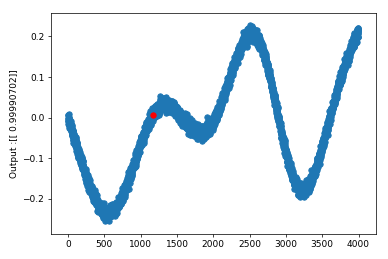

Output after iteration 1 is  0.02: 
Output after iteration 2 is  0.02: 
Output after iteration 3 is  0.02: 
Output after iteration 4 is  0.02: 
Output after iteration 5 is  0.02: 
Output after iteration 6 is  0.02: 
Output after iteration 7 is  0.02: 
Output after iteration 8 is  0.02: 
Output after iteration 9 is  0.02: 
Output after iteration 10 is  0.02: 
Output after iteration 11 is  0.02: 
Output after iteration 12 is  0.02: 
Output after iteration 13 is  0.02: 
Output after iteration 14 is  0.02: 
Output after iteration 15 is  0.02: 
Output after iteration 16 is  0.02: 
-------NEW POSITION-------
Output after iteration 18 is  0.02: 
Output after iteration 19 is  0.12: 
Output after iteration 20 is  0.02: 
Output after iteration 21 is  0.02: 
Output after iteration 22 is  0.77: 
Output after iteration 23 is  0.02: 
Output after iteration 24 is  0.77: 
Output after iteration 25 is  0.02: 
Output after iteration 26 is  0.77: 
Output after iteration 27 is  0.02: 
Output after iterati

In [88]:
climber.change_terrain(get_random_terrain(4000)+get_noise(4000,0.008))
climber_trainer(climber,training=False,show_animation=True,reset_enabled=True,iterations=100)



-------NEW POSITION-------


<IPython.core.display.Javascript object>


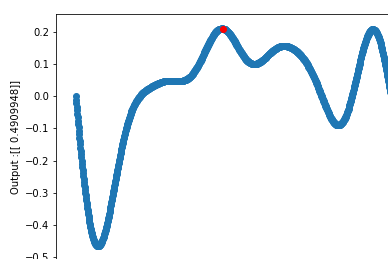

Output after iteration 1 is  0.39: 
Output after iteration 2 is  0.40: 
Output after iteration 3 is  0.69: 
Output after iteration 4 is  0.40: 
Output after iteration 5 is  0.69: 
Output after iteration 6 is  0.40: 
Output after iteration 7 is  0.69: 
Output after iteration 8 is  0.40: 
Output after iteration 9 is  0.69: 
Output after iteration 10 is  0.40: 
-------NEW POSITION-------
Output after iteration 12 is  1.00: 
Output after iteration 13 is  1.00: 
Output after iteration 14 is  1.00: 
Output after iteration 15 is  1.00: 
Output after iteration 16 is  0.92: 
Output after iteration 17 is  0.40: 
Output after iteration 18 is  0.92: 
Output after iteration 19 is  0.40: 
Output after iteration 20 is  0.92: 
Output after iteration 21 is  0.40: 
-------NEW POSITION-------
Output after iteration 23 is  1.00: 
Output after iteration 24 is  1.00: 
Output after iteration 25 is  1.00: 
Output after iteration 26 is  0.98: 
Output after iteration 27 is  0.39: 
Output after iteration 28 is  

-------NEW POSITION-------
Output after iteration 226 is  1.00: 
Output after iteration 227 is  1.00: 
Output after iteration 228 is  1.00: 
Output after iteration 229 is  0.81: 
Output after iteration 230 is  0.48: 
Output after iteration 231 is  0.81: 
Output after iteration 232 is  0.48: 
Output after iteration 233 is  0.81: 
Output after iteration 234 is  0.48: 
Output after iteration 235 is  0.81: 
-------NEW POSITION-------
Output after iteration 237 is  1.00: 
Output after iteration 238 is  1.00: 
Output after iteration 239 is  1.00: 
Output after iteration 240 is  1.00: 
Output after iteration 241 is  1.00: 
Output after iteration 242 is  0.40: 
Output after iteration 243 is  1.00: 
Output after iteration 244 is  0.40: 
Output after iteration 245 is  1.00: 
Output after iteration 246 is  0.40: 
-------NEW POSITION-------
Output after iteration 248 is  1.00: 
Output after iteration 249 is  1.00: 
Output after iteration 250 is  1.00: 
Output after iteration 251 is  1.00: 
Output 

In [ ]:
#Model does not generalazie to noise well
climber.change_terrain(get_random_terrain())
climber_trainer(climber,False,True,True,500)